## Objective:
The aim of this notebook is to document the experiments that I did during this competition. I had a ton of fun doing it. Yet it wasn't always fun & there were times when nothing I did seemed to improve the Public LB and I would be so frustrated. The metric was puzzling enough for me so I decided that I am not going to venture into the world of deep learning until I thoroughly completed my exploration with ML. However even this seemed a difficult task, so I decided to stick simply with `LinearRegression`.

Choosing such a simple model simplified things greatly for me & provided me several advantanges:: 
1. There was no overfitting to the dataset. 
2. No parameters that needed fine tuning.
3. It forces you to hand craft clever features that have more predictive potential.
4. It is a white box algorithm, meaning that you can literally see how a model is making its predictions.

Unfortunately the competition came to an end just when I was about to start using the scan data. Or maybe it was the other way round, I frantically tried incorporating and extracting features from the scan data. I have however documented my ideas as to how I might have used the scan data. Let me know if those ideas would indeed have worked.

**It is my earnest hope that you derive the same joy that I experienced during my explorations by reading this Notebook. Happy reading!**

## Import necessary modules, load the data:


The snippet below is to install the GDCM module. Certain scans (Two of them) couldnt be opened simply via the `pydicom` module. We are unsure if any of the test scans contained similar scans. So it's better that we install them to be on the safer side.

In [1]:
!dpkg -i ../input/python3gdcm/build_1-1_amd64.deb
!apt-get install -f

!cp /usr/local/lib/gdcm.py /opt/conda/lib/python3.7/site-packages/.
!cp /usr/local/lib/gdcmswig.py /opt/conda/lib/python3.7/site-packages/.
!cp /usr/local/lib/_gdcmswig.so /opt/conda/lib/python3.7/site-packages/.
!cp /usr/local/lib/libgdcm* /opt/conda/lib/python3.7/site-packages/.
!ldconfig

Selecting previously unselected package build.
(Reading database ... 113054 files and directories currently installed.)
Preparing to unpack .../build_1-1_amd64.deb ...
Unpacking build (1-1) ...
Setting up build (1-1) ...



0 upgraded, 0 newly installed, 0 to remove and 70 not upgraded.
/sbin/ldconfig.real: File /usr/lib/x86_64-linux-gnu/libnvidia-cfg.so.418.67 is empty, not checked.
/sbin/ldconfig.real: File /usr/lib/x86_64-linux-gnu/libcuda.so.1 is empty, not checked.
/sbin/ldconfig.real: File /usr/lib/x86_64-linux-gnu/libnvidia-compiler.so.418.67 is empty, not checked.
/sbin/ldconfig.real: File /usr/lib/x86_64-linux-gnu/libnvidia-opencl.so.418.67 is empty, not checked.
/sbin/ldconfig.real: File /usr/lib/x86_64-linux-gnu/libnvidia-ml.so.1 is empty, not checked.
/sbin/ldconfig.real: File /usr/lib/x86_64-linux-gnu/libnvidia-ptxjitcompiler.so.418.67 is empty, not checked.
/sbin/ldconfig.real: File /usr/lib/x86_64-linux-gnu/libcuda.so is empty, not checked.
/sbin/ldconfig.real: File /usr

Import modules we would be frequently using. We would import many more along the way as they are needed.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import gdcm
import pydicom
import glob

from tqdm import tqdm
%matplotlib inline

In [3]:
# kaggle
main_dir = "../input/osic-pulmonary-fibrosis-progression"

!ls {main_dir}

sample_submission.csv  test  test.csv  train  train.csv


In [4]:
train_files = tf.io.gfile.glob(main_dir+"/train/*/*")
test_files = tf.io.gfile.glob(main_dir+"/test/*/*")
sample_sub = pd.read_csv(main_dir + "/sample_submission.csv")
train = pd.read_csv(main_dir + "/train.csv")
test = pd.read_csv(main_dir + "/test.csv")

print ("Number of train patients: {}\nNumber of test patients: {:4}"
       .format(train.Patient.nunique(), test.Patient.nunique()))

print ("\nTotal number of Train patient records: {}\nTotal number of Test patient records: {:6}"
       .format(len(train_files), len(test_files)))

train.shape, test.shape, sample_sub.shape

Number of train patients: 176
Number of test patients:    5

Total number of Train patient records: 33026
Total number of Test patient records:   1261


((1549, 7), (5, 7), (730, 3))

### Let's aquaint ourselves with reading, extracting DCM files using pydicom:

In [5]:
# pydicom files are read with dcmread
temp = pydicom.dcmread(train_files[0])
type(temp)

pydicom.dataset.FileDataset

In [6]:
# displaying a few items from the dicom file
# elements are stored as tuple key pairs
print ('\n'.join(str(temp).split("\n")[:15]))

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 2.25.16143083877328203530654424878659479827
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.1
(0002, 0013) Implementation Version Name         SH: 'OSIRIX_361'
(0002, 0016) Source Application Entity Title     AE: 'ANONYMOUS'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']
(0008, 0018) SOP Instance UID                    UI: 2.25.16143083877328203530654424878659479827
(0008, 0060) Modality                            CS: 'CT

Str function on `pydicom.dataset.FileDataset` returns a string representation.
The left part shows the keys (TAG NUMBERS or DICOM KEYWORDS) right part display the coresponding values.

In [7]:
# tuple keys can be obtained using .keys()
# since `pydicom.dataset.FileDataset` is a 
# wrapper for dictionary files
list(temp.keys())[:5]

[(0008, 0005), (0008, 0008), (0008, 0018), (0008, 0060), (0008, 0070)]

In [8]:
# returns all NON PRIVATE elements
# values can be accessed both ways
print (temp.dir()[:5])

['BitsAllocated', 'BitsStored', 'BodyPartExamined', 'Columns', 'ConvolutionKernel']


In [9]:
# a value can be accessed using all these methods
(
    temp.BitsAllocated, 
    temp.get('BitsAllocated'),
    temp.data_element("BitsAllocated").value, 
    temp[(0x28, 0x100)].value, 
    temp.get([0x28, 0x100]).value
)

(16, 16, 16, 16, 16)

In [10]:
# We need to use .value when accessing using 
# tuple keys.But what does it exactly return?
key = (0x08, 0x08)
print ("Accessing by a tuple key returns a", type(temp[key]).__name__)

Accessing by a tuple key returns a DataElement


In [11]:
# some common methods of all DataElement(s)
print (list(filter(lambda x: "__" not in x, dir(pydicom.DataElement))))

['VM', '_convert', '_convert_value', 'clear', 'descripWidth', 'description', 'empty_value', 'from_json', 'is_empty', 'is_raw', 'is_retired', 'keyword', 'maxBytesToDisplay', 'name', 'repval', 'showVR', 'to_json', 'to_json_dict', 'value']


In [12]:
# VR -> Value representation. The Value Representation of a Data Element 
# describes the data type and format of that Data Element's Value
temp[key].VR

'CS'

In [13]:
# other possible Value representations in this file alone
np.unique(list(map(lambda x: x.VR, temp.iterall())))

array(['CS', 'DS', 'FD', 'IS', 'LO', 'OW', 'PN', 'SH', 'UI', 'US'],
      dtype='<U2')

Common VR's observed:
1. CS -> Code string. 
2. DS -> Decimal String
3. IS -> Integer String
4. LO -> Long String
5. OW -> Other word 
6. PN -> Person Name
7. SH -> Short string
8. UI -> Unique identifier
9. US -> Unsigned short

Visit [here](http://dicom.nema.org/medical/dicom/current/output/chtml/part05/sect_6.2.html) for an exhaustive list of all possible value representations.

In [14]:
# usually the neatly formated
# version of the DICOM Keyword
temp[key].description()

'Image Type'

In [15]:
# number of values in the dataElement can be accessed using .VM
print ("Value: {}\nContains {} elements".format(temp['Modality'].value, temp['Modality'].VM))
print ("\nValue: {}\nContains {} elements".format(temp['ImageType'].value, temp['ImageType'].VM))

Value: CT
Contains 1 elements

Value: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']
Contains 4 elements


In [16]:
# is the data element empty
temp['PatientSex'].is_empty, temp['ImageType'].is_empty

(True, False)

In [17]:
# access DICOM keyword from tag number
temp[(0x18, 0x1151)].keyword

'XRayTubeCurrent'

In [18]:
# .repval returns value as a string
print ("{} is saved as {}".format(temp['XRayTubeCurrent'].repval, type(temp['XRayTubeCurrent'].repval)))
print ("{} is saved as {}".format(temp['XRayTubeCurrent'].value, type(temp['XRayTubeCurrent'].value)))

"491" is saved as <class 'str'>
491 is saved as <class 'pydicom.valuerep.IS'>


In [19]:
# all Dicom files contain a meta header that
# can be accessed as follows:
temp.file_meta

(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 2.25.16143083877328203530654424878659479827
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.1
(0002, 0013) Implementation Version Name         SH: 'OSIRIX_361'
(0002, 0016) Source Application Entity Title     AE: 'ANONYMOUS'

In [20]:
# to obtain a subset of the dataset
# belonging to a key, 0x28 would
# return all items of key tuples 
# with first element as 0x28
temp.group_dataset(0x28)

(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                                US: 512
(0028, 0011) Columns                             US: 512
(0028, 0030) Pixel Spacing                       DS: [0.576171875, 0.576171875]
(0028, 0100) Bits Allocated                      US: 16
(0028, 0101) Bits Stored                         US: 12
(0028, 0102) High Bit                            US: 11
(0028, 0103) Pixel Representation                US: 0
(0028, 0106) Smallest Image Pixel Value          US: 0
(0028, 0107) Largest Image Pixel Value           US: 2878
(0028, 1050) Window Center                       DS: "-500.0"
(0028, 1051) Window Width                        DS: "-1500.0"
(0028, 1052) Rescale Intercept                   DS: "-1024.0"
(0028, 1053) Rescale Slope                       DS: "1.0"
(0028, 1054) Rescale Type                        LO: 'HU'
(0028, 1055) Window Center & Width Explanat

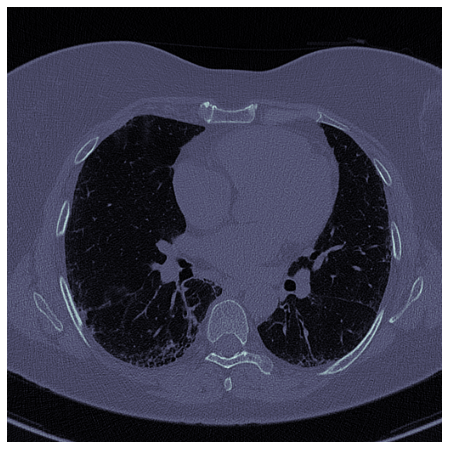

In [21]:
# to obtain the image from the dicom file
# use pixel array; Bone is more suited for
# ct scan images
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(temp.pixel_array, cmap='bone');

### Let's begin exploring our dataset:

In [22]:
train.head()

Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker
1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker
2  ID00007637202177411956430      7  2061  51.862104   79  Male     Ex-smoker
3  ID00007637202177411956430      9  2144  53.950679   79  Male     Ex-smoker
4  ID00007637202177411956430     11  2069  52.063412   79  Male     Ex-smoker

In [23]:
# test has just 5 rows
test

Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus
0  ID00419637202311204720264      6  3020  70.186855   73  Male     Ex-smoker
1  ID00421637202311550012437     15  2739  82.045291   68  Male     Ex-smoker
2  ID00422637202311677017371      6  1930  76.672493   73  Male     Ex-smoker
3  ID00423637202312137826377     17  3294  79.258903   72  Male     Ex-smoker
4  ID00426637202313170790466      0  2925  71.824968   73  Male  Never smoked

In [24]:
# we have to predict FVC & CONFIDENCE values
# for these patients from week -12 to 133
# (145 weeks each patient)
sample_sub.tail()

Patient_Week   FVC  Confidence
725  ID00419637202311204720264_133  2000         100
726  ID00421637202311550012437_133  2000         100
727  ID00422637202311677017371_133  2000         100
728  ID00423637202312137826377_133  2000         100
729  ID00426637202313170790466_133  2000         100

In [25]:
# any missing values?
train.isna().sum().any(), test.isna().sum().any()

(False, False)

In [26]:
# checking data type of each col
train.info(null_counts=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column         Dtype  
---  ------         -----  
 0   Patient        object 
 1   Weeks          int64  
 2   FVC            int64  
 3   Percent        float64
 4   Age            int64  
 5   Sex            object 
 6   SmokingStatus  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 84.8+ KB


I suspect that some values in the train dataset are redundant, such as `Age`, `Sex` & `SmokingStatus`. Let's verify if we are correct:

In [27]:
# columns that don't change with time for each patient
(train.groupby('Patient').nunique() != 1).sum() == 0

Weeks            False
FVC              False
Percent          False
Age               True
Sex               True
SmokingStatus     True
dtype: bool

We are indeed correct. The above mentioned columns don't change over time at all, despite a very long time duration. Age of a person, Smoking Status & Sex (obviously) remains unchanged over time.

Although we would expect the Age of a person to vary over a span of 145 weeks, this doesn't seem to happen.

#### How many unique values have we got for each column?

In [28]:
train.nunique()

Patient           176
Weeks             112
FVC              1202
Percent          1536
Age                34
Sex                 2
SmokingStatus       3
dtype: int64

Max Patient Age: 49
Min Patient Age: 88


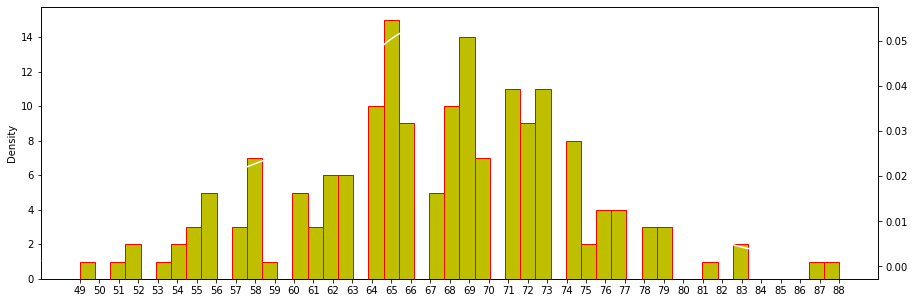

In [29]:
ages = train.groupby('Patient').Age.head(1)
print ("Max Patient Age: {}\nMin Patient Age: {}".format(ages.min(), ages.max()))
ax = ages.plot(kind='hist', bins=50, edgecolor='red', color='y', figsize=(15, 5), xticks=range(49, 89))
ages.plot(kind='kde', ax=ax, xlim=(47, 90), color='w', secondary_y=True);

Observations:
- Majority of the patients lie between the Age group of 60 - 75. 
- Has a guassian distribution.

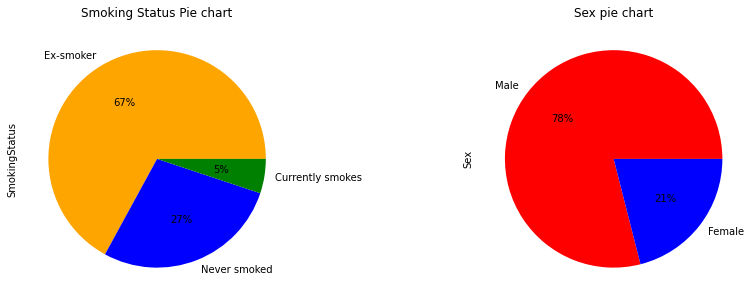

In [30]:
f, ax = plt.subplots(figsize=(15, 5), ncols=2)

train.groupby('Patient').SmokingStatus.head(1).value_counts().plot(
    kind='pie', ax=ax[0], autopct=lambda x: str(int(x))+"%", 
    title='Smoking Status Pie chart', 
    colors=['orange', 'blue', 'green'])

train.groupby('Patient').Sex.head(1).value_counts().plot(
    kind='pie', ax=ax[1], autopct=lambda x: str(int(x))+"%", 
    title='Sex pie chart', colors=['red', 'blue']);

Observations:
- A majority of the patients are ex smokers. 
- Most of the patients are male (~ 80%)

How does gender vary across smoking status?

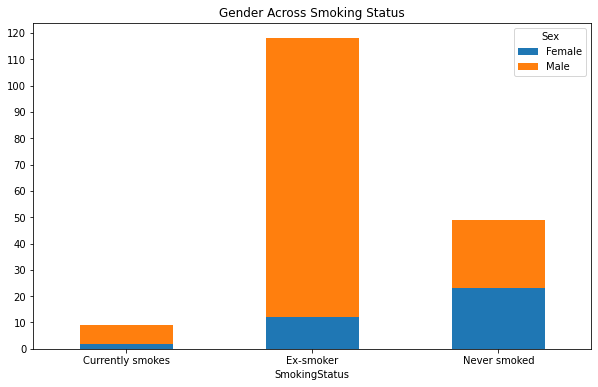

In [31]:
train.groupby(['SmokingStatus', 'Sex'])['Patient'].nunique().unstack().plot(
    kind='bar', stacked=True, figsize=(10, 6), yticks=range(0, 130, 10),
    rot=0, title='Gender Across Smoking Status');

Observations:
- Most of the Female patients have never smoked before
- Most of the Male patients are ex smokers. 
- Very few people belong to the category of 'CurrentlySmoking'.

Let's now see how the other features vary across the different genders:

In [32]:
train.groupby("Sex").agg(['min', 'max', 'mean', 'std']).drop("Age", axis=1)

Weeks                             FVC                                 \
         min  max       mean        std  min   max         mean         std   
Sex                                                                           
Female    -5  102  34.913846  23.803827  827  3486  1877.969231  580.845833   
Male      -4  133  31.051471  23.039618  919  6399  2906.218954  752.598318   

          Percent                                    
              min         max       mean        std  
Sex                                                  
Female  34.160477  145.495722  82.341931  24.097719  
Male    28.877577  153.145378  76.432854  18.336162

Some insights:
- Males biologically have much higher FVC on average. 
- Even though mean FVC for males is greater, percent mean is actually lower for males than females. 
- Females are expected to be healthier? Females admitted are relatively healthier to males?

#### How other features change with respect to age:

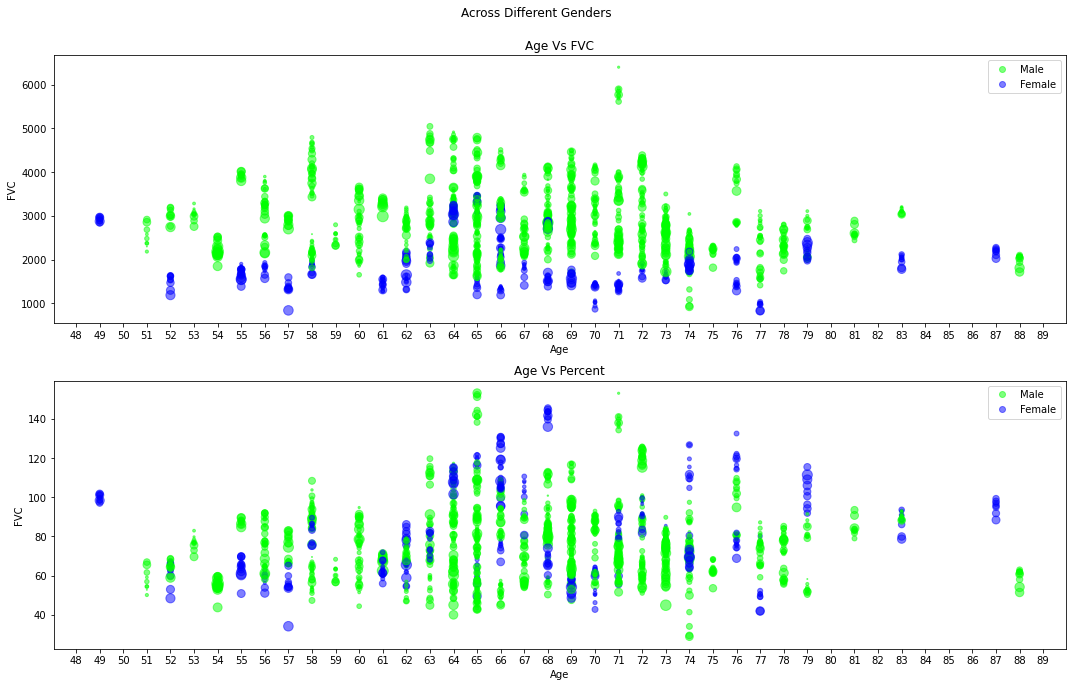

In [33]:
f, ax = plt.subplots(nrows=2, figsize=(15, 10))

sc = ax[0].scatter(
    'Age', 'FVC', c=train.Sex.map({'Male': 0, 'Female': 1}), 
    s=(train.Weeks+5), data=train, cmap='brg_r', alpha=0.5)

ax[0].set(
    xlabel='Age', ylabel='FVC', xticks=range(48, 90), 
    title="Age Vs FVC")
ax[0].legend(sc.legend_elements()[0], ['Male', 'Female'])

sc = ax[1].scatter(
    'Age', 'Percent', c=train.Sex.map({'Male': 0, 'Female': 1}), 
    s=(train.Weeks+5), data=train, cmap='brg_r', alpha=0.5)

ax[1].set(
    xlabel='Age', ylabel='FVC', xticks=range(48, 90), 
    title="Age Vs Percent");
ax[1].legend(sc.legend_elements()[0], ['Male', 'Female'])

f.suptitle("Across Different Genders")
f.tight_layout(rect=[0, 0.03, 1, 0.95]);

Observations:
1. For any age group, FVC for males is higher than FVC for females as we had already observed
2. Whereas, this distinction is not clear in case of Percent.

Let's see statistically how the continous features vary across the categorical features:

In [34]:
(train
 .groupby(["SmokingStatus"])[['Weeks', 'FVC', 'Percent']].agg({
     "Weeks": "count",
     "FVC": ['min', 'mean', 'max'], 
     "Percent": ['min', 'mean', 'max']})
 .rename({"Weeks": "Cumulative Records"}, axis=1))

Cumulative Records   FVC                       Percent  \
                              count   min         mean   max        min   
SmokingStatus                                                             
Currently smokes                 82  1941  3206.000000  4791  51.594896   
Ex-smoker                      1038   919  2784.578998  6399  28.877577   
Never smoked                    429   827  2364.258741  4386  34.160477   

                                         
                       mean         max  
SmokingStatus                            
Currently smokes  97.599136  153.145378  
Ex-smoker         76.429480  153.012912  
Never smoked      76.871820  132.453857

Strangely enough, the current smokers have greater FVC & percent than other categories, as opposed to what we would expect. 

Possible explaination: Those who have come under our data might be there due a naturally poor FVC or be there *because* of smoking. Put in other words, *those who have never smoked and those who have naturally high FVC wouldn't be having much respiratory ailments or require diagnosis.*

Let's now divide the above DataFrame by adding another category: Sex.

In [35]:
(train
 .groupby(["SmokingStatus", 'Sex'])[['Weeks', 'FVC', 'Percent']].agg({
     "Weeks": "count",
     "FVC": ['min', 'mean', 'max'], 
     "Percent": ['min', 'mean', 'max']})
 .rename({"Weeks": "Cumulative Records"}, axis=1))

Cumulative Records   FVC                     \
                                     count   min         mean   max   
SmokingStatus    Sex                                                  
Currently smokes Female                 18  2701  2868.833333  2975   
                 Male                   64  1941  3300.828125  4791   
Ex-smoker        Female                107  1285  1901.906542  3247   
                 Male                  931   919  2886.024705  6399   
Never smoked     Female                200   827  1775.985000  3486   
                 Male                  229  1612  2878.034934  4386   

                           Percent                          
                               min        mean         max  
SmokingStatus    Sex                                        
Currently smokes Female  97.024624  120.871764  145.495722  
                 Male    51.594896   91.053710  153.145378  
Ex-smoker        Female  50.849947   81.727499  130.821918  
                 Male    28.877577   75.820578  153.012912  
Never smoked     Female  34.160477   79.202967  132.453857  
                 Male    42.841450   74.835884  122.513966

* Now the mean FVC's of those who have never smoked and the current smokers are a little closer. Although the current smokers still have higher FVC's, the difference isn't atleast as great as before. Maybe Smoking indeed increases FVC.

* The percentage feature however is still unchanged.

* Females who currently smoke have a much high Percent expectency than males. 

* The range of FVC for current female smokers are also within a much narrow window of 2700 to 2975. This is the case since, there are only two female patients who are current smokers:

In [36]:
# females who smoke
train.loc[(train.Sex == 'Female') & (train.SmokingStatus == 'Currently smokes'), 'Patient'].nunique()

2

General FVC trend we observe: <br>
1. FVC's for males: Never Smoked < Ex-Smokers < Current Smokers<br>
2. FVC's for females: Never Smoked < Ex-smokers < Current Smokers.

#### Let's calculate see the progression of FVC over the course of treatment for various categories:

In [37]:
# we use savgol filter to smooth curves
from scipy.signal import savgol_filter

def display_FVC_progress(data, title, smooth=True, drop=1, median=True):
    
    agg = ['count', 'min', 'median', 'max']
    if not median:
        agg.remove("median")

    temp = data.groupby('Weeks')[['FVC']].agg(agg)
    temp = temp[temp['FVC']['count'] > drop].drop(("FVC", 'count'), axis=1)

    if smooth:
        # smoothing out the curves
        temp['FVC', 'max'] = savgol_filter(temp['FVC', 'max'], 9, 3)
        temp['FVC', 'min'] = savgol_filter(temp['FVC', 'min'], 9, 3)

    ax = temp.plot(
        figsize=(15, 5), 
        title=f'Variation & progress of FVC over the Weeks ({title})', 
        legend=True, xticks=range(-10, 150, 5));

    ax.fill_between(temp.index, temp['FVC', 'max'], temp['FVC', 'min'], color='green');

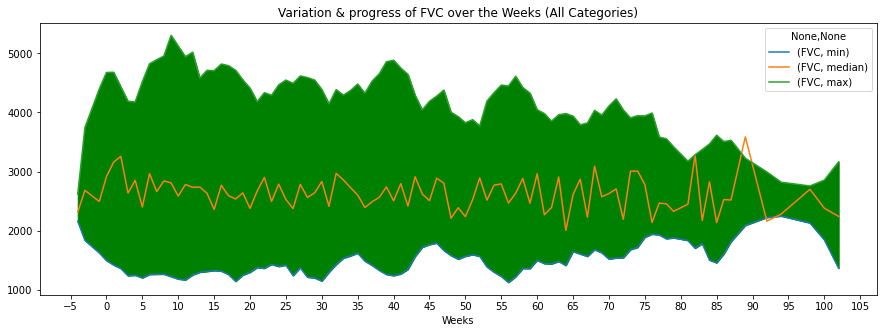

In [38]:
# FVC Progress across all patients
display_FVC_progress(train, 'All Categories')

- We can observe that intially the variation is high but over the weeks, variation between max and min FVC keeps decreasing. Confidence value could initially be low and later on increased.

- The median values are usually closer to min than max (again indicates the skew). *It's safer to predict values closer to min than to max.*

- There is a slight declining trend of FVC

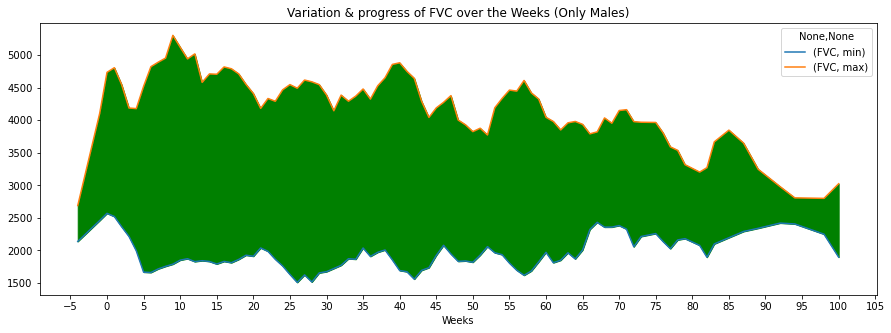

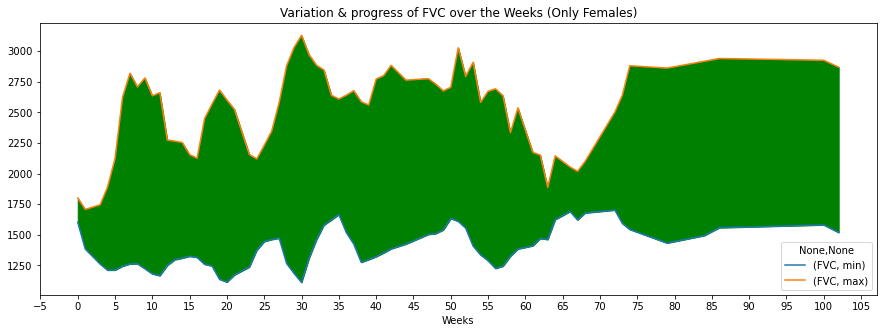

In [39]:
# FVC progress across Sex
display_FVC_progress(train.loc[train.Sex == 'Male'], 'Only Males', drop=1, smooth=True, median=False)
display_FVC_progress(train.loc[train.Sex == 'Female'], 'Only Females', drop=1, smooth=True, median=False)

- The trend for males is slightly declining. While it is slightly improving for females.
- The range appears more chaotic for females, probably due to low number of female patient data available.

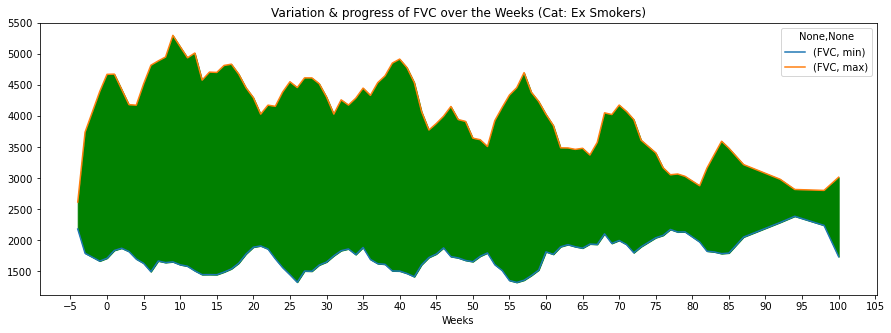

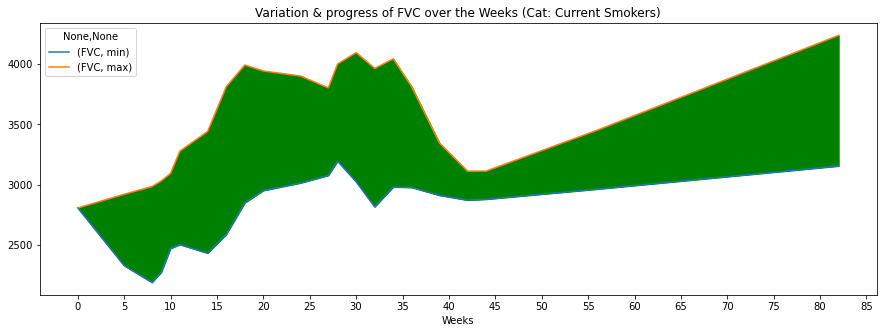

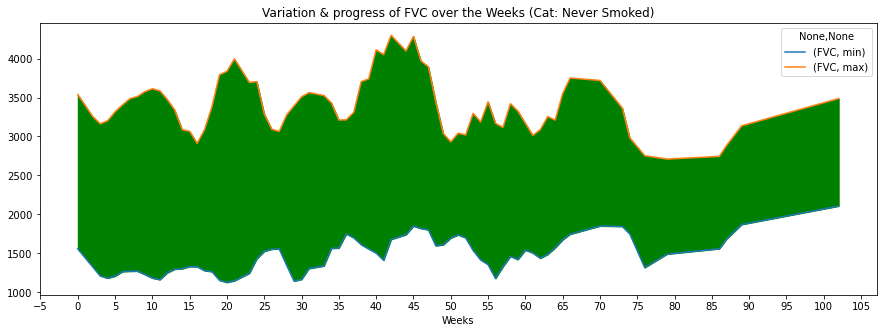

In [40]:
# FVC progress across SmokingStatus
display_FVC_progress(train.loc[train.SmokingStatus == 'Ex-smoker'], 'Cat: Ex Smokers', median=False)
display_FVC_progress(train.loc[train.SmokingStatus == 'Currently smokes'], 'Cat: Current Smokers', median=False)
display_FVC_progress(train.loc[train.SmokingStatus == 'Never smoked'], 'Cat: Never Smoked', median=False)

Ex smoker's FVC initially decreases and then flattens out. Whereas the trend for Never smoked and currently smoking is increasing. Although we need to remind ourselvs that there are relatively little Current smoker's  data available.

Now that we have seen how the trend is for different groups, set's see how FVC progression of random patients from each group look like. But before we do that, let's answer a more simpler question: how many observations do we have for each patient?

In [41]:
# min, max and mean patient observations
train.groupby('Patient')['Weeks'].count().agg(['min', 'max', 'mean'])

min      6.000000
max     10.000000
mean     8.801136
Name: Weeks, dtype: float64

It varies from a minimum of 6 weeks to a maximum of 10 week observations, using which we have to predict for 145 weeks. 

In [42]:
# any repeating observations for the same week?
temp = train.groupby("Patient")['Weeks'].agg(['count', 'nunique'])
temp = temp[temp['count'] != temp['nunique']].index
len(temp)

7

We have some patients for whom multiple FVC were taken for the same week, let's probe further:

In [43]:
train[train.Patient == np.random.choice(temp)]

Patient  Weeks   FVC    Percent  Age   Sex  \
920  ID00240637202264138860065      5  2991  78.421605   63  Male   
921  ID00240637202264138860065      5  3132  82.118511   63  Male   
922  ID00240637202264138860065      8  2872  75.301521   63  Male   
923  ID00240637202264138860065      9  2807  73.597273   63  Male   
924  ID00240637202264138860065     12  2779  72.863136   63  Male   
925  ID00240637202264138860065     18  2713  71.132669   63  Male   
926  ID00240637202264138860065     30  2503  65.626639   63  Male   
927  ID00240637202264138860065     41  2762  72.417410   63  Male   
928  ID00240637202264138860065     57  2782  72.941793   63  Male   

    SmokingStatus  
920     Ex-smoker  
921     Ex-smoker  
922     Ex-smoker  
923     Ex-smoker  
924     Ex-smoker  
925     Ex-smoker  
926     Ex-smoker  
927     Ex-smoker  
928     Ex-smoker

All these patients with multiple observations taken for the same week occur either on the first week or on the last week of their clinical observation. 

Maybe they were taken for confirmation. Let's keep only that FVC observation that is closest to second Week's Observation:

In [44]:
multiple = train.groupby(['Patient', "Weeks"])[['FVC', 'Percent']].agg(['min', 'max'], 1)

multiple = multiple[[('FVC', 'min'), ("Percent", 'min')]].where(
    multiple['Percent'].diff().abs().shift(-1).apply(np.argmin, 1) == 0, 
    multiple[[('FVC', 'max'), ("Percent", 'max')]].values)

multiple.columns = multiple.columns.droplevel(1)
multiple = multiple.rename_axis(None, axis=1).reset_index()

train = multiple.merge(
    train[['Patient', 'Age', 'Sex', 'SmokingStatus']].groupby("Patient").head(1),
    on='Patient')

# rain check
train[train.Patient == np.random.choice(temp)]

Patient  Weeks   FVC    Percent  Age   Sex  \
462  ID00125637202218590429387      8  2349  53.757781   65  Male   
463  ID00125637202218590429387     10  2337  53.483156   65  Male   
464  ID00125637202218590429387     12  2330  53.322959   65  Male   
465  ID00125637202218590429387     14  2320  53.094105   65  Male   
466  ID00125637202218590429387     20  2093  47.899121   65  Male   
467  ID00125637202218590429387     34  2027  46.388685   65  Male   
468  ID00125637202218590429387     45  1872  42.841450   65  Male   

    SmokingStatus  
462  Never smoked  
463  Never smoked  
464  Never smoked  
465  Never smoked  
466  Never smoked  
467  Never smoked  
468  Never smoked

#### FVC progression samples of patients from various groups:

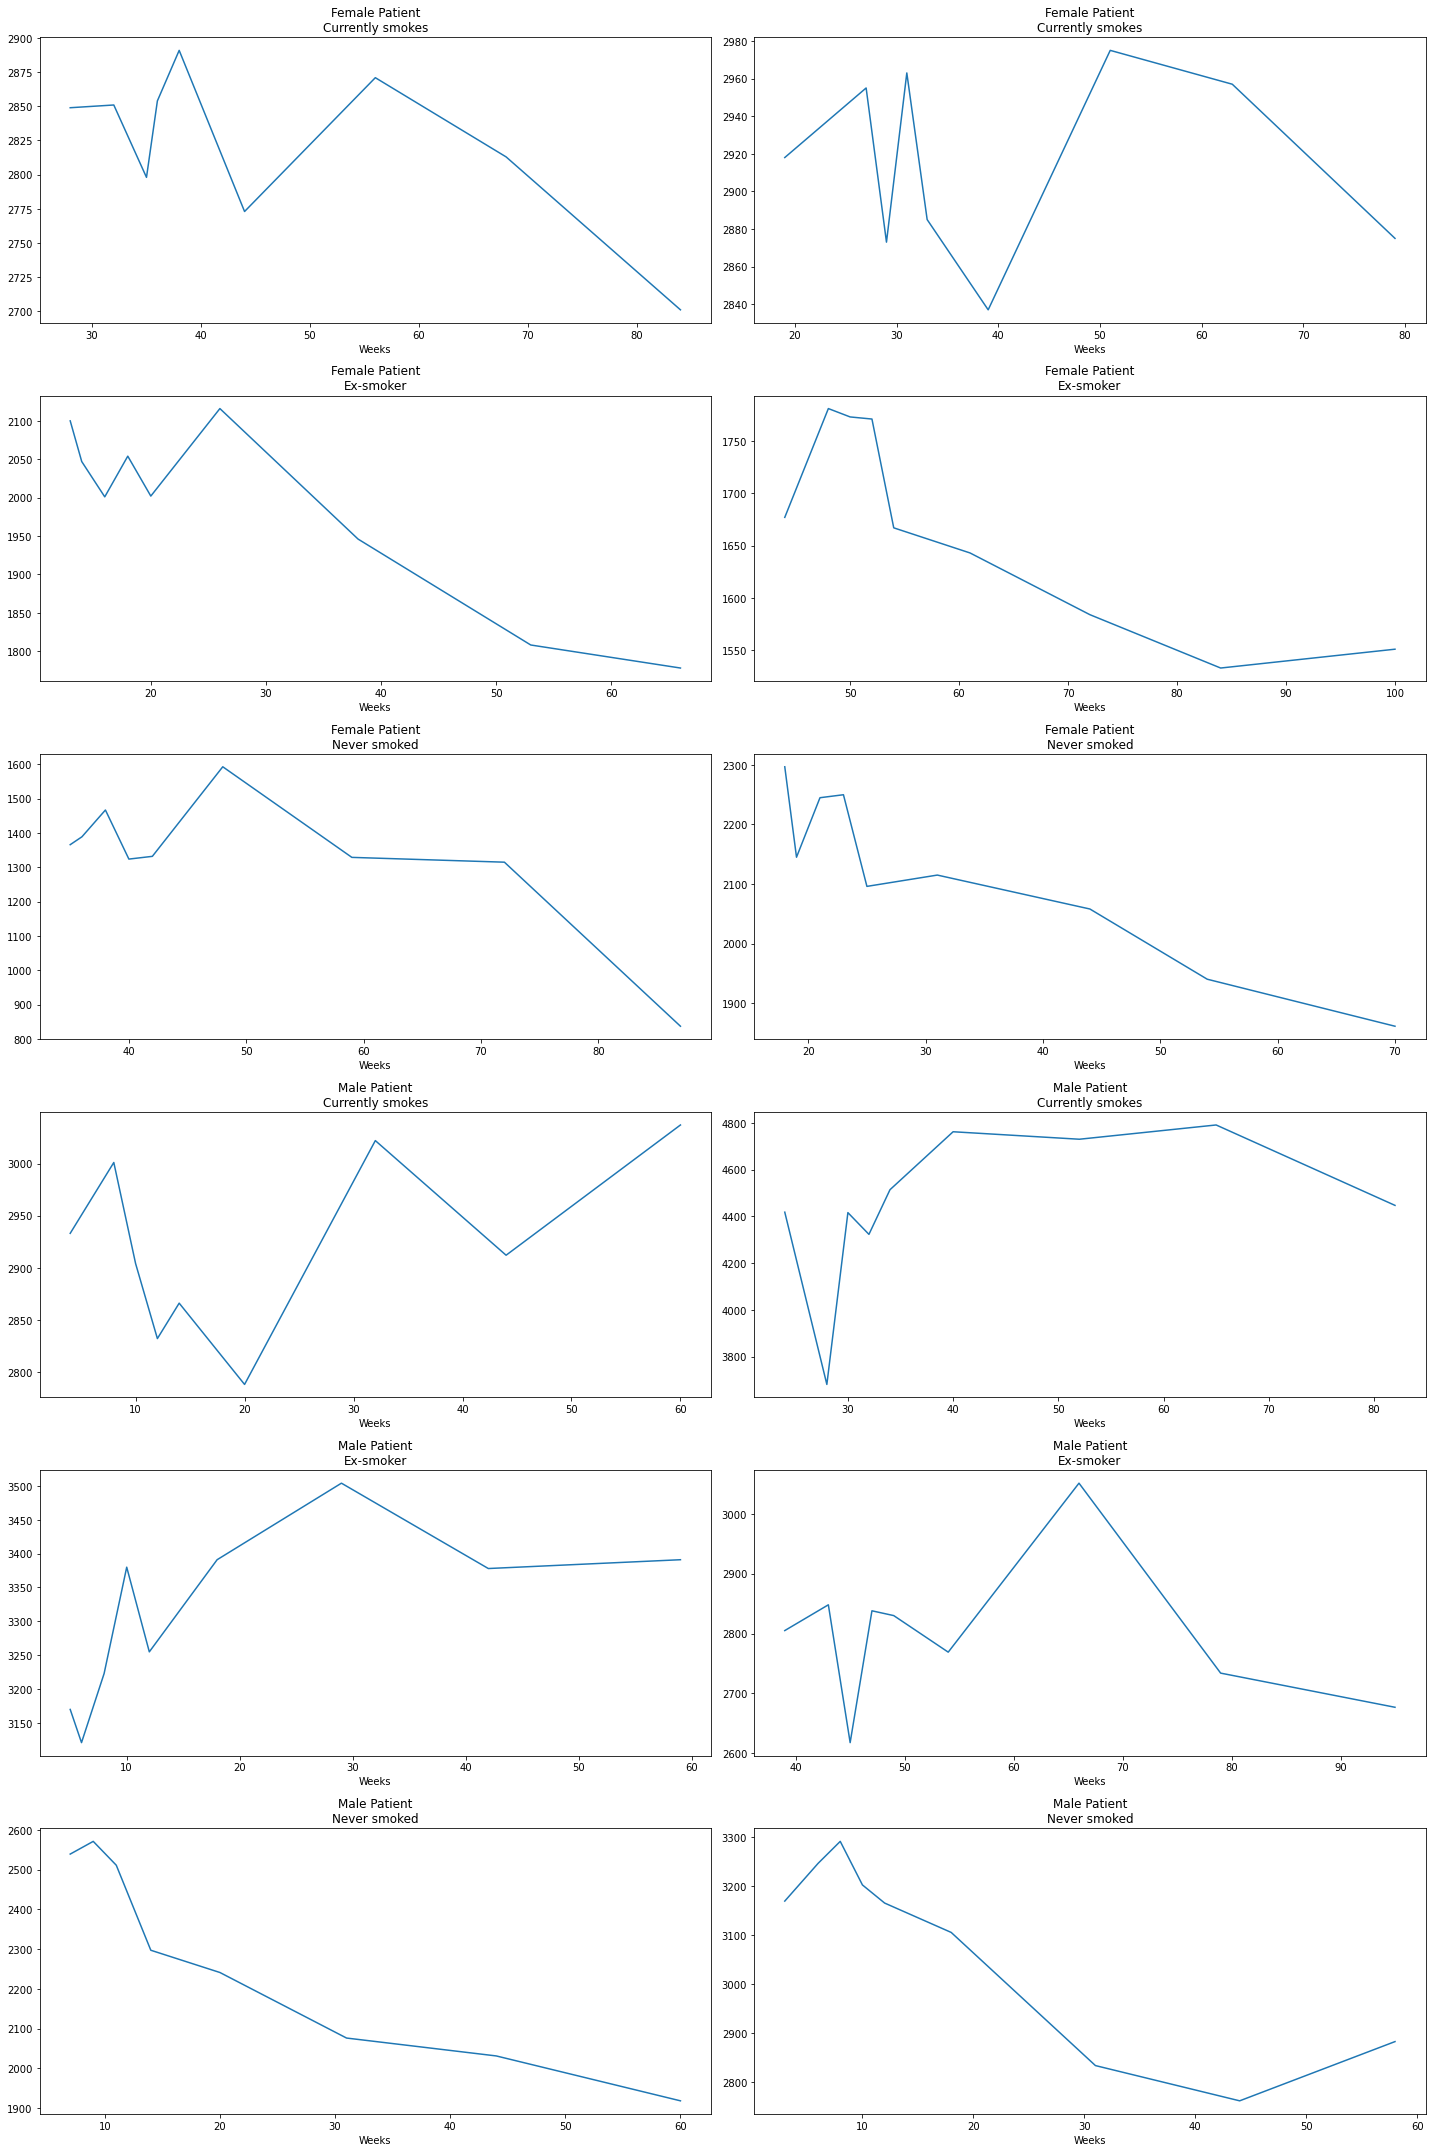

In [45]:
# to increase choices, set replace as false in np.random.choice
# since there are very few female patient's available
choice = 2 # two each

temp = (train.groupby(['Sex', 'SmokingStatus'])['Patient']
        .apply(lambda x: np.random.choice(np.unique(x), size=choice, replace=False))
        .reset_index())

f, ax = plt.subplots(ncols=choice, nrows=6, figsize=(20, 30))
for i, sex, status, patients in temp.itertuples():
    
    for j in range(choice):
    
        (train
         .loc[train.Patient == patients[j], ['FVC', 'Weeks']]
         .set_index('Weeks')
         .plot(ax=ax[i][j], title=f"{sex} Patient\n{status}", legend=False)
        )
        
f.tight_layout();

The metric used in this competition is `Laplace log likelihood`. It works as follows:

1. Confidence values smaller than 70 are clipped. 

$σ_{clipped}=max(σ,70)$

2. Errors greater than 1000 are also clipped in order to avoid large errors. 

$Δ=min(|FVC_{true}−FVC_{predicted}|,1000)$

3. Finally the metric is defined as: 

$metric=−\dfrac{\sqrt2Δ}{σ_{clipped}}−ln(\sqrt2σ_{clipped})$

We simply rewrite the code from [here](https://www.kaggle.com/gunesevitan/osic-pulmonary-fibrosis-progression-eda) in numpy to tensorflow. *I wrote in tensorflow so that it would be easy to reuse the code in tf models. However my plans changed and I never really used TF much.*

In [46]:
def laplace_log_likelihood(y_true, y_pred, sigma=70):
    # values smaller than 70 are clipped
    sigma_clipped = tf.maximum(sigma, 70)

    # errors greater than 1000 are clipped
    delta_clipped = tf.minimum(tf.abs(y_true - y_pred), 1000)
    
    # type cast them suitably
    delta_clipped = tf.cast(delta_clipped, dtype=tf.float32)
    sigma_clipped = tf.cast(sigma_clipped, dtype=tf.float32)
    
    # score function
    score = - tf.sqrt(2.0) * delta_clipped / sigma_clipped - tf.math.log(tf.sqrt(2.0) * sigma_clipped)
    
    return tf.reduce_mean(score)

In [47]:
# perfect score would be
laplace_log_likelihood(train['FVC'], train['FVC'], 70)

<tf.Tensor: shape=(), dtype=float32, numpy=-4.5950694>

Now that we have our scoring function ready, let's see how `confidence` affects the scores:

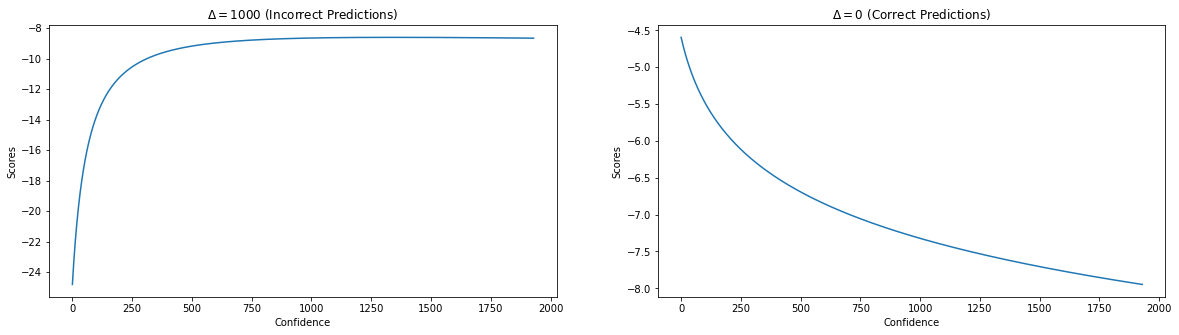

In [48]:
# an impossibly high FVC (delta would be set to 1000)
# varying confidence value to understand how it would affect the score
high_delta = []
zero_delta = []
for i in range(70, 2000):
    high_delta.append(laplace_log_likelihood(train['FVC'], 9e5, sigma=i).numpy())
    zero_delta.append(laplace_log_likelihood(train['FVC'], train['FVC'], sigma=i).numpy())
    
   
# lets see how score varies with differing conf
f, ax = plt.subplots(figsize=(20, 5), ncols=2)
ax[0].plot(high_delta)
ax[0].set(xlabel='Confidence', ylabel='Scores', title='$\Delta = 1000$ (Incorrect Predictions)')

ax[1].plot(zero_delta)
ax[1].set(xlabel='Confidence', ylabel='Scores', title='$\Delta = 0$ (Correct Predictions)');

In a hypothetical situation where $\Delta$ value can only be 0 or 1000:

1. Predict confidence value as 70 when you know you are correct
2. Predict confidence value as 250 or greater when you know you are wrong.

*The insight gained*: The closer we are to the actual FVC, stick with lower confidence values. The farther we from actual FVC, stick with large confidence values.

Let's now create the most basic of all baselines, which would be to predict FVC such that all $\Delta$ values are greater than 1000. Applying the knowledge we have with confidence let's set the confidence value as 250 for this baseline and see how it scores on the LB:

In [49]:
sub = sample_sub.copy()
sub.FVC = 9e3             # we are clear off the max FVC by atleast 1000
sub.Confidence = 250      # Increasing Conf would directly increase the Score, Try yourself
sub.head()

Patient_Week     FVC  Confidence
0  ID00419637202311204720264_-12  9000.0         250
1  ID00421637202311550012437_-12  9000.0         250
2  ID00422637202311677017371_-12  9000.0         250
3  ID00423637202312137826377_-12  9000.0         250
4  ID00426637202313170790466_-12  9000.0         250

In [50]:
# sub.to_csv("confidence_check.csv", index=False)
sub.to_csv("conf_submission.csv", index=False)

Submission Scores:
- Public LB score: `-11.5248`
- Private LB score: `-11.5248`


#### Let's explore some less dumb, less naive ideas before we move on to more concrete ideas.

In [51]:
# binned ages for grouping
ages = pd.cut(train.Age, 10).cat.codes

dumb_preds = [
    ("Sample Submission Idea", 2000),
    
    ("Min Scores", train['FVC'].min()), 
    ("25th Quantile Scores", train['FVC'].quantile(0.25)), 
    ("Median Scores", train['FVC'].median()), 
    ("75th Quantile Scores", train['FVC'].quantile(0.75)), 
    ("Max Scores", train['FVC'].max()), 
    
    ("Mean Scores", train['FVC'].mean()),
    
    ("Weeks median", train.groupby('Weeks')['FVC'].transform('median')), 
    ("Binned Age median", train.groupby([ages])['FVC'].transform('median')),
    ("SmokingStatus median", train.groupby(['SmokingStatus'])['FVC'].transform('median')),
    ("Sex median", train.groupby(['Sex'])['FVC'].transform('median')),
    
    ("Sex-SmokingStatus median", train.groupby(['Sex', 'SmokingStatus'])['FVC'].transform('median')),
    ("Age-Sex median", train.groupby([ages, 'Sex'])['FVC'].transform('median')),
    ("Age-SmokingStatus median", train.groupby([ages, 'SmokingStatus'])['FVC'].transform('median')),
    ("Weekly-Sex median", train.groupby(['Weeks', 'Sex'])['FVC'].transform('median')),
    ("Weekly-Smoking median", train.groupby(['Weeks', 'SmokingStatus'])['FVC'].transform('median')),
    ("Weekly-Age median", train.groupby(['Weeks', ages])['FVC'].transform('median')),
    
    ("Weekly-Sex-Smoking median", train.groupby(['Weeks', 'Sex', 'SmokingStatus'])['FVC'].transform('median')),
    ("Weekly-Sex-Age median", train.groupby(["Weeks", "Sex", ages])['FVC'].transform('median')),
    ("Weekly-Smoking-Age median", train.groupby(["Weeks", "SmokingStatus", ages])['FVC'].transform('median')),
]

# fixed confidence
sigma = 250

# confidence increases slowly towards the end 
# Since we observed that range of FVC decreases 
# with increasing Weeks
sigma_l = train.groupby('Patient')['Weeks'].transform(lambda x: np.linspace(225, 275, len(x))).values


print ("Some Dumb Ideas & their Scores:\n")
for text, preds in dumb_preds:
    
    score = laplace_log_likelihood(train['FVC'], preds, sigma).numpy()
    print (f"\t{text} with fixed conf {' ' * (29 - len(text))}: {score:-6.2f}")
    
    score = laplace_log_likelihood(train['FVC'], preds, sigma_l).numpy()
    print (f"\t{text} with conf swelling {' ' * (26 - len(text))}: {score:-6.2f}\n")

Some Dumb Ideas & their Scores:

	Sample Submission Idea with fixed conf        :  -9.47
	Sample Submission Idea with conf swelling     :  -9.49

	Min Scores with fixed conf                    : -11.27
	Min Scores with conf swelling                 : -11.29

	25th Quantile Scores with fixed conf          :  -9.30
	25th Quantile Scores with conf swelling       :  -9.32

	Median Scores with fixed conf                 :  -9.04
	Median Scores with conf swelling              :  -9.04

	75th Quantile Scores with fixed conf          :  -9.59
	75th Quantile Scores with conf swelling       :  -9.59

	Max Scores with fixed conf                    : -11.51
	Max Scores with conf swelling                 : -11.53

	Mean Scores with fixed conf                   :  -9.05
	Mean Scores with conf swelling                :  -9.05

	Weeks median with fixed conf                  :  -8.86
	Weeks median with conf swelling               :  -8.87

	Binned Age median with fixed conf             :  -8.91
	Binned

Confidence swelling does very little to improve the score probably since we are using medians and means, it might work better when we predict with advanced models.

We also observe that weekly-Smoking-Age is able to obtain the best possible score. However, we need to ensure that every groupby in groupby has sufficient rows, otherwise median would return a much too biased score (Since we are directly obtaining our pred from FVCs). Let's ensure the same:

In [52]:
# number of groups with more than 1 rows out of 1549 instances
(train.groupby(["Weeks", "SmokingStatus", ages])['FVC'].count() != 1).sum()

327

Let's calculate for the other groups as well. We use mean to measure how reliable the score is:

In [53]:
print ("{} {}| {:^5} | {:^5} | {:^5} | {:^5}\n{}".format(
    'Category (Patients Available)', 
    ' ' * (30 - len('Category (Patients Available)')), 
    'Min', 'Med', 'Max', "Count", "="*65)
)

for name, group in (
    ("Weekly", train.groupby('Weeks')), 
    ("Binned Age", train.groupby([ages])),
    ("SmokingStatus", train.groupby(['SmokingStatus'])),
    ("Sex", train.groupby(['Sex'])),
    ("Sex-SmokingStatus", train.groupby(['Sex', 'SmokingStatus'])),
    ("BAge-Sex", train.groupby([ages, 'Sex'])),
    ("BAge-SmokingStatus", train.groupby([ages, 'SmokingStatus'])),
    ("Weekly-Sex", train.groupby(['Weeks', 'Sex'])),
    ("Weekly-SmokingStatus", train.groupby(['Weeks', 'SmokingStatus'])),
    ("Weekly-BAge", train.groupby(['Weeks', ages])),
    ("Weekly-Sex-Smoking", train.groupby(['Weeks', 'Sex', 'SmokingStatus'])),
    ("Weekly-Sex-BAge", train.groupby(["Weeks", "Sex", ages])),
    ("Weekly-Smoking-BAge", train.groupby(["Weeks", "SmokingStatus", ages])),
):
    
    mn, md, mx, cnt = group['Patient'].nunique().agg(['min', 'median', 'max', 'count']).tolist()
    print ("{} {}| {:5.1f} | {:5.1f} | {:5.1f} | {:5.1f}".format(name, ' ' * (30 - len(name)), mn, md, mx, cnt))

Category (Patients Available)  |  Min  |  Med  |  Max  | Count
Weekly                         |   1.0 |  12.5 |  44.0 | 112.0
Binned Age                     |   2.0 |  13.5 |  41.0 |  10.0
SmokingStatus                  |   9.0 |  49.0 | 118.0 |   3.0
Sex                            |  37.0 |  88.0 | 139.0 |   2.0
Sex-SmokingStatus              |   2.0 |  17.5 | 106.0 |   6.0
BAge-Sex                       |   1.0 |   5.5 |  35.0 |  20.0
BAge-SmokingStatus             |   1.0 |   3.0 |  32.0 |  25.0
Weekly-Sex                     |   1.0 |   4.0 |  37.0 | 197.0
Weekly-SmokingStatus           |   1.0 |   4.0 |  30.0 | 249.0
Weekly-BAge                    |   1.0 |   2.0 |  15.0 | 575.0
Weekly-Sex-Smoking             |   1.0 |   2.0 |  29.0 | 383.0
Weekly-Sex-BAge                |   1.0 |   1.0 |  12.0 | 754.0
Weekly-Smoking-BAge            |   1.0 |   1.0 |  10.0 | 836.0


#### Age is really good, however there are very few instances available for meaningful predictions. Same applies for almost all the categories. We would be simply copying the stats over to the test set this way. Let's continue however and see the top 3 ideas that work well:
1. Weekly-Sex-Smoking Median: -8.06 (med: 2)
2. Weekly-Sex Median: -8.35 (med: 4) **
3. Weekly-Smoking Median: -8.58 (med: 4)

All these well performing ideas require data available for weeks for which we are to predict. This is a problem in those cases where weeks such as -12 need to be predicted. Let's choose some ideas which work better without needing week's data:

1. Sex-SmokingStatus median:  -8.48 (med: 17.5)
3. BAge-Sex median: -8.48 (med: 5.5)
2. Sex median: -8.60 (med: 88) **

Our submission idea: 

We use Weekly-Sex median for those availble and for those where week data is not available we use the Sex median. We need to create the submission dataframe first:

In [54]:
sub = sample_sub.Patient_Week.str.extract("(ID\w+)_(\-?\d+)").rename({0: "Patient", 1: "Weeks"}, axis=1)
sub['Weeks'] = sub['Weeks'].astype(int)
sub = pd.merge(sub, test[['Patient', 'Sex', 'SmokingStatus']], on='Patient')
sub.head()

Patient  Weeks   Sex SmokingStatus
0  ID00419637202311204720264    -12  Male     Ex-smoker
1  ID00419637202311204720264    -11  Male     Ex-smoker
2  ID00419637202311204720264    -10  Male     Ex-smoker
3  ID00419637202311204720264     -9  Male     Ex-smoker
4  ID00419637202311204720264     -8  Male     Ex-smoker

Let's now use the dataframe to apply our logic to get the baseline predictions on test data:

In [55]:
week_temp = train.groupby(["Weeks", 'Sex'])['FVC'].median()
sex_temp = train.groupby(['Sex'])['FVC'].median()

for index, week, sex in sub.iloc[:, 1:3].itertuples():
    if (week, sex) in week_temp:
        # we assume we are more accurate here
        sub.loc[index, 'FVC'] = week_temp[week, sex]
        sub.loc[index, 'Confidence'] = sigma
    else:
        # we assume we are less accurate here, boost confidence
        sub.loc[index, 'FVC'] = sex_temp[sex]
        sub.loc[index, 'Confidence'] = sigma + 100
        
sub.sample(5)

Patient  Weeks   Sex SmokingStatus     FVC  Confidence
624  ID00426637202313170790466     28  Male  Never smoked  3010.5       250.0
630  ID00426637202313170790466     34  Male  Never smoked  2785.0       250.0
700  ID00426637202313170790466    104  Male  Never smoked  2296.0       250.0
607  ID00426637202313170790466     11  Male  Never smoked  2851.5       250.0
198  ID00421637202311550012437     40  Male     Ex-smoker  2906.5       250.0

In [56]:
# swelling confidence as progress in the weeks
sub["Patient_Week"] = sub.Patient + "_" + sub.Weeks.astype(str)
sub.head()

Patient  Weeks   Sex SmokingStatus     FVC  Confidence  \
0  ID00419637202311204720264    -12  Male     Ex-smoker  2807.5       350.0   
1  ID00419637202311204720264    -11  Male     Ex-smoker  2807.5       350.0   
2  ID00419637202311204720264    -10  Male     Ex-smoker  2807.5       350.0   
3  ID00419637202311204720264     -9  Male     Ex-smoker  2807.5       350.0   
4  ID00419637202311204720264     -8  Male     Ex-smoker  2807.5       350.0   

                    Patient_Week  
0  ID00419637202311204720264_-12  
1  ID00419637202311204720264_-11  
2  ID00419637202311204720264_-10  
3   ID00419637202311204720264_-9  
4   ID00419637202311204720264_-8

In [57]:
# naive submission
sub[['Patient_Week', 'FVC', 'Confidence']].to_csv("pd_submission.csv", index=False)

Submission Scores:
- Public LB score: `-9.0917`
- Private LB score: `-8.7322`

*In hindsight, I can't beleive that this naive idea actually did well in Private LB*

Let's now use the data we have on the train dataset itself to create a better **model** and see if we can perform better. We use only the `Weeks`, `Age`, `Sex`, `SmokingStatus`:

*Note*: We refrain from using `Percent` since that data is not available for the test data (as of now).

In [58]:
x = train[['Weeks', 'Age', 'Sex', 'SmokingStatus', 'Patient']].copy()
y = train['FVC'].copy()

# save the stats for future use
stats = x.describe().T

# one hot encoding
x = pd.get_dummies(x, columns=['Sex', 'SmokingStatus'], drop_first=True)

# scaling the numeric features
for col in ['Weeks', 'Age']:
    x[col] = (x[col] - stats.loc[col, 'min']) / (stats.loc[col, 'max'] - stats.loc[col, 'min'])

# how does it look?
x.head()

Weeks       Age                    Patient  Sex_Male  \
0  0.007246  0.769231  ID00007637202177411956430         1   
1  0.072464  0.769231  ID00007637202177411956430         1   
2  0.086957  0.769231  ID00007637202177411956430         1   
3  0.101449  0.769231  ID00007637202177411956430         1   
4  0.115942  0.769231  ID00007637202177411956430         1   

   SmokingStatus_Ex-smoker  SmokingStatus_Never smoked  
0                        1                           0  
1                        1                           0  
2                        1                           0  
3                        1                           0  
4                        1                           0

In [59]:
from sklearn.model_selection import cross_val_score, GroupKFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer

# we use groupkfold to ensure there is no data leakage
cv = GroupKFold(n_splits=7)

# create a simple scorer function that can alter the value of sigma
# further we return an Sklearn Scorer to be able to fit inside
# sklearn's models and pipelines
def l1(s):
    def scorer_func(x, y, sigma=s):
        return laplace_log_likelihood(x, y, sigma=s).numpy()
    
    return make_scorer(scorer_func, greater_is_better=False)

cross_val_score(LinearRegression(), x.drop("Patient", 1), y, cv=cv, groups=x.Patient, scoring=l1(70))

array([13.69212723, 14.70464611, 15.8148613 , 15.33837891, 12.59889126,
       15.6384201 , 15.12353516])

It doesn't do that well, scores similar to our naive predictions ;( 

Let's see if we can do better by feature engineering from existing columns.

1. `FVC` is the value we are trying to predict. Future or past FVC values have to be closer to the base line FVC of the same person
2. The problem with `Percent` is that it is available for all entry on the train dataset, however only first week's percent is available in case of the test dataset. Maybe we could create an auxillary model that predicts the percent feature. This model could better help the main model that does the job of predicting FVC. *We will do this at a later stage.*

In [60]:
x = train.copy()
y = train['FVC'].copy()

# base features that can be useful for making predictions
x['base_Week'] = x.groupby('Patient')['Weeks'].transform('min')
x['Base_FVC'] = x.groupby('Patient')['FVC'].transform('first')

# save the stats for future use
stats = x.describe().T

# one hot encoding
x = pd.get_dummies(x, columns=['Sex', 'SmokingStatus'], drop_first=True)

# numeric columns to a list
num_cols = [
    'Weeks', 'Age', 'base_Week', 'Base_FVC'
]

# scaling the numeric features
for col in num_cols:
    x[col] = (x[col] - stats.loc[col, 'min']) / (stats.loc[col, 'max'] - stats.loc[col, 'min'])
    
# print out how well our features would do
print (x.corr()['FVC'].abs().sort_values(ascending=False)[1:])

# drop Percent for now
x.drop(['FVC', 'Percent'], axis=1, inplace=True)
x.head()

Base_FVC                      0.962785
Percent                       0.672153
Sex_Male                      0.502259
SmokingStatus_Never smoked    0.241241
SmokingStatus_Ex-smoker       0.159630
Age                           0.093913
Weeks                         0.042361
base_Week                     0.017244
Name: FVC, dtype: float64


Patient     Weeks       Age  base_Week  Base_FVC  \
0  ID00007637202177411956430  0.007246  0.769231   0.011905  0.241456   
1  ID00007637202177411956430  0.072464  0.769231   0.011905  0.241456   
2  ID00007637202177411956430  0.086957  0.769231   0.011905  0.241456   
3  ID00007637202177411956430  0.101449  0.769231   0.011905  0.241456   
4  ID00007637202177411956430  0.115942  0.769231   0.011905  0.241456   

   Sex_Male  SmokingStatus_Ex-smoker  SmokingStatus_Never smoked  
0         1                        1                           0  
1         1                        1                           0  
2         1                        1                           0  
3         1                        1                           0  
4         1                        1                           0

In [61]:
# how does it perform now?
cross_val_score(
    LinearRegression(), x.drop("Patient", 1), y, 
    cv=cv, groups=x.Patient, 
    scoring=l1(70)
).mean()

7.665213584899902

In [62]:
# fit on the train dataset
lr = LinearRegression().fit(x.drop("Patient", 1), y)

This model performs much better than previous model (atleast only on the folds).

Let's make our predictions on test set and see how it scores:

In [63]:
x = (sub.drop(['Confidence', 'Patient_Week'], 1)
     .merge(test[['Patient', 'Weeks', 'FVC', 'Age']], on='Patient')
     .rename({"Weeks_y": "base_Week", "FVC_y": "Base_FVC", "Weeks_x": "Weeks"}, axis=1)
     .drop(['Patient', 'FVC_x'], axis=1))

# one hot encoding, We set drop_first as 
# false to ensure the test is same as train
x = pd.get_dummies(x, columns=['Sex', 'SmokingStatus'])

# # scaling the numeric features
for col in ['Weeks', 'Age', 'base_Week', 'Base_FVC']:
    x[col] = (x[col] - stats.loc[col, 'min']) / (stats.loc[col, 'max'] - stats.loc[col, 'min'])

x = x[['Weeks', 'Age', 'base_Week', 'Base_FVC', 'Sex_Male',
       'SmokingStatus_Ex-smoker', 'SmokingStatus_Never smoked']]

x.head()

Weeks       Age  base_Week  Base_FVC  Sex_Male  SmokingStatus_Ex-smoker  \
0 -0.050725  0.615385   0.130952    0.3724         1                        1   
1 -0.043478  0.615385   0.130952    0.3724         1                        1   
2 -0.036232  0.615385   0.130952    0.3724         1                        1   
3 -0.028986  0.615385   0.130952    0.3724         1                        1   
4 -0.021739  0.615385   0.130952    0.3724         1                        1   

   SmokingStatus_Never smoked  
0                           0  
1                           0  
2                           0  
3                           0  
4                           0

In [64]:
# LR submission
sub['FVC'] = lr.predict(x)
sub[['Patient_Week', 'FVC', 'Confidence']].to_csv("LR_submission_improved.csv", index=False)

sub.head()

Patient  Weeks   Sex SmokingStatus          FVC  \
0  ID00419637202311204720264    -12  Male     Ex-smoker  3029.764485   
1  ID00419637202311204720264    -11  Male     Ex-smoker  3026.101751   
2  ID00419637202311204720264    -10  Male     Ex-smoker  3022.439017   
3  ID00419637202311204720264     -9  Male     Ex-smoker  3018.776283   
4  ID00419637202311204720264     -8  Male     Ex-smoker  3015.113549   

   Confidence                   Patient_Week  
0       350.0  ID00419637202311204720264_-12  
1       350.0  ID00419637202311204720264_-11  
2       350.0  ID00419637202311204720264_-10  
3       350.0   ID00419637202311204720264_-9  
4       350.0   ID00419637202311204720264_-8

Submission Scores:
- Public LB score: `-6.9135`
- Private LB score: `-6.8646`

One of the major drawback with our approach is that while the train dataset we only predict forwards, we also need to be able to predict backwards in time for our test data. So instead of setting the base week as the first week's record of the patient, we could do better if we set the base week as somewhere along the 25% of records we  have for that patient.

Let's create a function for that:

In [65]:
def base_shift(data, q=50):
    '''
    Create base_Week, Base_FVC and Base_Percent for train
    based on the given percentile. q=0 sets the base_Week
    as the first week in the dataset.
    '''
    
    x = data.copy()
    
    temp = (x.groupby("Patient")
            .apply(lambda x: x.loc[int(
                np.percentile(x['Weeks'].index, q=q)
            ), ["Weeks", "FVC", "Percent"]]))

    temp.rename(
        {"Weeks": "Base_Week", 
         "FVC": "Base_FVC", 
         "Percent": "Base_Percent"}, 
        axis=1, inplace=True)

    # merge it with train data
    x = x.merge(temp, on='Patient')

    # create week offsets
    x['Week_Offset'] = x['Weeks'] - x['Base_Week']
    
    return x

In [66]:
from sklearn.preprocessing import OneHotEncoder
onehcenc = OneHotEncoder()

folds = 7
data = {}

# do a train/val split for evaluation of the strategy
total_patients = train.Patient.unique()
np.random.shuffle(total_patients)
val_len = len(total_patients) // folds

for i in range(folds):
    
    # do a train/val split for evaluation of the strategy   
    val_patients = total_patients[(i)*val_len:(i+1)*val_len]
    train_patients = np.setdiff1d(total_patients, val_patients)

    # shift base by 25%
    x = base_shift(train[train.Patient.isin(train_patients)], q=25)

    # one hot encoding
    x = x.merge(
        pd.DataFrame(
            onehcenc.fit_transform(x[['Sex', 'SmokingStatus']]).todense(),
            columns=[*np.concatenate(onehcenc.categories_)]),
        left_index=True, right_index=True
    )

    # binned FVC does better?
    x['Bin_base_FVC'] = pd.cut(x['Base_FVC'], bins=range(0, 7501, 500)).cat.codes / 15

    # saving stats for future
    stats = x.describe().T

    # lets scale the numeric columns (We scale it with max possibe values)
    num_cols = ['Weeks', 'Week_Offset', 'Base_Week', 'Age', 
                'Base_FVC', 'Percent', 'Base_Percent']
    
    for col in num_cols:
        x[col] = (x[col] - stats.loc[col, 'min']) / (stats.loc[col, 'max'] - stats.loc[col, 'min'])

    to_drop = (
        ["FVC", 'Percent', 'Sex', 'SmokingStatus']

        + [
    #         "Base_FVC", 
    #         'Base_Week', 
    #         'Weeks', 
    #         'Bin_base_FVC', 
    #         'Base_Percent'
        ] 
    )

    y = x['FVC'].dropna()
    x = x.drop(to_drop, axis=1)
    x_cols = x.columns
    
    x_val = base_shift(train[train.Patient.isin(val_patients)], q=5)

    x_val = x_val.merge(
        pd.DataFrame(
            onehcenc.transform(x_val[['Sex', 'SmokingStatus']]).todense(),
            columns=[*np.concatenate(onehcenc.categories_)]),
        left_index=True, right_index=True
    )

    x_val['Bin_base_FVC'] = pd.cut(x_val['Base_FVC'], bins=range(0, 7501, 500)).cat.codes / 15

    for col in num_cols:
        if col in x_val.columns:
            x_val[col] = (x_val[col] - stats.loc[col, "min"]) / (stats.loc[col, 'max'] - stats.loc[col, 'min'])

    y_val = x_val['FVC'].dropna()        
    x_val = x_val.drop(to_drop, axis=1, errors='ignore')
    x_val = x_val[x_cols]
    
    # saving the folds
    data[i] = (x, y, x_val, y_val)
    

print ("Total Number of Folds: " + str(folds))

# how does it look?
data[0][0].head()

Total Number of Folds: 7


Patient     Weeks       Age  Base_Week  Base_FVC  \
0  ID00007637202177411956430  0.007246  0.769231       0.05  0.273548   
1  ID00007637202177411956430  0.072464  0.769231       0.05  0.273548   
2  ID00007637202177411956430  0.086957  0.769231       0.05  0.273548   
3  ID00007637202177411956430  0.101449  0.769231       0.05  0.273548   
4  ID00007637202177411956430  0.115942  0.769231       0.05  0.273548   

   Base_Percent  Week_Offset  Female  Male  Currently smokes  Ex-smoker  \
0      0.019489     0.029851     0.0   1.0               0.0        1.0   
1      0.019489     0.164179     0.0   1.0               0.0        1.0   
2      0.019489     0.194030     0.0   1.0               0.0        1.0   
3      0.019489     0.223881     0.0   1.0               0.0        1.0   
4      0.019489     0.253731     0.0   1.0               0.0        1.0   

   Never smoked  Bin_base_FVC  
0           0.0      0.266667  
1           0.0      0.266667  
2           0.0      0.266667  
3           0.0      0.266667  
4           0.0      0.266667

Some of the features on the training set seems rather useless. So let's create a simple pipeline to select only the most prominent of the features:

In [67]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

grid_params = {"SFromModel__k": range(1, data[0][0].shape[1]+1)}

temp = Pipeline(
    [("SFromModel", SelectKBest(score_func=f_regression)),
    ("Model", LinearRegression())])

scores = []

for i in range(folds):
    x, y, _, _ = data[i]
    grid = GridSearchCV(temp, param_grid=grid_params, n_jobs=-1, cv=cv, scoring=l1(70))
    grid.fit(x.drop("Patient", 1), y, groups=x.Patient)

    scores.append((grid.best_params_, grid.best_score_))
    
scores = sorted(scores, key=lambda x: x[1])
best_params = scores[0][0]
best_score = scores[0][1]

print ("Mean Train Score: {:.2f}\nBest Score: {:10.2f}\nBest params: {:9}".format(
    sum(scores[i][1] for i in range(folds)) / folds,
    best_score, best_params['SFromModel__k']))

Mean Train Score: 7.37
Best Score:       7.29
Best params:         6


In [68]:
# choosing the best parameter from above
model = Pipeline(
    [("SFromModel", SelectKBest(score_func=f_regression, k=best_params['SFromModel__k'])),
    ("Model", LinearRegression())])

Let's also see the value of sigma which scores the best with this model:

In [69]:
# best score placeholder
best_score = (0, np.inf, np.inf)

for i in range(50, 1500, 50):
    
    temp = cross_val_score(model, x.drop("Patient", 1), y, cv=cv, groups=x.Patient, scoring=l1(i))
    if temp.mean() < best_score[1]:
        best_score = i, temp.mean(), temp.std()
        
best_score

(200, 6.5879814965384345, 0.07866795177329118)

Before we get excited about this idea's score, let's verify with our validation dataset:

In [70]:
scores = {}

for i in range(folds):
    x, y, x_val, y_val = data[i]
    
    model.fit(x.drop("Patient", 1), y)
    scores[70] = scores.get(70, []) + [- laplace_log_likelihood(
        y_val, model.predict(x_val.drop("Patient", 1)), sigma=70)]
    
    scores[best_score[0]] = scores.get(best_score[0], []) + [- laplace_log_likelihood(
        y_val, model.predict(x_val.drop("Patient", 1)), sigma=best_score[0])]
    
print ("Evaluation Scores Mean: {:.2f} @  70 Confidence\n\
Evaluation Scores Mean: {:.2f} @ {} Confidence".format(
        np.mean(scores[70]), 
        np.mean(scores[best_score[0]]), 
        best_score[0]
    ))

Evaluation Scores Mean: 7.77 @  70 Confidence
Evaluation Scores Mean: 6.76 @ 200 Confidence


Features that were selected can be visualized. This is pro of ML algorithms:

In [71]:
# features that were chosen (ascending order of importance)
temp = x.columns.drop("Patient").values[np.argsort(model.steps[0][1].scores_)].tolist()
print ("Those that were picked :", temp[-best_params['SFromModel__k']:])
print ("Those that were dropped:", temp[:best_params['SFromModel__k']])

Those that were picked : ['Never smoked', 'Male', 'Female', 'Base_Percent', 'Bin_base_FVC', 'Base_FVC']
Those that were dropped: ['Base_Week', 'Week_Offset', 'Weeks', 'Age', 'Currently smokes', 'Ex-smoker']


Previously our model made a cross_val_score of *7.66*, this made a score lesser than that. This idea hasn't helped our model. Although it performs well in the train dataset, it doesn't seem to pick any of the week based feature and as such its no surprise that this model would perform poorly on the test set.

Let's proceed with predictions and submit it, just since.. well simply because there's no real limit to making submissions at this point of the competition.

In [72]:
# merge the test dataset as well to be able to handle 1hC
x = sub[['Patient', 'Weeks']].merge(
    test.rename({"Weeks": "Base_Week", 
                 "FVC": "Base_FVC", 
                 "Percent": "Base_Percent"}, axis=1), 
    on='Patient')

# create week offsets
x['Week_Offset'] = x['Weeks'] - x['Base_Week']

# one hot encoding
x = x.merge(
    pd.DataFrame(
        onehcenc.transform(x[['Sex', 'SmokingStatus']]).todense(),
        columns=[*np.concatenate(onehcenc.categories_)]),
    left_index=True, right_index=True
)

# binned FVC does better?
x['Bin_base_FVC'] = pd.cut(x['Base_FVC'], bins=range(0, 7501, 500)).cat.codes / 15

# lets scale the numeric columns (We scale it with max possibe values)
for col in num_cols:
    if col in x.columns:
        x[col] = (x[col] - stats.loc[col, "min"]) / (stats.loc[col, 'max'] - stats.loc[col, 'min'])

x = x.drop(to_drop, axis=1, errors='ignore')

x = x[x_cols]

x.drop("Patient", 1).head()

Weeks       Age  Base_Week  Base_FVC  Base_Percent  Week_Offset  Female  \
0 -0.066667  0.615385   0.047619  0.403509      0.220312    -0.107692     0.0   
1 -0.058333  0.615385   0.047619  0.403509      0.220312    -0.092308     0.0   
2 -0.050000  0.615385   0.047619  0.403509      0.220312    -0.076923     0.0   
3 -0.041667  0.615385   0.047619  0.403509      0.220312    -0.061538     0.0   
4 -0.033333  0.615385   0.047619  0.403509      0.220312    -0.046154     0.0   

   Male  Currently smokes  Ex-smoker  Never smoked  Bin_base_FVC  
0   1.0               0.0        1.0           0.0           0.4  
1   1.0               0.0        1.0           0.0           0.4  
2   1.0               0.0        1.0           0.0           0.4  
3   1.0               0.0        1.0           0.0           0.4  
4   1.0               0.0        1.0           0.0           0.4

In [73]:
# LR submission
sub['FVC'] = model.predict(x.drop("Patient", 1))
sub['Confidence'] = best_score[0]

# final touches before submission: Simply copy paste those rows
# we already know from the test dataset given with conf 70
for i in range(len(test)):
    sub.loc[sub['Patient_Week']==test.Patient[i]+'_'+str(test.Weeks[i]), 'FVC'] = test.FVC[i]
    sub.loc[sub['Patient_Week']==test.Patient[i]+'_'+str(test.Weeks[i]), 'Confidence'] = 70

# submissions to sub file
sub[['Patient_Week', 'FVC', 'Confidence']].to_csv("lr_submission_base_week_shifted.csv", index=False)

# how does it look?
sub.head()

Patient  Weeks   Sex SmokingStatus          FVC  \
0  ID00419637202311204720264    -12  Male     Ex-smoker  2963.048546   
1  ID00419637202311204720264    -11  Male     Ex-smoker  2963.048546   
2  ID00419637202311204720264    -10  Male     Ex-smoker  2963.048546   
3  ID00419637202311204720264     -9  Male     Ex-smoker  2963.048546   
4  ID00419637202311204720264     -8  Male     Ex-smoker  2963.048546   

   Confidence                   Patient_Week  
0         200  ID00419637202311204720264_-12  
1         200  ID00419637202311204720264_-11  
2         200  ID00419637202311204720264_-10  
3         200   ID00419637202311204720264_-9  
4         200   ID00419637202311204720264_-8

Submission Scores:
- Public LB score: `-7.1386`
- Private LB score: `-7.0275`

*This idea has not helped our model. Also note the static FVC values xD.*

Our same idea had been already deployed in [this](https://www.kaggle.com/yasufuminakama/osic-lgb-baseline) notebook. However the author of this kernel has suggested a much better idea to create multiple base_weeks instead of choosing one in the 25% or in the start, this way we would get around 7x more data to train our model with. 

Isn't the adage goes, "Quality data over fancier algorithms"? So, Let's create a function to do that:

In [74]:
def multi_baseweek_frame(data, display=True):
    '''Function to return multiple base week frames -> instead of creating one base week,
    creates several to help our model learn better and predict past and future data better.
    
    Also this function works much faster than the original function from Y.Nakama
    since it uses pandas merge. 
    
    It is similar to using base_shift() we defined earlier from 1 all the way to 100.
    '''       
    
    op = data.merge(
        data[['Patient', 'Weeks', 'FVC', 'Percent']].rename(
            {"Weeks": "Base_Week", 
             "FVC": "Base_FVC", 
             "Percent": "Base_Percent"}, axis=1), 
        on='Patient')

    # create week offsets
    op['Week_Offset'] = op['Weeks'] - op['Base_Week']

    # only take those rows with offset other than 0
    op = op[op['Week_Offset'] != 0]

    if display:
        # number of training samples
        print ("Number of Samples:{:5} -> {:5}\nNumber of Columns:{:5} -> {:5}".format(
            data.shape[0], op.shape[0], data.shape[1], op.shape[1]))
    
    return op.sort_values(by=['Patient', 'Base_Week']).reset_index(drop=True)

In [75]:
# how would it look?
op = multi_baseweek_frame(train)
op.head()

Number of Samples: 1542 -> 12046
Number of Columns:    7 ->    11


Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus  \
0  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker   
1  ID00007637202177411956430      7  2061  51.862104   79  Male     Ex-smoker   
2  ID00007637202177411956430      9  2144  53.950679   79  Male     Ex-smoker   
3  ID00007637202177411956430     11  2069  52.063412   79  Male     Ex-smoker   
4  ID00007637202177411956430     17  2101  52.868646   79  Male     Ex-smoker   

   Base_Week  Base_FVC  Base_Percent  Week_Offset  
0         -4      2315     58.253649            9  
1         -4      2315     58.253649           11  
2         -4      2315     58.253649           13  
3         -4      2315     58.253649           15  
4         -4      2315     58.253649           21

Let's write a simple function to preprocess the dataframe to be able to fit to our model:

In [76]:
def get_model_data(data, cat_cols, num_cols, to_drop, cat_method='1h', transform_stats=None,
                   age_bins=None, train=True, display_stats=True, math=None, factor=False):
    
    '''
    Our pipeline for this notebook. This portion is complex, could be written much more efficiently 
    using simple sklearn tools. I have this bad habit of reinventing the wheel from scratch.
    
    Skip this portion. It simply scales, one hot encodes, etc.
    
    The main advantage of this function was that it helped me to 
    quickly tweak and see if different preprocessing techniques worked better.
    '''
    
    X = data.copy().reset_index(drop=True)
    
    ##########################################################################
    ##################### NEW FEATURES ADDED COME HERE #######################
    ##########################################################################
    
    
    if age_bins:    
        X['binned_age'] = pd.cut(X['Age'], bins=range(0, 101, 100//(age_bins-1))).cat.codes / age_bins
        to_drop = to_drop + ['Age']   
        
    if math: # some simple math based features
        prod = np.ones(X.shape[0])
        if 'sin' in math:
            X['Sin_week'] = X.groupby("Patient")['Weeks'].apply(np.sin)
            prod = prod * X['Sin_week']
        if 'cos' in math:
            X['Cos_week'] = X.groupby("Patient")['Weeks'].apply(np.cos)
            prod = prod * X['Cos_week']
        if 'tan' in math:
            X['Tan_week'] = X.groupby("Patient")['Weeks'].apply(np.tan)
            prod = prod * X['Cos_week']
            
        if len(math) > 1:
            X['Math_Prod'] = prod
            
    if factor:
        X['factor'] = X['Base_FVC'] / X['Base_Percent']
        
    ##########################################################################
    ##################### ENCODING OF NON NUMERIC DATA #######################
    ##########################################################################
    
    if cat_cols != []:
    
        if cat_method == 'ord': # ordinal encoding for tree based models
            global ordenc
            if train:
                from sklearn.preprocessing import OrdinalEncoder
                ordenc = OrdinalEncoder()
                X = X.merge(
                    pd.DataFrame(
                        ordenc.fit_transform(X[cat_cols]).astype(int),
                        columns=map(lambda x: x+"_ord", cat_cols)),
                    left_index=True, right_index=True)

            else:
                X = X.merge(
                    pd.DataFrame(
                        ordenc.transform(X[cat_cols]).astype(int),
                        columns=map(lambda x: x+"_ord", cat_cols)),
                    left_index=True, right_index=True)           

        elif cat_method == '1h': # one hot encoding
            global onehenc
            if train:
                onehenc = OneHotEncoder()
                X = X.merge(
                    pd.DataFrame(
                        onehenc.fit_transform(X[cat_cols]).todense(),
                        columns=[*np.concatenate(onehenc.categories_)]),
                    left_index=True, right_index=True)

            else:
                X = X.merge(
                    pd.DataFrame(
                        onehenc.transform(X[cat_cols]).todense(),
                        columns=[*np.concatenate(onehenc.categories_)]),
                    left_index=True, right_index=True)

        elif cat_method == 'poly': # polynomial feature encoding
            global cat_comb
            if train:
                cat_comb = np.array(
                    np.meshgrid(*[X[cat].unique() for cat in cat_cols])
                ).T.reshape(-1, len(cat_cols))

            for combination in cat_comb:
                name = "_".join(map(str, combination))
                X[name] = 1
                for i in range(len(cat_cols)):
                    X[name] = X[name] & (X[cat_cols[i]] == combination[i]).astype(int)

    # drop the columns after they have been encoded
    to_drop = to_drop + cat_cols
                
    ##########################################################################
    ######################## SCALING OF NUMERIC DATA #########################
    ##########################################################################
    
    global stats
    if train:
        if transform_stats is None:
            # saving stats for the future
            stats = X.describe().T
        else:
            stats = transform_stats

    # lets scale the numeric columns (We scale it with max possible values)
    for col in num_cols:
        
        if (not train) and (col not in X.columns):
            continue
            
        X[col] = (X[col] - stats.loc[col, 'min']) / (stats.loc[col, 'max'] - stats.loc[col, 'min'])
        
    ##########################################################################
    #################### SPLIT DATAFRAME & DISPLAY STATS #####################
    ##########################################################################

    global x_cols
    if train:
        
        Y = X['FVC'].dropna()
        
        if display_stats:
        
            # print out how well our features would do
            print (X.corr()['FVC'].abs().sort_values(ascending=False)[1:])
        
        X = X.drop(to_drop, axis=1)
        x_cols = X.columns
        
        return X, Y
    
    else:
        
        X = X.drop(to_drop, axis=1, errors='ignore')
        X = X[x_cols]
        
        return X

Let's evaluate the above idea to see how it performs:

In [77]:
cat_cols = ['Sex', 'SmokingStatus']
num_cols = ['Weeks', 'Week_Offset', 'Base_Week', 'Age', 'Base_FVC', 'Percent', 'Base_Percent']
to_drop = ["FVC", 'Percent', 'Weeks', 'Base_Week', 'Base_Percent']

folds = 7
scores = {}

# total patients
total_patients = train.Patient.unique()
np.random.shuffle(total_patients)
val_len = len(total_patients) // folds

X_VAL = base_shift(train, q=0)
Y_VAL = X_VAL['FVC'].dropna()

# most notebooks implement the idea where
# percent is used in training, & base percent
# is used for predictions
X_VAL['Percent'] = X_VAL['Base_Percent']

# creating x_test for predictions simaltanesly
x_test = sub[['Patient', 'Weeks']].merge(
    test.rename({"Weeks": "Base_Week", 
                 "FVC": "Base_FVC", 
                 "Percent": "Base_Percent"}, axis=1), 
    on='Patient')

# create week offsets
x_test['Week_Offset'] = x_test['Weeks'] - x_test['Base_Week']
# create percent from base_percent
x_test['Percent'] = x_test['Base_Percent']

# merge data before preprocessing them
op['Where']     = 'train'
X_VAL['Where']  = 'val'
x_test['Where'] = 'test'
temp = pd.concat([op, X_VAL, x_test])

# let's create the model data from augmented train
X, Y = get_model_data(
    temp, cat_cols=cat_cols, num_cols=num_cols,
    to_drop=to_drop, display_stats=False, cat_method='1h',
    math=[],
)

# get back the data after preprocessing
x_test = X[X.Where == 'test'].drop('Where', 1).reset_index(drop=True)
X_VAL = X[X.Where == 'val'].drop("Where", 1).reset_index(drop=True)
X, Y = X[X.Where == 'train'].drop("Where", 1), Y[X.Where == 'train']

preds = []

for i in range(folds):

    # do a train/val split for evaluation of the strategy   
    val_patients = total_patients[(i)*val_len:(i+1)*val_len]
    train_patients = np.setdiff1d(total_patients, val_patients)
    
    x, y = X[X.Patient.isin(train_patients)], Y[X.Patient.isin(train_patients)]
    x_val, y_val = X_VAL[X_VAL.Patient.isin(val_patients)], Y_VAL[X_VAL.Patient.isin(val_patients)]
    
    assert len(np.intersect1d(x_val.Patient.unique(), x.Patient.unique())) == 0

    # how does it perform on train
    scores['Train'] = scores.get('Train', []) + [cross_val_score(
        LinearRegression(), x.drop("Patient", 1), y, 
        scoring=l1(70), cv=GroupKFold(5), groups=x.Patient).mean()]
    
    # performance on validation data
    lr = LinearRegression().fit(x.drop("Patient", 1), y)
    scores['Val'] = scores.get('Val', []) + [-laplace_log_likelihood(
        y_val, lr.predict(x_val.drop("Patient", 1)), sigma=70
    ).numpy()]
    
    preds.append(lr.predict(x_test.drop("Patient", 1)))
    
print ("Train Scores Mean: {:.2f} @ {:.2f} Variance\n\
Test Scores Mean : {:.2f} @ {:.2f} Variance".format(
        np.mean(scores['Train']), np.std(scores['Train']), 
        np.mean(scores['Val']), np.std(scores['Val'])))

preds = np.stack(preds, 1)

# validation scores
scores['Val']

Train Scores Mean: 7.70 @ 0.07 Variance
Test Scores Mean : 7.59 @ 0.26 Variance


[7.8417554, 7.557314, 7.5693336, 7.349447, 8.064022, 7.4782186, 7.2695284]

This gives us a higher score than our previous high score of 7.64. Although the train score is lesser, it generalizes better to the test dataset. Let's make predictions with this method and see how it scores on the LB:

In [78]:
# make the predictions
sub['FVC'] = preds.mean(axis=1)

# altering confidence to get comparable 
# LB score more accurate, lesser confidence
sub['Confidence'] = 200 + preds.std(axis=1)

# final touches before submission
for i in range(len(test)):
    sub.loc[sub['Patient_Week']==test.Patient[i]+'_'+str(test.Weeks[i]), 'FVC'] = test.FVC[i]
    sub.loc[sub['Patient_Week']==test.Patient[i]+'_'+str(test.Weeks[i]), 'Confidence'] = 70

# save to csv file
sub[['Patient_Week', 'FVC', 'Confidence']].to_csv("multi_baseweek.csv", index=False)

# how does it look?
sub.head()

Patient  Weeks   Sex SmokingStatus          FVC  \
0  ID00419637202311204720264    -12  Male     Ex-smoker  3078.104859   
1  ID00419637202311204720264    -11  Male     Ex-smoker  3074.335632   
2  ID00419637202311204720264    -10  Male     Ex-smoker  3070.566405   
3  ID00419637202311204720264     -9  Male     Ex-smoker  3066.761464   
4  ID00419637202311204720264     -8  Male     Ex-smoker  3063.027951   

   Confidence                   Patient_Week  
0  203.424024  ID00419637202311204720264_-12  
1  203.319200  ID00419637202311204720264_-11  
2  203.221602  ID00419637202311204720264_-10  
3  203.102165   ID00419637202311204720264_-9  
4  202.991703   ID00419637202311204720264_-8

Submission Scores:
- Public LB score: `-6.9577`
- Private LB score: `-6.8754`

Which is an improvement of our previous LB high score of `-6.91` @ *375* confidence. 

*Although the private LB still remains unbeaten. This probably might be the case since we chose a confidence of 350. Whereas here it's only 200. So the accuracy has greatly improved than before.*

One of the main reasons why LinearRegression is cool is that it can be used to analyze *how* a set of features combine to produce the result. `Percent` feature is very powerful, let's understand how it works:

In [79]:
temp = base_shift(train, q=0)

train_cols = ['Base_Percent', 'Percent', 'Base_FVC']

print ("The cross val score is: {}\n".format(cross_val_score(
    LinearRegression(), 
    temp[train_cols], 
    temp['FVC'], 
    scoring=l1(70), cv=GroupKFold(5), 
    groups=train.Patient).mean()))

temp = LinearRegression().fit(temp[train_cols], temp['FVC'])
print ("The equation is:\n", list(zip(train_cols, np.round(temp.coef_, 2))) + [temp.intercept_], sep='')

The cross val score is: 5.279950141906738

The equation is:
[('Base_Percent', -31.53), ('Percent', 32.36), ('Base_FVC', 0.97), 14.123660198381458]


#### Can we use the above knowledge for data augmentation?

We can observe that percent itself does not matter that much. It's relative difference between them that really matters in making FVC predictions. Since Percent is one of the best feature to predict the FVC, by augmenting `Percent` as accurately as possible, we can augment `FVC` as well.

In [80]:
def augment_train_cosine(data, n_similar=3, threshold=0.25, display_sample=True):
    
    '''
    - `n_similar` is number of patients we cluster at a time more the cluster, more eratic it gets.
    - `threshold` is used for as a measure to counter the influence of "outliers"
    '''
    
    from sklearn.metrics.pairwise import cosine_similarity

    temp = base_shift(data.copy(), q=0)

    # feature engineering -> simiarity of percentage changes across patients
    # we use slopes, sex, SmokingStatus and the way the Percent features vary 
    # from Base_Percent as preditive features for clustering patients together.
    
    temp['present_minus_past'] = temp.groupby("Patient")['FVC'].transform('diff').fillna(0)
    temp['Week_diff'] = temp.groupby("Patient")['Weeks'].transform('diff').fillna(0)
    temp['pms'] = (temp['present_minus_past'] / temp['Week_diff']).replace([np.inf, -np.inf]).fillna(0)
    temp['pms_min']  = temp.groupby("Patient")['pms'].transform('min')
    temp['pms_25']   = temp.groupby("Patient")['pms'].transform(lambda x: np.percentile(x, q=25))
    temp['pms_mean'] = temp.groupby("Patient")['pms'].transform('mean')
    temp['pms_75']   = temp.groupby("Patient")['pms'].transform(lambda x: np.percentile(x, q=75))
    temp['pms_max']  = temp.groupby("Patient")['pms'].transform('max')
    temp['pms_sum']  = temp.groupby("Patient")['pms'].transform('sum')
    
    temp['pmb_avg'] = (temp['Percent'] - temp['Base_Percent']).groupby(temp.Patient).transform("mean")
    temp['p_std']    = temp.groupby("Patient")['Percent'].transform('std')

    temp = temp.merge(
        pd.concat([
            temp.groupby("Patient").apply(
                lambda x: (x['Percent'].values[-1] - x['Percent'].values[0]) / 
                (x['Weeks'].values[-1] - x['Weeks'].values[0])).rename("Slope"),
            
            temp.groupby("Patient").apply(
                lambda x: x['Week_Offset'].iloc[np.argmax(x['pms'])]).rename("pmsw_max"),    
            temp.groupby("Patient").apply(
                lambda x: x['Week_Offset'].iloc[np.argmin(x['pms'])]).rename("pmsw_min")
            
        ], axis=1, ignore_index=False), on='Patient')

    # we take just the head row for each patient for comparison
    temp = temp.groupby('Patient').head(1).reset_index(drop=True)

    # another measure of similartiy
    temp['factor'] = temp['Base_FVC'] / temp['Base_Percent']

    # features to use for similarity clustering
    train_cols = [
        # compulsary features
        'Patient', #'Sex', 'SmokingStatus'
        
        # optionally added features for clustering
        # 'pms_min', 'pms_max', 'p_std',
        'pms_25', 'pms_mean', 'pms_75', 
        'pms_sum', 'pmsw_min', 'pmsw_max', 
        'pmb_avg', 'Slope', 'factor'
    ]
    
    cat_cols = np.intersect1d(['Sex', 'SmokingStatus'], train_cols)

    temp = temp[train_cols]
    temp = pd.get_dummies(temp, columns=cat_cols, drop_first=True, prefix='', prefix_sep='')

    # including that patient, find n_similar more patients
    n_similar += 1
    groups = (pd.DataFrame(
        np.argsort(
            # cosine similarity to get their similarity scores
            cosine_similarity(temp.drop("Patient", 1), temp.drop('Patient', 1)))
        [:, -1:-n_similar-1:-1]))

    # cosine similarity is symmetric, so we remove the redundant ones
    groups = groups[~pd.DataFrame(np.sort(groups.values, axis=1)).duplicated()]
    
    # convert the indices to patient ids
    groups = groups.applymap(lambda x: temp.Patient.to_dict()[x]).apply(list, axis=1).to_dict()

    # the bottle neck of this function
    aug_data = []
    for group in tqdm(groups.values(), disable=not display_sample):

        temp = base_shift(train[train.Patient.isin(group)], q=0)

        temp['base_per_diff_from_mean'] = temp['Base_Percent'] - temp['Base_Percent'].unique().mean()
        temp['Percent_shifted'] = temp['Percent'] - temp['base_per_diff_from_mean']

        temp['base_week_diff_from_mean'] = temp['Base_Week'] - temp['Base_Week'].unique().mean()
        temp['Week_shifted'] = temp['Weeks'] - temp['base_week_diff_from_mean']

        temp = pd.merge_ordered(
            temp.drop(['Age', 'Sex', 'SmokingStatus', 'Base_Week', 'Week_Offset'], axis=1),

            # we obtain the mean only for those with samples greater than threshold %
            # these mean values are fit as such as the expected Percent
            (temp.groupby("Week_shifted")['Percent_shifted']
             .agg(['mean', 'count']).query(f'count > {n_similar * threshold}')
             .drop("count", 1)),

            on='Week_shifted', left_by='Patient'
        )

        aug_data.append(temp)

    temp = pd.concat(aug_data).reset_index(drop=True)

    # recuring features can simply be padded
    temp[['base_per_diff_from_mean', 'base_week_diff_from_mean', 'Base_Percent', 'Base_FVC']] = (
        temp.groupby("Patient")[['base_per_diff_from_mean', 'base_week_diff_from_mean', 
                                 'Base_Percent', 'Base_FVC']].fillna(method='ffill'))

    # get back the weeks from shifted weeks
    temp['Week_aug'] = temp['Week_shifted'] + temp['base_week_diff_from_mean']

    # For those percent values already present copy them, augment the rest
    temp['Percent_aug'] = np.where(
        temp['Percent'].isna(), 
        temp['mean'] + temp['base_per_diff_from_mean'],
        temp['Percent'])

    # drop/clean those which have neither 
    temp = temp[~temp['Percent_aug'].isna()]

    # fill the FVC values using percent -> FVC corelation
    test_ids = temp['FVC'].isna()
    temp.loc[test_ids, 'FVC'] = LinearRegression().fit(
        temp.loc[~test_ids, ['Base_Percent', 'Percent_aug', 'Base_FVC']], 
        temp.loc[~test_ids, 'FVC']).predict(
        temp.loc[test_ids, ['Base_Percent', 'Percent_aug', 'Base_FVC']])

    temp = temp.groupby(["Patient", 'Week_aug']).mean().reset_index()

    # retain only those columns that we need & rename them to match train
    temp = temp[['Patient', 'Week_aug', 'Percent_aug', 'FVC']]
    temp = temp.rename({'Week_aug': 'Weeks', 'Percent_aug': 'Percent'}, axis=1)
    
    # some weeks may end up slightly shifted to left or right
    temp['Weeks'] = temp['Weeks'].astype(int)
    
    # add these columns to be able to fit inside multibaseweek pipeline
    temp = temp.merge(
        (data[['Patient', 'Sex', 'Age', 'SmokingStatus']]
         .groupby('Patient').head(1).reset_index(drop=True)), 
        
        on='Patient')
    
    # display how the data has been augmented
    if display_sample:
        
        print ("Data augmented by factor: {:.2f}x".format(1 + (
            temp.shape[0] - data.shape[0]) / data.shape[0]))

        f, ax = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))
        for i, pat in enumerate(temp.Patient.unique()[:4]):

            ax[i][0].plot(*list(zip(*data[data.Patient == pat][['FVC', 'Weeks']].values))
                          [::-1], c='g', alpha=0.7)

            ax[i][1].plot(*list(zip(*data[data.Patient == pat][['Percent', 'Weeks']].values))
                          [::-1], c='g', alpha=0.7)

            ax[i][0].scatter(*list(zip(*temp[temp.Patient == pat][['FVC', 'Weeks']].values))
                          [::-1], c='r')

            ax[i][1].scatter(*list(zip(*temp[temp.Patient == pat][['Percent', 'Weeks']].values))
                          [::-1], c='r')
            

            ax[i][0].set(xlabel='Weeks', ylabel='FVC')
            ax[i][1].set(xlabel='Weeks', ylabel='Percent')
            f.suptitle("FVC & Percent Augmentation", y=.9)
    
    return temp

#### How does it work?

100%|██████████| 151/151 [00:08<00:00, 17.04it/s]


Data augmented by factor: 1.57x


Patient  Weeks    Percent          FVC   Sex  Age  \
0  ID00007637202177411956430     -4  58.253649  2315.000000  Male   79   
1  ID00007637202177411956430      0  56.867395  2258.961615  Male   79   
2  ID00007637202177411956430      2  56.604205  2250.082043  Male   79   
3  ID00007637202177411956430      4  54.901280  2192.628345  Male   79   
4  ID00007637202177411956430      4  57.472796  2279.386785  Male   79   

  SmokingStatus  
0     Ex-smoker  
1     Ex-smoker  
2     Ex-smoker  
3     Ex-smoker  
4     Ex-smoker

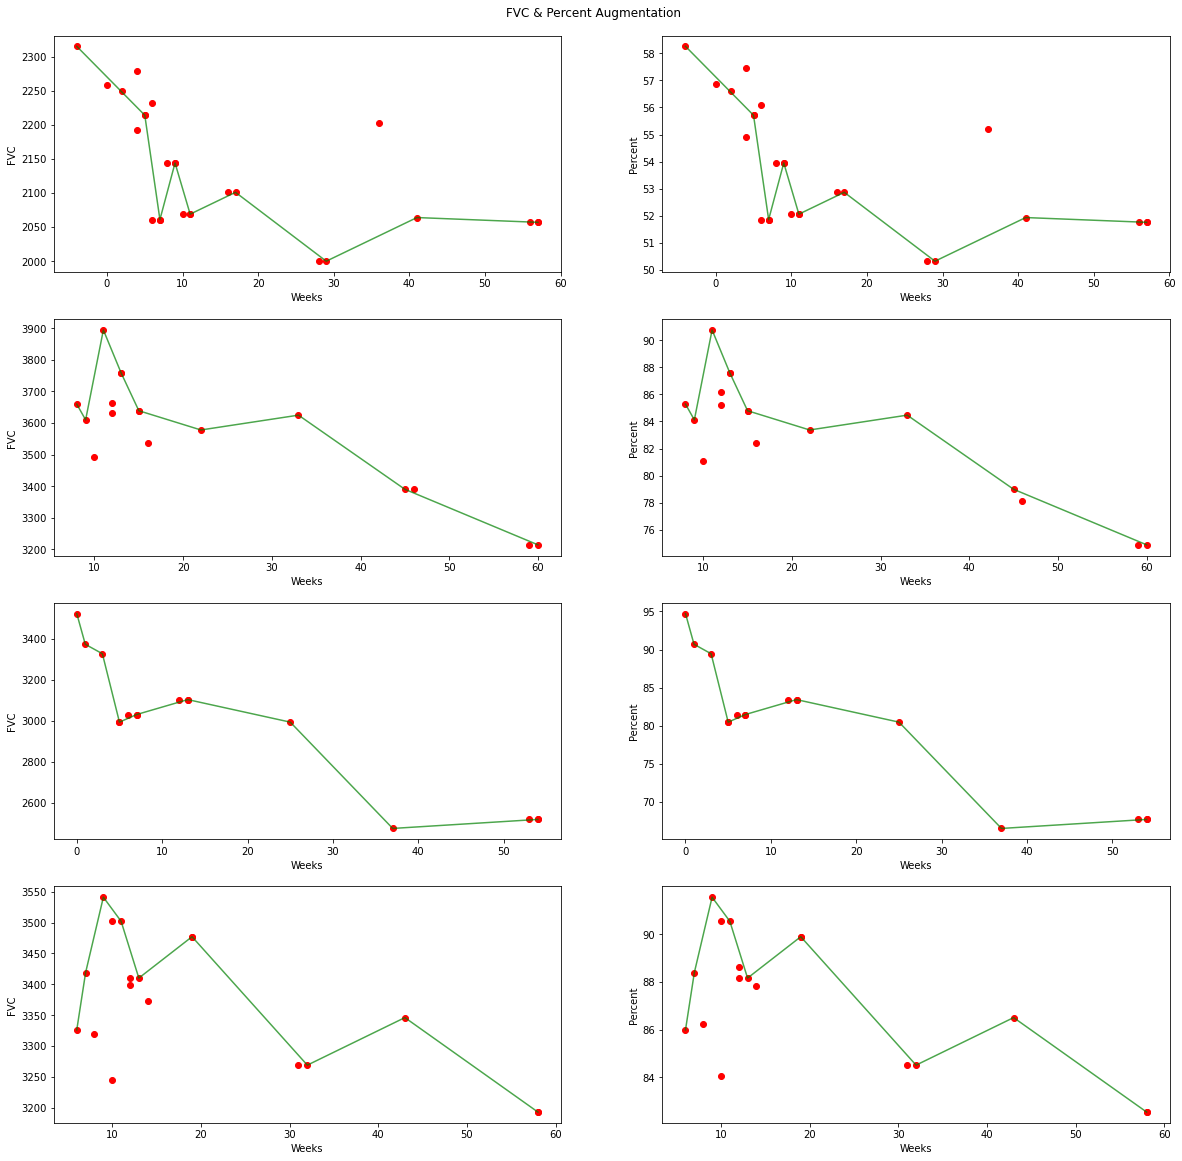

In [81]:
# default values for n_similar and threshold works fine
# higher threshold would cause a situation where there are 
# insufficent number of samples
temp = augment_train_cosine(train, n_similar=5, threshold=.5)
temp.head()

*The red dot denotes the augmented data while the green line dentores the original FVC progression.* With increasing thresholds the problem is that data points for a few weeks become large. We can tweak the `train_cols` in the function or add new attributes as a measure of patient similarity.

Another naive idea of augmenting the data would be interpolate with different methods, let's do that as well and compare the model that performs the best:

In [82]:
def augment_train_naive(
    data, steps=5, method='index', noise=.25, val_split=0.25, 
    end_pts=[None, None], display_sample=True):
    
    '''
    end_pts -> start and end of augmentation, if None defaults to min/max for that patient
    '''
    
    temp = data[['Patient','Weeks', 'FVC', 'Percent']].merge(
        
        ((data.groupby("Patient")['Weeks']
         .apply(lambda x: pd.Series(
             np.union1d(np.arange(
                 end_pts[0] if end_pts[0] else x.min(), 
                 end_pts[1] if end_pts[1] else x.max(), 
                 step=steps), x))
               ).reset_index(level=0))),

        on=['Patient', 'Weeks'], how='right')

    temp.loc[:, ['FVC', 'Percent']] = (
        temp.groupby("Patient")[['FVC', 'Percent']]
        .apply(lambda x: (
            # interpolate 
            x.interpolate(method=method, limit_direction='both') + 
            
            # noise factor: Gaussian noice + standard deviation of resp features
            # (we assume std of percent is scaled up version of std of FVC)
            (x.std().values * np.random.uniform(-noise, noise, [len(x), 1])))))

    temp = temp.merge(
        data.groupby("Patient")[['Patient', 'Age', 'Sex', 'SmokingStatus']].head(1),
        on='Patient')
    
    if display_sample:
        f, ax = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))

        for i, pat in enumerate(temp.Patient.unique()[:4]):

            ax[i][0].plot(*list(zip(*data[data.Patient == pat][['FVC', 'Weeks']].values))
                [::-1], c='g', alpha=0.7)
            
            ax[i][1].plot(*list(zip(*data[data.Patient == pat][['Percent', 'Weeks']].values))
                          [::-1], c='g', alpha=0.7)
            
            ax[i][0].scatter(*list(zip(*temp[temp.Patient == pat][['FVC', 'Weeks']].values))[::-1], c='r')
            
            ax[i][1].scatter(*list(zip(*temp[temp.Patient == pat][['Percent', 'Weeks']].values))[::-1], c='r')
            
            ax[i][0].set(xlabel='Weeks', ylabel='FVC')
            ax[i][1].set(xlabel='Weeks', ylabel='Percent')
            f.suptitle("FVC & Percent Augmentation", y=.9)
            
        print ("Data augmented by factor: {:.2f}x".format(1 + (
            temp.shape[0] - data.shape[0]) / data.shape[0]))
    
    return temp

How does this work?

Data augmented by factor: 1.30x


(2006, 7)

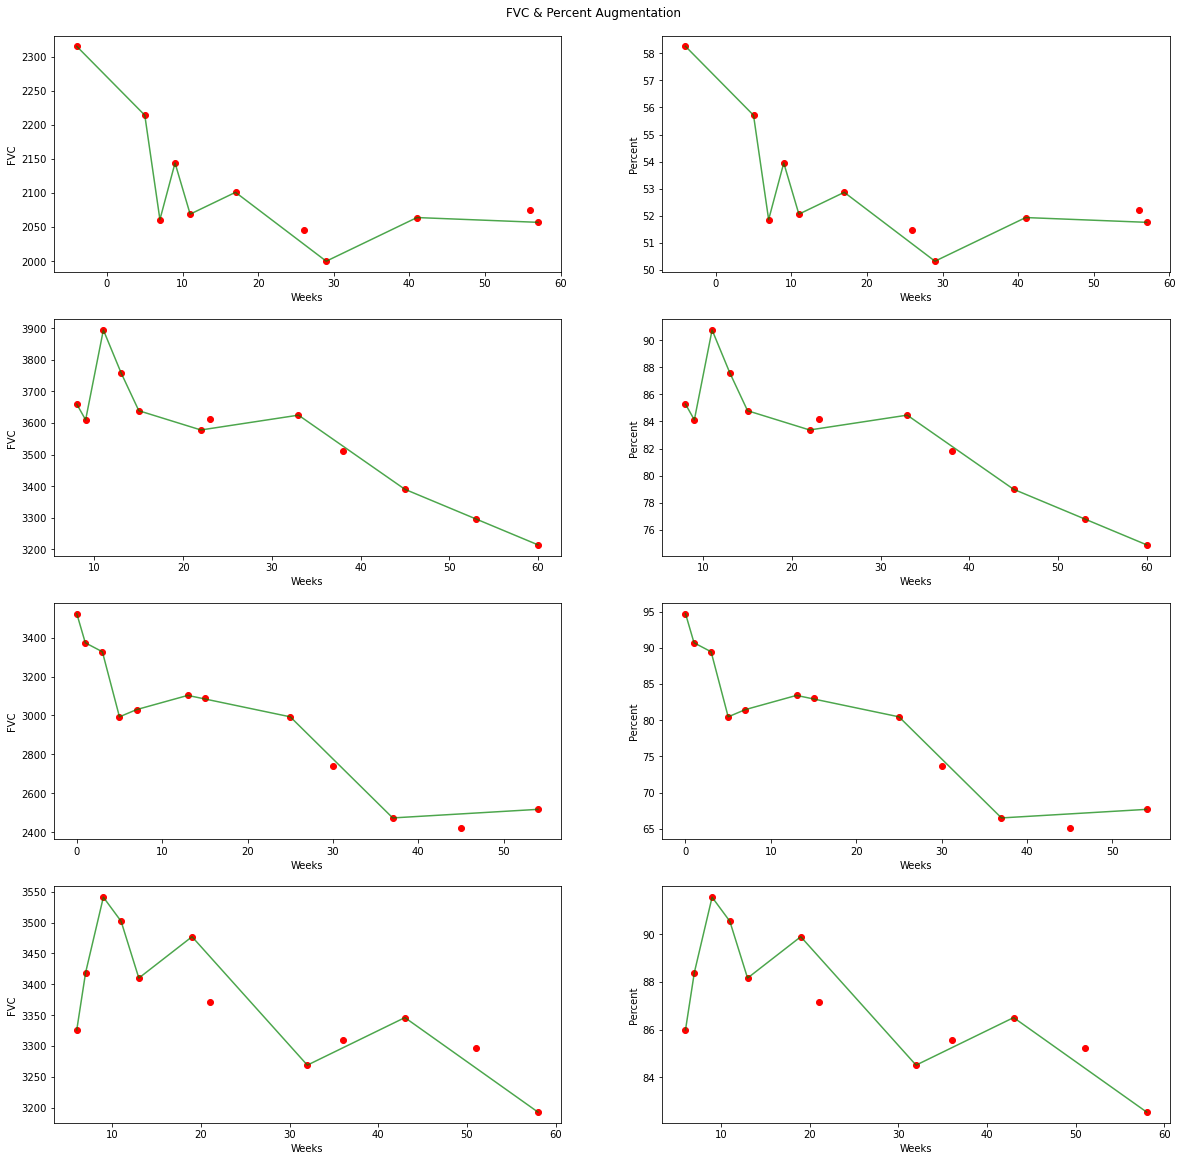

In [83]:
# Methods to try:
# 'piecewise_polynomial',, 
# 'pchip', 'akima', 'cubicspline', 'nearest', 
# 'zero', 'slinear', 'quadratic', 'cubic', 
# pad', 'linear'

# for large steps, nearest works best
# for smaller steps, Linear, Pad works best
# zero works best for both

temp = augment_train_naive(
    data=train, method='akima', steps=15, noise=0
)

temp.shape

Let's see which aug technique works best. As always we need to create multiple train/val splits to see which one truly works well:

In [84]:
cat_cols = ['Sex', 'SmokingStatus']
num_cols = ['Weeks', 'Week_Offset', 'Base_Week', 'Age', 'Base_FVC', 'Percent', 'Base_Percent']
to_drop = ["FVC", 'Percent', 'Weeks', 'Base_Week', 'Age', 'Base_Percent', 'factor']
math = []

multi_method = {}
multi_data = {}
folds = 7

methods = ['cubic', 'quadratic', 'cubicspline', 
           'pchip', 'akima', 'nearest', 'zero', 
           'slinear', 'linear', 'SIMILARITY_AUG']

# train patients for CV
total_patients = train.Patient.unique()
val_len = len(total_patients) // folds

for method in methods:
    
    # create the agumented dataset
    if method == 'SIMILARITY_AUG':
        temp = augment_train_cosine(train, n_similar=5, threshold=0.5, display_sample=False)
    else:
        temp = augment_train_naive(data=train, method=method, steps=15, noise=0.1, display_sample=False)
        
    # create multi base week data
    temp = multi_baseweek_frame(temp, display=False)
    # save the augmented dataframe
    multi_data[method] = temp
    
    # creating the data (processed for fitting)
    X, Y = get_model_data(temp, num_cols=num_cols, cat_cols=cat_cols, to_drop=to_drop, 
        display_stats=False, cat_method='1h', math=math, transform_stats=stats, factor=True)
        
    X_VAL = base_shift(train, q=0)
    Y_VAL = X_VAL['FVC'].dropna()
    X_VAL['Percent'] = X_VAL['Base_Percent']
    X_VAL = get_model_data(
        X_VAL, num_cols=num_cols, cat_cols=cat_cols, factor=True,
        to_drop=to_drop, train=False, cat_method='1h', math=math)
    
    # shuffle the patients for cv
    np.random.shuffle(total_patients)
    scores = {}
    
    for i in range(folds):
   
        val_patients = total_patients[(i)*val_len:(i+1)*val_len]
        train_patients = np.setdiff1d(total_patients, val_patients)

        x, y = X[X.Patient.isin(train_patients)], Y[X.Patient.isin(train_patients)]
        x_val, y_val = X_VAL[X_VAL.Patient.isin(val_patients)], Y_VAL[X_VAL.Patient.isin(val_patients)]
        
        assert len(np.intersect1d(x_val.Patient.unique(), x.Patient.unique())) == 0
        
       # how does it perform on train
        scores['Train'] = scores.get('Train', []) + [cross_val_score(
            LinearRegression(), x.drop("Patient", 1), y, 
            scoring=l1(70), cv=GroupKFold(5), groups=x.Patient).mean()]

        # performance on validation data
        lr = LinearRegression().fit(x.drop("Patient", 1), y)
        scores['Val'] = scores.get('Val', []) + [-laplace_log_likelihood(
            y_val, lr.predict(x_val.drop("Patient", 1)), sigma=70
        ).numpy()]
        
    print ("Method: {}\nTrain score: {:.2f} @ {:.2f} Variance \
    \nVal Score: {:6.2f} @ {:.2f} Variance\n{}\n".format(
        method.upper(), np.mean(scores['Train']), np.std(scores['Train']), np.mean(scores['Val']),
        np.std(scores['Val']), "=" * 35
    ))
    
    multi_method[method] = scores

Method: CUBIC
Train score: 7.72 @ 0.05 Variance     
Val Score:   7.59 @ 0.35 Variance

Method: QUADRATIC
Train score: 7.62 @ 0.05 Variance     
Val Score:   7.58 @ 0.33 Variance

Method: CUBICSPLINE
Train score: 7.71 @ 0.02 Variance     
Val Score:   7.58 @ 0.26 Variance

Method: PCHIP
Train score: 7.52 @ 0.07 Variance     
Val Score:   7.58 @ 0.48 Variance

Method: AKIMA
Train score: 7.54 @ 0.06 Variance     
Val Score:   7.58 @ 0.19 Variance

Method: NEAREST
Train score: 7.54 @ 0.04 Variance     
Val Score:   7.58 @ 0.51 Variance

Method: ZERO
Train score: 7.55 @ 0.07 Variance     
Val Score:   7.57 @ 0.30 Variance

Method: SLINEAR
Train score: 7.51 @ 0.05 Variance     
Val Score:   7.58 @ 0.32 Variance

Method: LINEAR
Train score: 7.52 @ 0.05 Variance     
Val Score:   7.58 @ 0.30 Variance

Method: SIMILARITY_AUG
Train score: 7.49 @ 0.07 Variance     
Val Score:   7.58 @ 0.29 Variance



We need a test score < 7.59 our previous benchmark. 

Almost all our models perform a little better than 7.59 score. We have saved the augmented dataframes. We are going to train models on all these augmented dataframe a aggregate their scores for submission. We can expect the following score on LB @ 70 confidence:

In [85]:
val_scores = [np.mean(multi_method[i]['Val']) for i in methods]
cut_off = np.percentile(val_scores, 25)

print("At {:.1f} cutoff, the score can be expected to be around: {:.3f}".format(
    cut_off, np.mean(list(filter(lambda x: x < cut_off, val_scores)))))

At 7.6 cutoff, the score can be expected to be around: 7.575


In [86]:
# creating x_test for predictions simaltanesly
x_test = sub[['Patient', 'Weeks']].merge(
    test.rename({"Weeks": "Base_Week", 
                 "FVC": "Base_FVC", 
                 "Percent": "Base_Percent"}, axis=1), 
    on='Patient')

# create week offsets
x_test['Week_Offset'] = x_test['Weeks'] - x_test['Base_Week']

# percent for test
x_test['Percent'] = x_test['Base_Percent']

# predictions dataframe
preds = pd.DataFrame(columns=methods)

# train each model on all the saved augmented frames
for method in methods:
    
    if np.mean(multi_method[method]['Val']) >= cut_off:
        preds = preds.drop(method, axis=1)
        continue
    
    x, y = get_model_data(
        multi_data[method], num_cols=num_cols, cat_cols=cat_cols,
        transform_stats=stats, to_drop=to_drop, train=True, cat_method='1h', 
        display_stats=False, factor=True,
    )

    lr = LinearRegression().fit(x.drop("Patient", 1), y) 

    preds[method] = lr.predict(get_model_data(
        x_test, cat_cols=cat_cols, num_cols=num_cols, to_drop=to_drop, train=False, factor=True,
    ).drop("Patient", 1))

preds.head()

nearest         zero  SIMILARITY_AUG
0  3079.59375  3079.489092     3088.720833
1  3075.96875  3075.864889     3084.712029
2  3072.34375  3072.240686     3080.703225
3  3068.71875  3068.616483     3076.694422
4  3065.09375  3064.992280     3072.685618

In [87]:
sub['FVC'] = preds.mean(axis=1)

# reduce the confidence to 250
sub['Confidence'] = 250 + preds.std(1)

# final touches before submission
for i in range(len(test)):
    sub.loc[sub['Patient_Week']==test.Patient[i]+'_'+str(test.Weeks[i]), 'FVC'] = test.FVC[i]
    sub.loc[sub['Patient_Week']==test.Patient[i]+'_'+str(test.Weeks[i]), 'Confidence'] = 70

# save to csv file
sub[['Patient_Week', 'FVC', 'Confidence']].to_csv("data_aug_submission.csv", index=False)

# how does it look?
sub.head()

Patient  Weeks   Sex SmokingStatus          FVC  \
0  ID00419637202311204720264    -12  Male     Ex-smoker  3082.601225   
1  ID00419637202311204720264    -11  Male     Ex-smoker  3078.848556   
2  ID00419637202311204720264    -10  Male     Ex-smoker  3075.095887   
3  ID00419637202311204720264     -9  Male     Ex-smoker  3071.343218   
4  ID00419637202311204720264     -8  Male     Ex-smoker  3067.590549   

   Confidence                   Patient_Week  
0  255.299994  ID00419637202311204720264_-12  
1  255.078182  ID00419637202311204720264_-11  
2  254.856371  ID00419637202311204720264_-10  
3  254.634560   ID00419637202311204720264_-9  
4  254.412751   ID00419637202311204720264_-8

Submission Scores:
- Public LB score: `-6.9089`
- Private LB score: `-6.8531`

Augmented data is better than score we had obtained by shifting. We say this since we have reduced confidence by 25 and predictions are similar to where we had predicted with 275 confidence.

Confidence values can make or break our model's performance. So let's shift strateges and see some ways how we can implement this feature along with predicting FVC. Some ideas are as follows:
1. Set confidence values as simply the variance of the the predicted FVC for that person
2. A secondary model that predicts the confidence scores for a given FVC prediction so as to maximize the metric
3. Custom training loop with a model predicting FVC and confidence. We use lll loss to train the model.

For our experimentations let us use new data:

In [88]:
op = multi_baseweek_frame(augment_train_cosine(train, display_sample=False), display=False)

# creating fresh data
x, y = get_model_data(
    op, num_cols=num_cols, cat_cols=cat_cols, to_drop=['FVC', 'Percent'], 
    display_stats=False, transform_stats=stats, math=math, factor=True)

x.shape, y.shape

((45692, 13), (45692,))

In [89]:
# Implementing Idea 1
from sklearn.model_selection import cross_val_predict

temp = pd.DataFrame(y)
temp['FVC_pred'] = cross_val_predict(
    LinearRegression(), x.drop(["Patient", 'Base_Percent'], 1), 
    y, cv=7, groups=x.Patient)

temp['Patient'] = x['Patient']
temp['Confidence'] = temp.groupby('Patient')['FVC_pred'].transform('std')
temp = temp.drop('Patient', axis=1)

print (laplace_log_likelihood(temp['FVC'], temp['FVC_pred'], sigma=temp['Confidence']).numpy())
temp.head()

-6.644658


FVC     FVC_pred  Confidence
0  2239.901316  2339.891205  102.534627
1  2230.754459  2332.966622  102.534627
2  2254.629894  2326.042039  102.534627
3  2214.000000  2322.579748  102.534627
4  2243.511537  2319.117456  102.534627

Although good, doesn't do all that great. So we are not going to make predictions with this. Let's move onto the next idea, i.e, we predict optimal confidence value for each data in train:

In [90]:
# Implementing Idea 2
temp['delta'] = np.minimum((temp['FVC'] - temp['FVC_pred']).abs(), 1000)

for sigma in range(70, 1000, 10):
    temp[f'score@{sigma}'] = - (temp['delta'] * np.sqrt(2) / sigma) - np.log(np.sqrt(2) * sigma)
    
cols = temp.iloc[:, 4:].columns

temp['Best_loc'] = temp.iloc[:, 4:].apply(lambda x: x.argmax(), axis=1).astype(int)
temp['Best_conf'] = temp['Best_loc'].apply(lambda x: cols[x][6:])
temp['Best_score'] = temp.apply(lambda x: x.iloc[x['Best_loc'] + 4], axis=1)
temp = temp.iloc[:, [0, 1, 3, 2, -1, -2]].reset_index(drop=True)

print ("Laplace Likelihood mean score: {:.3f}".format(temp['Best_score'].mean()))
temp.head()

Laplace Likelihood mean score: -6.274


FVC     FVC_pred       delta  Confidence  Best_score Best_conf
0  2239.901316  2339.891205   99.989889  102.534627   -6.298266       140
1  2230.754459  2332.966622  102.212163  102.534627   -6.320715       140
2  2254.629894  2326.042039   71.412145  102.534627   -5.961664       100
3  2214.000000  2322.579748  108.579748  102.534627   -6.380909       150
4  2243.511537  2319.117456   75.605919  102.534627   -6.019080       110

But can we predict this Best_conf ourselves using another model?

In [91]:
# how does it score? RMSE Score
- cross_val_score(
    LinearRegression(), 
    
    # only std as input feature, adding more features doesn't help much
    temp[['FVC_pred', 'Confidence']], 

    temp['Best_conf'].astype(int),
    scoring='neg_root_mean_squared_error', 
    cv=7
).mean()

160.8362442311351

In [92]:
# how much would it benefit our actual score?
- laplace_log_likelihood(
    temp['FVC'], temp['FVC_pred'],
    cross_val_predict(LinearRegression(), temp[['FVC_pred', 'Confidence']], temp['Best_conf'].astype(int))
).numpy()

6.5786824

In [93]:
# given the data frame with predictions and standard deviation,
# it outputs the confidence
conf_model = LinearRegression().fit(
    temp[['FVC_pred', 'Confidence']],
    temp[['Best_conf']],
)

In [94]:
# restoring previous model's predictions
sub['FVC'] = pd.read_csv("multi_baseweek.csv")['FVC']

# predict and make submission
sub[['Confidence']] = conf_model.predict(np.stack([
    sub['FVC'], sub.groupby("Patient")["FVC"].transform("std")], 
        axis=1))

# final touches before submission
for i in range(len(test)):
    sub.loc[sub['Patient_Week']==test.Patient[i]+'_'+str(test.Weeks[i]), 'FVC'] = test.FVC[i]
    sub.loc[sub['Patient_Week']==test.Patient[i]+'_'+str(test.Weeks[i]), 'Confidence'] = 70

sub[['Patient_Week', 'FVC', 'Confidence']].to_csv("data_aug_conf_sub.csv", index=False)
sub.head()

Patient  Weeks   Sex SmokingStatus          FVC  \
0  ID00419637202311204720264    -12  Male     Ex-smoker  3078.104859   
1  ID00419637202311204720264    -11  Male     Ex-smoker  3074.335632   
2  ID00419637202311204720264    -10  Male     Ex-smoker  3070.566405   
3  ID00419637202311204720264     -9  Male     Ex-smoker  3066.761464   
4  ID00419637202311204720264     -8  Male     Ex-smoker  3063.027951   

   Confidence                   Patient_Week  
0  237.924780  ID00419637202311204720264_-12  
1  237.943822  ID00419637202311204720264_-11  
2  237.962863  ID00419637202311204720264_-10  
3  237.982085   ID00419637202311204720264_-9  
4  238.000946   ID00419637202311204720264_-8

Submission Scores:
- Public LB score: `-6.9069`
- Private LB score: `-6.8532`

This is an improvement from our mutli-weekframe predictions where we used 200 confidence. There's high error in the optimal conf prediction, we could do better if can predict confidence with lesser error.

Now another question arises. Can we do better by simply assigning one conf value per patient?

In [95]:
grouped_scores = pd.DataFrame(columns=['Patient', 'Grp_conf'])

for i, (pat, group) in enumerate(temp.groupby(x.Patient.reset_index(drop=True))):
    best_param = [None, np.inf]
    for sigma in range(70, 1000, 10):
        curr_score = - laplace_log_likelihood(group['FVC'], group['FVC_pred'], sigma=sigma)
        if curr_score < best_param[1]:
            best_param = sigma, curr_score
    else:
        grouped_scores.loc[i] = pat, best_param[0]
    
temp = (
    temp.merge(x.Patient.reset_index(drop=True), left_index=True, right_index=True)
    .merge(grouped_scores, on=['Patient']).drop('Patient', 1)
)

# how much would ideally gruped confidence score?
laplace_log_likelihood(temp['FVC'], temp['FVC_pred'], temp['Grp_conf'].astype(float)).numpy()

-6.568308

This doesn't perform all that well (optimal CV score is equal to ones we got using a LR in the previous idea), so we drop this one,

Let's now implement the last idea: *Predicting Confidence and FVC in one go.*:

One way to do that would be to use the [quantile regression](https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_quantile.html) concept where we predict the quuantile intervals and subtract their difference as the confidence score. We are going to use GradientBoostingRegressor for this purpose:

`Note`: GBR by itself didn't prove very helpful. Almost all tree based models performed so poorly. Here are the tricks to make it work:
1. Choose as max tree depth as possible.
2. Choose a LR init for the model (Highly imp)
3. Smaller n_estimators also proved to help CV.

There are plenty of parameters for `GradientBoostingRegressor`. Therefore to derive on the best set of parameters, we are going to do a gridSearch using the multi_baseweek_frame we had already created, leaving those we know definitely works.

In [96]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV

# preprocessing pipe essentials
cat_cols = ['Sex', 'SmokingStatus']
to_drop = ['FVC', 'Base_Percent', 'Percent']
num_cols = ['Weeks', 'Week_Offset', 'Base_Week', 'Age', 'Base_FVC', 'Percent', 'Base_Percent']
cat_method = 'ord'
math = []
age_bins = 5

grid_params = {
    'learning_rate': [5, 1, 0.1, 0.5, 0.075],
    'subsample': [0.25, 0.5, 0.75, 1.0],
    'min_samples_split': [2, 0.1, 0.25, 0.5, 0.75, 1.0],
    'min_samples_leaf': [1, 0.1, 0.25, 0.5, 0.75, 1.0],
    'min_impurity_decrease': [0.0, 0.1, 0.2],
    'max_features': ['auto', 'sqrt', 'log2'],
    'ccp_alpha': [0.0, 0.25, 0.5, 0.75],
}

grid = RandomizedSearchCV(
    
    GradientBoostingRegressor(
        random_state=0, loss='lad', 
        n_estimators=50, max_depth=2,
        criterion='friedman_mse',
        init=LinearRegression()),
    
    param_distributions=grid_params, verbose=1,
    scoring='neg_root_mean_squared_error', n_iter=300,
    n_jobs=-1, cv=GroupKFold(n_splits=3), random_state=0)

x, y = get_model_data(
    op, num_cols=num_cols, cat_cols=cat_cols, age_bins=age_bins, math=math,
    to_drop=to_drop, display_stats=False, cat_method=cat_method, transform_stats=stats
)

grid.fit(x.drop("Patient", 1), y, groups=op.Patient)
print ("Best Score:", - grid.best_score_)

grid.best_params_

Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 482 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 840 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  3.1min finished


Best Score: 202.77607545377387


{'subsample': 1.0,
 'min_samples_split': 0.5,
 'min_samples_leaf': 0.25,
 'min_impurity_decrease': 0.0,
 'max_features': 'auto',
 'learning_rate': 0.1,
 'ccp_alpha': 0.0}

Using the above configuration, lets fit and test on the validation data to see how our model would perform.

In [97]:
# preprocessing pipe essentials
cat_cols = ['Sex', 'SmokingStatus']
to_drop = ['FVC', 'Base_Percent', 'Percent']
num_cols = ['Weeks', 'Week_Offset', 'Base_Week', 'Age', 'Base_FVC', 'Percent', 'Base_Percent']
cat_method = 'ord'
math = []
age_bins = 5

# cross validation 
folds = 7
total_patients = train.Patient.unique()
np.random.shuffle(total_patients)
val_len = len(total_patients) // folds

# data frame to hold the predictions on train & test data
temp = pd.DataFrame()
preds = pd.DataFrame()

# creating data suitable for model fitting and predictions
X, Y = get_model_data(
    op, 
#     base_shift(augment_train_cosine(train, display_sample=False), q=0),
#     base_shift(train, q=25),

    num_cols=num_cols, cat_cols=cat_cols, age_bins=age_bins, to_drop=to_drop, 
    display_stats=False, cat_method=cat_method, transform_stats=stats, math=math)

X_VAL = base_shift(train, q=0)
Y_VAL = X_VAL['FVC'].dropna()

# percent value as the base percent
X_VAL['Percent'] = X_VAL['Base_Percent']

X_VAL = get_model_data(
    X_VAL, num_cols=num_cols, cat_cols=cat_cols, to_drop=to_drop, 
    cat_method=cat_method, train=False, age_bins=age_bins, math=math)

# creating x_test for predictions simaltanesly
x_test = sub[['Patient', 'Weeks']].merge(
    test.rename({"Weeks": "Base_Week", 
                 "FVC": "Base_FVC", 
                 "Percent": "Base_Percent"}, axis=1), 
    on='Patient')

# create week offsets
x_test['Week_Offset'] = x_test['Weeks'] - x_test['Base_Week']

# percent value as the base percent
x_test['Percent'] = x_test['Base_Percent']

x_test = get_model_data(
    x_test, cat_cols=cat_cols, num_cols=num_cols, to_drop=to_drop, math=math,
    train=False, cat_method=cat_method, age_bins=age_bins).drop("Patient", 1)

for i in range(folds):
   
    val_patients = total_patients[(i)*val_len:(i+1)*val_len]
    train_patients = np.setdiff1d(total_patients, val_patients)
    
    assert len(np.intersect1d(val_patients, train_patients)) == 0
    
    x, y, = (X[X.Patient.isin(train_patients)].drop("Patient", 1), Y[X.Patient.isin(train_patients)])
    x_val, y_val = (X_VAL[X_VAL.Patient.isin(val_patients)].drop("Patient", 1), 
                    Y_VAL[X_VAL.Patient.isin(val_patients)])
        
    # creating base model, no parameter tweakingparam_distributions
    model = GradientBoostingRegressor(
        n_estimators=50, max_depth=2,
        random_state=0,
        init=LinearRegression(),
        criterion='friedman_mse', 
        **grid.best_params_)
    
    alpha = 0.75

    model.set_params(loss='quantile', alpha=alpha)
    model.fit(x.drop(["Weeks", 'Base_Week'], 1), y)
    y_upper = model.predict(x_val.drop(["Weeks", 'Base_Week'], 1))
    y_upper_pred = model.predict(x_test.drop(["Weeks", 'Base_Week'], 1))

    model.set_params(loss='quantile', alpha=1-alpha)
    model.fit(x.drop(["Weeks", 'Base_Week'], 1), y)
    y_lower = model.predict(x_val.drop(["Weeks", 'Base_Week'], 1))
    y_lower_pred = model.predict(x_test.drop(["Weeks", 'Base_Week'], 1))

    model.set_params(loss='lad')
    model.fit(x, y)
    y_middle = model.predict(x_val)
    y_middle_pred = model.predict(x_test)
    
    print ("For Fold #{} Val Score: {:.2f} @ 70 Confidence | {:.2f} @ Pred Confidence".format(
        i+1, - laplace_log_likelihood(y_middle, y_val), 
        - laplace_log_likelihood(y_middle, y_val, y_upper - y_lower)))
    
    temp = temp.append(pd.DataFrame(
        data=np.stack([y_upper, y_lower, y_middle, y_val], axis=1),
        columns=['upper', 'lower', 'pred', 'actual']
    ))
    
    preds = preds.append(pd.DataFrame(
        data=np.stack([y_upper_pred, y_lower_pred, y_middle_pred], axis=1) / folds,
        columns=['upper', 'lower', 'pred']
    ))
    
preds = preds.groupby(preds.index).sum()
preds['Confidence'] = preds['upper'] - preds['lower']

temp['Confidence'] = temp['upper'] - temp['lower']

For Fold #1 Val Score: 7.87 @ 70 Confidence | 6.75 @ Pred Confidence
For Fold #2 Val Score: 6.97 @ 70 Confidence | 6.44 @ Pred Confidence
For Fold #3 Val Score: 7.54 @ 70 Confidence | 6.66 @ Pred Confidence
For Fold #4 Val Score: 7.81 @ 70 Confidence | 6.72 @ Pred Confidence
For Fold #5 Val Score: 7.77 @ 70 Confidence | 6.74 @ Pred Confidence
For Fold #6 Val Score: 7.59 @ 70 Confidence | 6.66 @ Pred Confidence
For Fold #7 Val Score: 7.28 @ 70 Confidence | 6.53 @ Pred Confidence



|================== Summary ==================|
Score on Total Dataset: 7.548 @   70 Confidence
Score on Total Dataset: 6.681 @  225 Confidence
Score on Total Dataset: 6.645 @ Pred Confidence


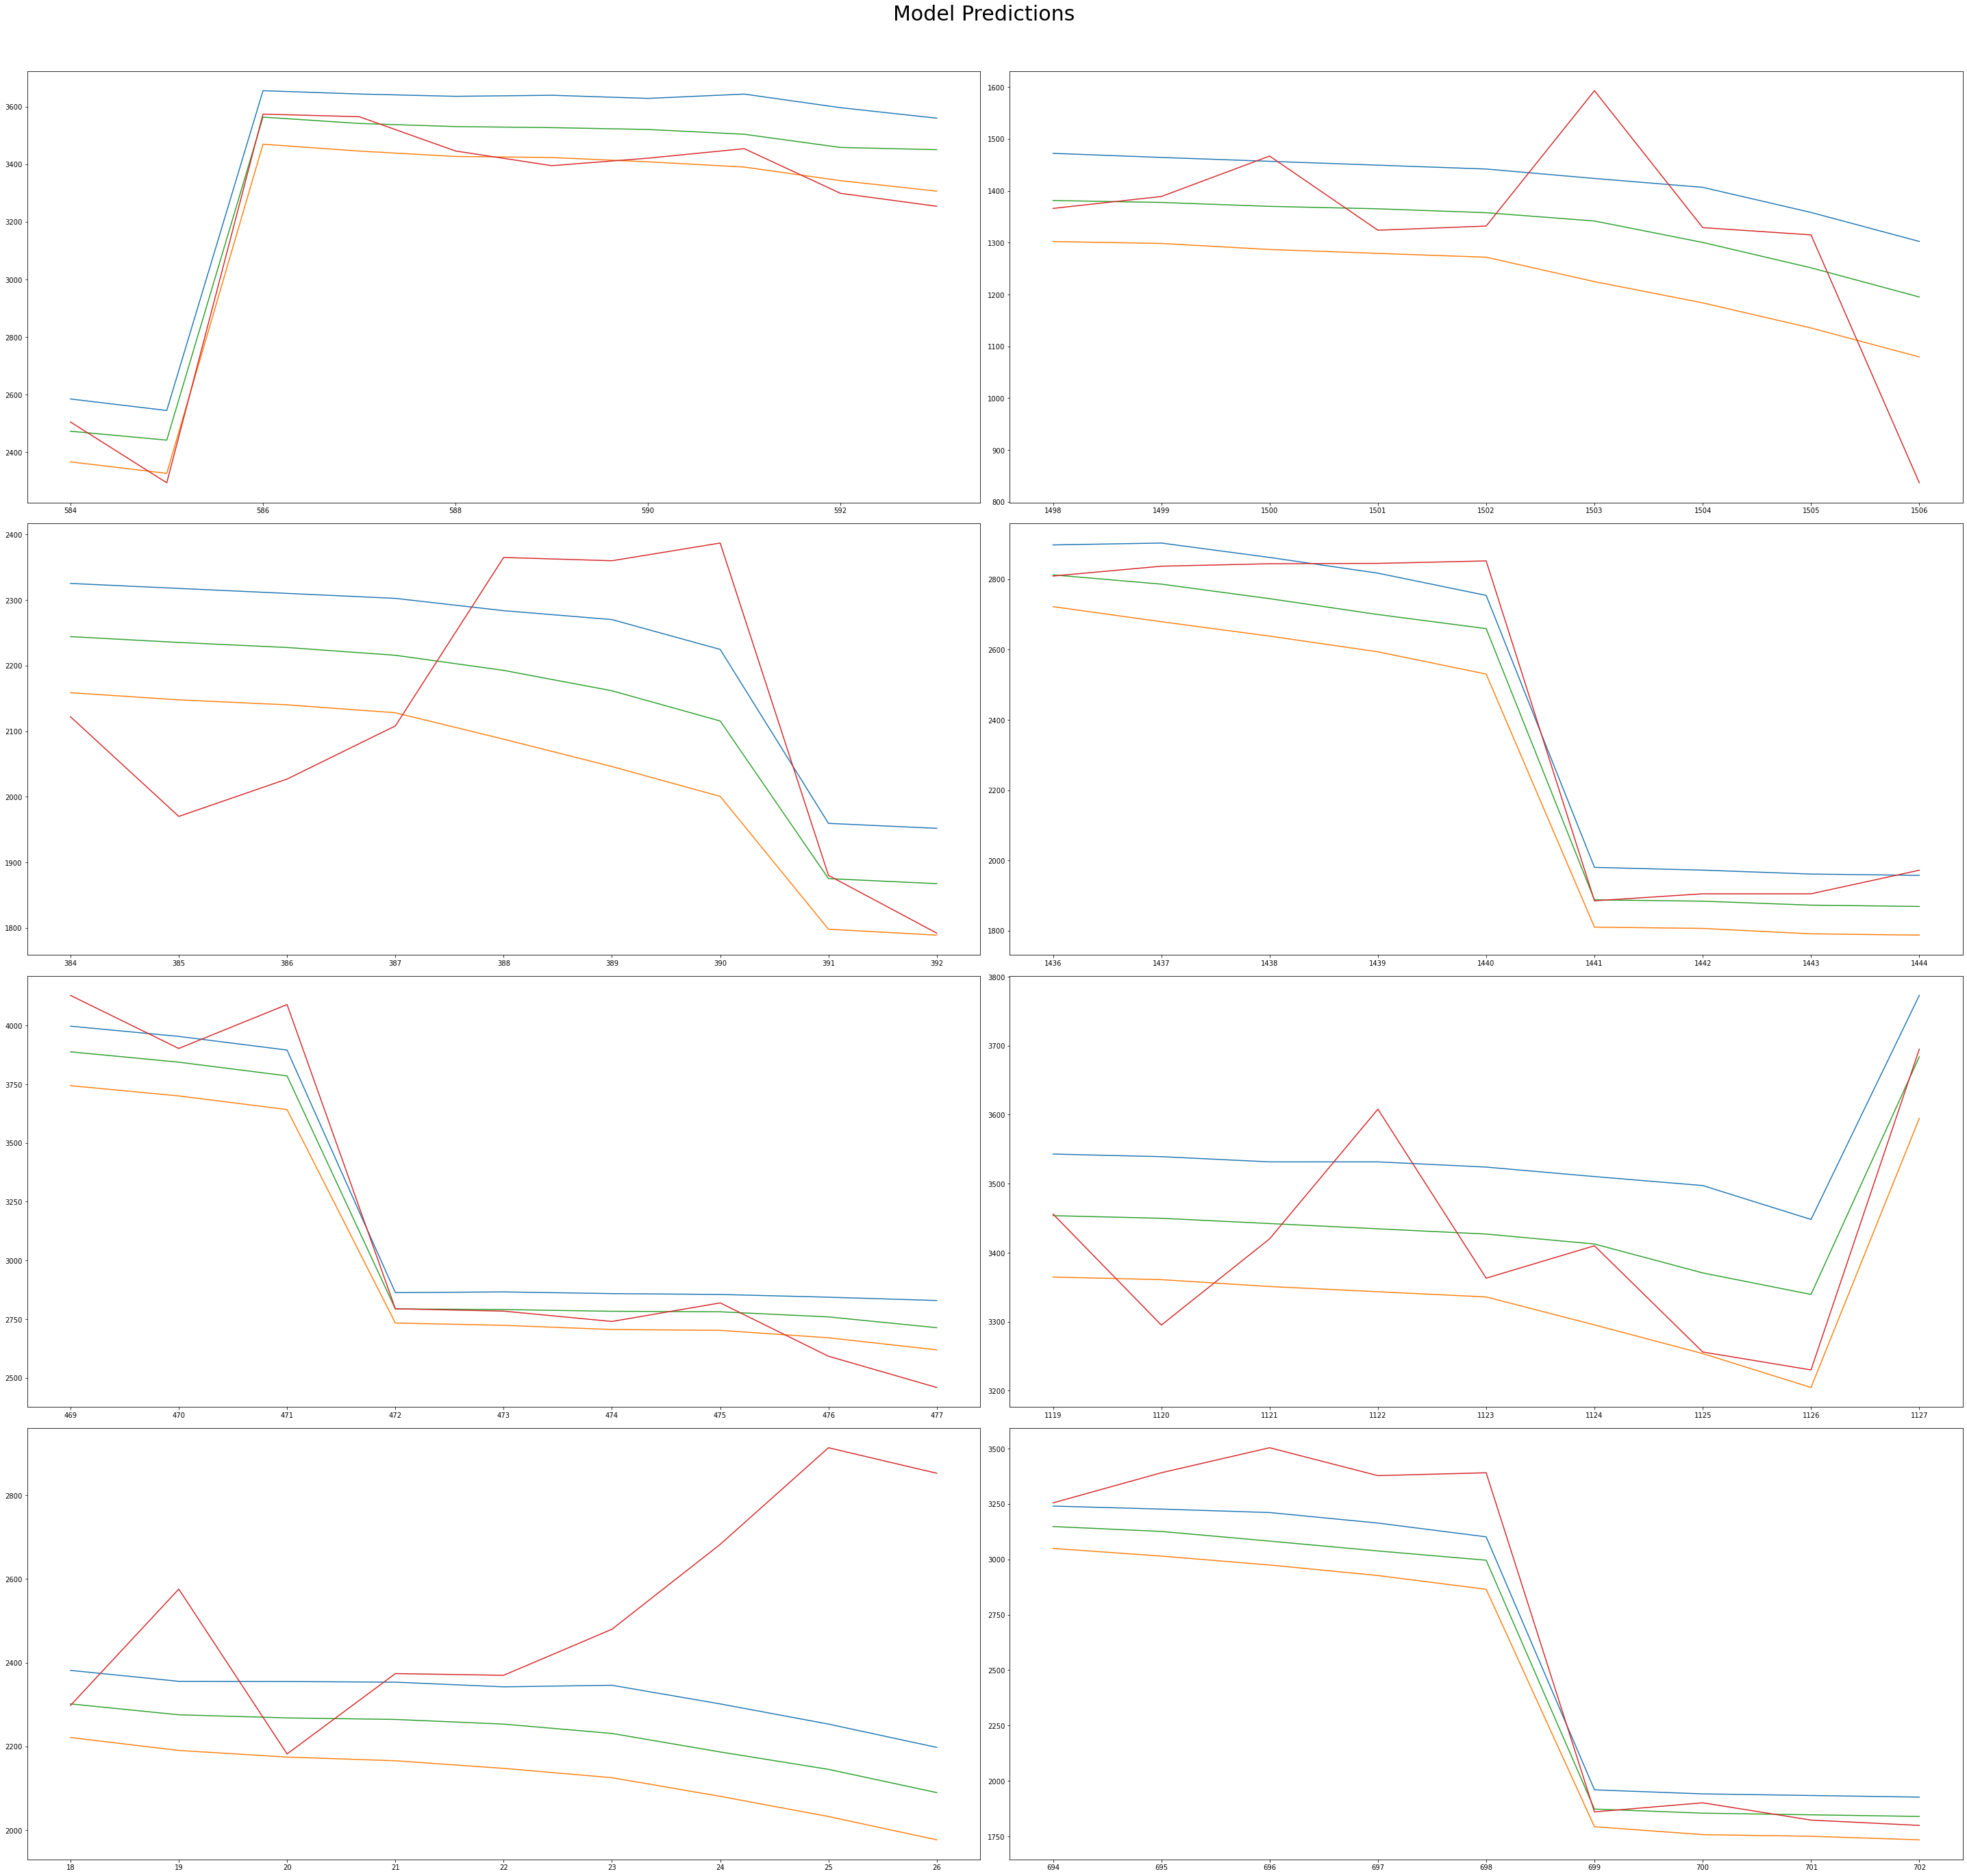

In [98]:
print ("\n|================== Summary ==================|\n\
Score on Total Dataset: {:.3f} @   70 Confidence\n\
Score on Total Dataset: {:.3f} @  225 Confidence\n\
Score on Total Dataset: {:.3f} @ Pred Confidence".format(
    -laplace_log_likelihood(temp['actual'], temp['pred'], 70),
    -laplace_log_likelihood(temp['actual'], temp['pred'], 225),
    -laplace_log_likelihood(temp['actual'], temp['pred'], temp['Confidence'])
))

f, ax = plt.subplots(figsize=(40, 40), nrows=4, ncols=2)
ax = ax.ravel()
for i, pat in enumerate(np.random.choice(train.Patient.unique(), size=8, replace=False)):
    (temp.reset_index(drop=True).loc[train.Patient == pat]
     .drop(["Confidence"], 1).plot(ax=ax[i], legend=False))
f.suptitle("Model Predictions", size=30)
f.tight_layout(rect=[0, 0.03, 1, 0.95]);

In [99]:
sub['FVC'] = preds['pred']
sub['Confidence'] = preds['Confidence']

# final touches before submission
for i in range(len(test)):
    sub.loc[sub['Patient_Week']==test.Patient[i]+'_'+str(test.Weeks[i]), 'FVC'] = test.FVC[i]
    sub.loc[sub['Patient_Week']==test.Patient[i]+'_'+str(test.Weeks[i]), 'Confidence'] = 70

sub[['Patient_Week', 'FVC', 'Confidence']].to_csv("quant_submission.csv", index=False)
sub.head()

Patient  Weeks   Sex SmokingStatus          FVC  \
0  ID00419637202311204720264    -12  Male     Ex-smoker  3073.767676   
1  ID00419637202311204720264    -11  Male     Ex-smoker  3070.054506   
2  ID00419637202311204720264    -10  Male     Ex-smoker  3066.367006   
3  ID00419637202311204720264     -9  Male     Ex-smoker  3062.666114   
4  ID00419637202311204720264     -8  Male     Ex-smoker  3058.941783   

   Confidence                   Patient_Week  
0  225.547417  ID00419637202311204720264_-12  
1  225.547417  ID00419637202311204720264_-11  
2  225.547417  ID00419637202311204720264_-10  
3  225.547417   ID00419637202311204720264_-9  
4  199.125283   ID00419637202311204720264_-8

Submission Scores:
- Public LB score: `-6.9317`
- Private LB score: `-6.8600`

Maybe this might work better, if we could really simaltaneously predict confidences instead of doing it seperately. The problem with our linear approaches, in the submission only three weeks are required out of all the 146 weeks of submission. If we are to predict all 146 weeks as close as possible, we might do well with our linear models. Since we are required to predict just 3 of actual submissions (the rest are dropped) we donot have much wiggle space. To get an actual idea, try validating on as little data as possible.

#### Let's combine the two best performing ideas: Data aug + GBR and see how it scores:

This is the work that you see in my [inference notebook](https://www.kaggle.com/doctorkael/osic-inference) I submitted for this competition. To be able to make predictions on FVC and forecast in one go, we conveniently wrap them up in our custom SciKit Learn class. Methods on how to do this can be found [here](https://scikit-learn.org/stable/developers/develop.html).

In [100]:
from sklearn.base import RegressorMixin, BaseEstimator
class GBR(RegressorMixin, BaseEstimator):
    
    '''
    Custom Sckit Learn estimator for making Predictions on FVC and Conf in one go.
    
    alpha  -> Quantiles for making predictions
    umodel -> Makes upper bound preds
    mmodel -> Makes Middle preds (We optimize this during Grid search)
    lmodel -> Makes lower bound preds
    
    It could be improved by making alpha tunable in grid search. I don't know how 
    this could be done, since cross_val_score accepts only a single pred as op. 
    Maybe we could create a custom scoring function to do this. Let me know if you do ^.^
    '''
    
    def __init__(self, alpha=.75, **params):
        self.alpha = alpha
        self.umodel = self._create_model(loss='quantile', q=self.alpha, **params)
        self.mmodel = self._create_model(loss='lad', **params)
        self.lmodel = self._create_model(loss='quantile', q=1-self.alpha, **params)
              
    def _create_model(self, loss, q=.75, **params):
        model = GradientBoostingRegressor(
            init=LinearRegression(),
            criterion='friedman_mse',
            n_estimators=50, max_depth=2, 
            loss=loss, alpha=q, **params)
        
        return model
        
    def fit(self, x, y):
        '''We fit the same data with all three models.'''
        
        self.umodel.fit(x, y)
        self.mmodel.fit(x, y)
        self.lmodel.fit(x, y)
        return self
    
    def predict(self, X):
        '''This function is merely for compatibilty & for providing utility for
        fine tuning, cross_val_score and as such.'''
        
        return self.mmodel.predict(X)
    
    def predict_forecast(self, X, return_bounds=False):
        '''
        This function make predictions using all three models conveniently wrapped 
        up in one single function. It can be made to produce the bounds or simply the confidence.
        '''
        
        preds = self.mmodel.predict(X)
        upper = self.umodel.predict(X)
        lower = self.lmodel.predict(X)
        
        if return_bounds:
            return preds, upper, lower
        else:
            return preds, (upper - lower)

Our model is ready. Let's create now cross_val this model on all augmented data to see which aug data performs with least error. The code below may take some time to run:

In [101]:
cat_cols = ['Sex', 'SmokingStatus']
num_cols = ['Weeks', 'Week_Offset', 'Base_Week', 'Age', 'Base_FVC', 'Percent', 'Base_Percent']
to_drop = ["FVC", 'Percent', 'Weeks', 'Base_Week', 'Age', 'Base_Percent', 'factor']
math = []

multi_method = {}
multi_data = {}
folds = 7

methods = ['cubic', 'quadratic', 'cubicspline', 
           'pchip', 'akima', 'nearest', 'zero', 
           'slinear', 'linear', 'SIMILARITY_AUG']

# train patients for CV
total_patients = train.Patient.unique()
val_len = len(total_patients) // folds

for method in methods:
    
    # create the agumented dataset
    if method == 'SIMILARITY_AUG':
        temp = augment_train_cosine(train, n_similar=3, threshold=0.25, display_sample=False)
    else:
        temp = augment_train_naive(data=train, method=method, steps=15, noise=0., display_sample=False)
        
    # create multi base week data
    temp = multi_baseweek_frame(temp, display=False)
    # save the augmented dataframe
    multi_data[method] = temp
    
    # creating the data (processed for fitting)
    X, Y = get_model_data(temp, num_cols=num_cols, cat_cols=cat_cols, to_drop=to_drop, 
        display_stats=False, cat_method='1h', math=math, factor=True)
        
    X_VAL = base_shift(train, q=0)
    Y_VAL = X_VAL['FVC'].dropna()
    X_VAL['Percent'] = X_VAL['Base_Percent']
    X_VAL = get_model_data(
        X_VAL, num_cols=num_cols, cat_cols=cat_cols, factor=True,
        to_drop=to_drop, train=False, cat_method='1h', math=math)
    
    # shuffle the patients for cv
    np.random.shuffle(total_patients)
    scores = {}
    
    for i in range(folds):
   
        val_patients = total_patients[(i)*val_len:(i+1)*val_len]
        train_patients = np.setdiff1d(total_patients, val_patients)

        x, y = X[X.Patient.isin(train_patients)], Y[X.Patient.isin(train_patients)]
        x_val, y_val = X_VAL[X_VAL.Patient.isin(val_patients)], Y_VAL[X_VAL.Patient.isin(val_patients)]
        
        assert len(np.intersect1d(x_val.Patient.unique(), x.Patient.unique())) == 0
        
       # how does it perform on train
        scores['Train'] = scores.get('Train', []) + [cross_val_score(
            GBR(), x.drop("Patient", 1), y, 
            scoring=l1(70), cv=GroupKFold(5), groups=x.Patient).mean()]

        # fit to measure model's performance
        lr = GBR().fit(x.drop("Patient", 1), y) 
        temp = lr.predict_forecast(x_val.drop("Patient", 1))
        temp = pd.DataFrame(np.stack(temp, 1), columns=['pred', 'conf'])
        temp['actual'] = y_val.reset_index(drop=True)
        
        # performance on validation data
        scores['Val'] = scores.get('Val', []) + [-laplace_log_likelihood(
            temp['actual'], temp['pred'], 70
        ).numpy()]
        
        # performance with confidence        
        scores['ValC'] = scores.get('ValC', []) + [-laplace_log_likelihood(
            temp['actual'], temp['pred'], temp['conf']
        ).numpy()]
        
        # Worst Performing mean scores
        scores['ValW'] = scores.get('ValW', []) + [temp.apply(lambda x: -laplace_log_likelihood(
            x['actual'], x['pred'], x['conf']).numpy(), 1).nlargest(25).mean()]
        
    print ("Method: {}\nTrain score: {:5.2f} @ {:.2f} Variance \
    \nVal Score: {:7.2f} @ {:.2f} Variance\
    \nValC Score: {:6.2f} @ {:.2f} Variance\
    \nWorst Score: {:5.2f} @ {:.2f} Variance\n{}\n".format(
        method.upper(), np.mean(scores['Train']), np.std(scores['Train']), 
        np.mean(scores['Val']), np.std(scores['Val']), np.mean(scores['ValC']), 
        np.std(scores['ValC']), np.mean(scores['ValW']), np.std(scores['ValW']), "=" * 35
    ))
    
    multi_method[method] = scores

Method: CUBIC
Train score:  7.70 @ 0.04 Variance     
Val Score:    7.51 @ 0.19 Variance    
ValC Score:   6.63 @ 0.07 Variance    
Worst Score:  8.93 @ 0.31 Variance

Method: QUADRATIC
Train score:  7.61 @ 0.01 Variance     
Val Score:    7.51 @ 0.28 Variance    
ValC Score:   6.63 @ 0.10 Variance    
Worst Score:  9.04 @ 0.41 Variance

Method: CUBICSPLINE
Train score:  7.70 @ 0.05 Variance     
Val Score:    7.53 @ 0.25 Variance    
ValC Score:   6.64 @ 0.07 Variance    
Worst Score:  8.94 @ 0.37 Variance

Method: PCHIP
Train score:  7.52 @ 0.04 Variance     
Val Score:    7.53 @ 0.26 Variance    
ValC Score:   6.65 @ 0.09 Variance    
Worst Score:  9.17 @ 0.33 Variance

Method: AKIMA
Train score:  7.54 @ 0.05 Variance     
Val Score:    7.51 @ 0.31 Variance    
ValC Score:   6.63 @ 0.12 Variance    
Worst Score:  9.02 @ 0.60 Variance

Method: NEAREST
Train score:  7.54 @ 0.05 Variance     
Val Score:    7.50 @ 0.41 Variance    
ValC Score:   6.63 @ 0.15 Variance    
Worst Score:  9.

We aim to find those augmented data which yeilds the lowest possible error in validation data. Previously we aimed to increase the score, now we aim to decrease the worst. We also increase the threshold than before and retain 50% of top performing data.

*The rationale for this decision is that in the end, out of all our predictions, only three week FVC are computed for the score.*

In [102]:
val_scores = [np.mean(multi_method[i]['ValW']) for i in methods]
cut_off = np.percentile(val_scores, 50)
        
print("At {:.1f} cutoff, the Worst Score would be {:.3f} @ Pred Conf".format(
    cut_off, np.mean(list(filter(lambda x: x < cut_off, val_scores)))))

At 9.1 cutoff, the Worst Score would be 8.999 @ Pred Conf


In [103]:
# creating x_test for predictions simaltanesly
x_test = sub[['Patient', 'Weeks']].merge(
    test.rename({"Weeks": "Base_Week", 
                 "FVC": "Base_FVC", 
                 "Percent": "Base_Percent"}, axis=1), 
    on='Patient')

# create week offsets
x_test['Week_Offset'] = x_test['Weeks'] - x_test['Base_Week']

# percent for test
x_test['Percent'] = x_test['Base_Percent']

# predictions dataframe
preds = {i: None for i in methods}

# train each model on all the saved augmented frames
for method in methods:
    
    if np.mean(multi_method[method]['ValW']) >= cut_off:
        preds.pop(method)
        continue
    
    x, y = get_model_data(
        multi_data[method], num_cols=num_cols, cat_cols=cat_cols, 
        to_drop=to_drop, train=True, cat_method='1h', 
        display_stats=False, factor=True,
    )

    lr = GBR().fit(x.drop("Patient", 1), y) 

    preds[method] = lr.predict_forecast(get_model_data(
        x_test, cat_cols=cat_cols, num_cols=num_cols, to_drop=to_drop, train=False, factor=True,
    ).drop("Patient", 1), return_bounds=True)

preds.keys()

dict_keys(['cubic', 'quadratic', 'cubicspline', 'akima', 'SIMILARITY_AUG'])

In [104]:
temp = {}
for i in multi_method:
    if i in preds.keys():
        temp['Val'] = temp.get('Val', []) + [np.mean(multi_method[i]['Val'])]
        temp['ValC'] = temp.get('ValC', []) + [np.mean(multi_method[i]['ValC'])]
        
print ("At same cutoff:\n\nBest val score: {:6.3f} @   70 Conf\n\
Best Val score: {:6.3f} @ Pred Conf".format(np.mean(temp['Val']), np.mean(temp['ValC'])))

At same cutoff:

Best val score:  7.518 @   70 Conf
Best Val score:  6.637 @ Pred Conf


##### A note on what is done in snippet below: 

We produce the bounds (lower and upper) using models trained on all the augmented data. For each week, we take the minimum (for lower bound) and maximum (for upper bound) to arrive at the actual confidence in that particular predictions.

In [105]:
mean = np.mean(np.stack(pd.DataFrame(preds).iloc[0].values), 0)
upper = np.max(np.stack(pd.DataFrame(preds).iloc[1].values), 0)
lower = np.min(np.stack(pd.DataFrame(preds).iloc[2].values), 0)

sub['FVC'] = mean
sub['Confidence'] = upper - lower

# save to csv file
sub[['Patient_Week', 'FVC', 'Confidence']].to_csv("submission.csv", index=False)

sub.head()

Patient  Weeks   Sex SmokingStatus          FVC  \
0  ID00419637202311204720264    -12  Male     Ex-smoker  3073.096214   
1  ID00419637202311204720264    -11  Male     Ex-smoker  3069.240794   
2  ID00419637202311204720264    -10  Male     Ex-smoker  3066.674277   
3  ID00419637202311204720264     -9  Male     Ex-smoker  3062.818906   
4  ID00419637202311204720264     -8  Male     Ex-smoker  3058.963535   

   Confidence                   Patient_Week  
0  212.208696  ID00419637202311204720264_-12  
1  212.208696  ID00419637202311204720264_-11  
2  212.208696  ID00419637202311204720264_-10  
3  210.434792   ID00419637202311204720264_-9  
4  208.112678   ID00419637202311204720264_-8

Submission Scores:
- Public LB score: `-6.8897`
- Private LB score: `-6.8479`

*This was the submission file that I submitted*

### Some more experiments:

*My experiments after this point weren't implemented or tested by making submissions. It might have performed better or could have performed worse. But I document them here neverthless.*

*Some were used in creating features such as `factor`. Some were used in creating the cosine augmented data. Most were unimplemented ideas. :(*

The next idea is to use the images of scans to learn the slope before hand & try to predict the FVC. Let's get started:

In [106]:
temp = train.copy() 
temp['present_minus_past'] = temp.groupby("Patient")['FVC'].transform('diff').fillna(0)
temp['Week_diff'] = temp.groupby("Patient")['Weeks'].transform('diff').fillna(0)
temp['pms'] = (temp['present_minus_past'] / temp['Week_diff']).replace([np.inf, -np.inf]).fillna(0)

# features we are trying to predict from the image
temp['min_pms'] = temp.groupby("Patient")['pms'].transform('min')
temp['avg_pms'] = temp.groupby("Patient")['pms'].transform('mean')
temp['max_pms'] = temp.groupby("Patient")['pms'].transform('max') 

# # these features can be engineered
temp['cum_pms'] = (temp['avg_pms'] * temp['Week_diff']).groupby(temp.Patient).transform('cumsum')
temp['cum_min_pms'] = (temp['min_pms'] * temp['Week_diff']).groupby(temp.Patient).transform('cumsum')
temp['cum_max_pms'] = (temp['max_pms'] * temp['Week_diff']).groupby(temp.Patient).transform('cumsum')
temp['Base_FVC'] = temp.groupby("Patient")['FVC'].transform("first")
temp['Base_Percent'] = temp.groupby("Patient")['Percent'].transform("first")

# how does it look?
(temp[temp.Patient == np.random.choice(temp.Patient)]
 [['Base_FVC', 'Weeks', 'min_pms', 'avg_pms', 'max_pms', 
   'cum_min_pms', 'cum_pms', 'cum_max_pms', 'FVC']])

Base_FVC  Weeks  min_pms    avg_pms   max_pms  cum_min_pms      cum_pms  \
1242      2390     23    -94.5 -20.658298  4.846154          0.0     0.000000   
1243      2390     25    -94.5 -20.658298  4.846154       -189.0   -41.316595   
1244      2390     27    -94.5 -20.658298  4.846154       -378.0   -82.633191   
1245      2390     29    -94.5 -20.658298  4.846154       -567.0  -123.949786   
1246      2390     31    -94.5 -20.658298  4.846154       -756.0  -165.266382   
1247      2390     37    -94.5 -20.658298  4.846154      -1323.0  -289.216168   
1248      2390     49    -94.5 -20.658298  4.846154      -2457.0  -537.115741   
1249      2390     62    -94.5 -20.658298  4.846154      -3685.5  -805.673611   
1250      2390     78    -94.5 -20.658298  4.846154      -5197.5 -1136.206375   

      cum_max_pms   FVC  
1242     0.000000  2390  
1243     9.692308  2322  
1244    19.384615  2305  
1245    29.076923  2116  
1246    38.769231  2036  
1247    67.846154  2062  
1248   126.000000  1865  
1249   189.000000  1928  
1250   266.538462  1901

In [107]:
# if successful, we would get a very good score
print ("The cross val score is: {:.2f}".format(
    cross_val_score(
        LinearRegression(),
        temp[['Base_FVC', 'cum_min_pms', 'cum_max_pms', 'cum_pms']], 
        temp['FVC'], scoring=l1(70), groups=temp.Patient, 
        cv=GroupKFold(7)).mean()))

lr = LinearRegression().fit(temp[['Base_FVC', 'cum_pms']], temp['FVC'])
print ("The equation is:", list(zip(['Base_FVC', 'cum_pms'], np.round(lr.coef_, 2))) + [lr.intercept_], sep='\n')

The cross val score is: 7.26
The equation is:
[('Base_FVC', 0.97), ('cum_pms', 0.28), 11.33517292118313]


Remember the previous output we had? This is eerily similar to that one. **Guess we have figured out what Percent value is all about.** Although the performance is poor. The previous equation we had is:

```
The cross val score is: 5.260435581207275

The equation is:
[('Base_Percent', -31.54), ('Percent', 32.36), ('Base_FVC', 0.97), 14.667705269276212]
```

$ => (Percent * 32.36) - (Base\_Percent * 31.54) = cum\_pms * 0.28 $ 

$ =>(Percent\_cum\_sum * 32.36) + (Base\_Percent * 0.82) = cum\_pms * 0.28 $ 

Let's verify this equation by predicting percent ourselves:

In [108]:
temp['Percent_pred'] = ((temp['cum_pms'] * 0.28) + (temp['Base_Percent'] * 31.54)) / 32.36

# root mean squared error between them
np.sqrt(np.mean((temp['Percent'] - temp['Percent_pred']) ** 2))

5.999015215729793

This is tremendously accurate, although lets see if we can do better. Some more analysis and probing:

In [109]:
temp = base_shift(train, q=0)
# preset minus past
temp['pms_percent'] = temp.groupby("Patient")['Percent'].transform('diff').fillna(0)
temp['pms_FVC'] = temp.groupby('Patient')['FVC'].transform("diff").fillna(0)
temp['pms_ratio'] = (temp['pms_FVC'] / temp['pms_percent']).fillna(0)

# present minus base
temp['pmb_percent'] = temp.groupby("Patient").apply(
    lambda x: x['Percent'] - x['Base_Percent']).reset_index(level=0)[0]

temp['pmb_FVC'] = temp.groupby("Patient").apply(
    lambda x: x['FVC'] - x['Base_FVC']).reset_index(level=0)[0]

temp['pmb_ratio'] = (temp['pmb_FVC'] / temp['pmb_percent']).fillna(0)

temp['fvc_percent_ratio'] = temp['FVC'] / temp['Percent']

temp[['pms_ratio', 'pmb_ratio', 'fvc_percent_ratio']].sample(5)

pms_ratio  pmb_ratio  fvc_percent_ratio
454      40.072     40.072             40.072
1193     37.008     37.008             37.008
746       0.000      0.000             41.280
1018     45.536     45.536             45.536
821      41.820     41.820             41.820

We observe that the all three ratios are identical for all three cases! Which means one thing:

In [110]:
temp = base_shift(train, q=0)

temp['factor'] = temp['Base_FVC'] / temp['Base_Percent']

# the FVC Equation from Percent
temp['FVC_pred'] = temp['Percent'] * temp['factor']

# Total error in predictions
(temp['FVC_pred'] - temp['FVC']).sum()

-4.270077624823898e-10

The FVC can be derived from Percent through the following formula:

$ FVC => Percent * \dfrac{Base\_FVC}{Base\_Percent} $

*It's only at this point that I discovered that Percent is simply a **factor** away from the FVC itself.*

Let's check for some corelation for the `factor` feature. We observe that factor by itself has a good corelation to FVC.

In [111]:
(
    temp.drop(['Base_Week', 'Base_FVC', 'FVC_pred', 'Base_Percent', 'Week_Offset'], 1)
    .corr()
)

Weeks       FVC   Percent       Age    factor
Weeks    1.000000 -0.042361 -0.014676 -0.060700 -0.031700
FVC     -0.042361  1.000000  0.672153 -0.093913  0.593090
Percent -0.014676  0.672153  1.000000  0.095310 -0.165460
Age     -0.060700 -0.093913  0.095310  1.000000 -0.227955
factor  -0.031700  0.593090 -0.165460 -0.227955  1.000000

How well would a LR with polynomial features preprocessing step do?

In [112]:
# prepare data with LR model
temp = temp.drop(['FVC_pred'], 1)

x = pd.get_dummies(
    temp, columns=['Sex', 'SmokingStatus'], drop_first=True,
    prefix='', prefix_sep='')

In [113]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA

model = Pipeline([ 
    ('poly', PolynomialFeatures(degree=2)), 
    ("pca", PCA(n_components=10)),
    ("lr", LinearRegression())])

print ("This Pipeline would produce {} features & scores: {:.2f}, \
whereas a vanilla LR scores: {:.2f}".format(
    model.steps[1][1].fit_transform(
        model.steps[0][1].fit_transform(
        x.drop(["Patient", "FVC", 'Percent', 'Base_FVC', 'Weeks', 'Base_Week'], 1))).shape[1],
    
    cross_val_score(
    model, x.drop(["Patient", 'FVC', 'Percent', 'Base_FVC', 'Weeks', 'Base_Week'], 1), 
    x['FVC'], cv=GroupKFold(5), groups=x.Patient,
    scoring=l1(70)).mean(),
    
    cross_val_score(
    LinearRegression(), x.drop(["Patient", 'FVC', 'Percent', 'Base_Week', 'Weeks'], 1), 
    x['FVC'], cv=GroupKFold(5), groups=x.Patient,
    scoring=l1(70)).mean()  
))

This Pipeline would produce 10 features & scores: 7.70, whereas a vanilla LR scores: 7.72


Not much of an improvement. So we drop this idea. Let's resume our previous idea to create features such as `pms_avg`, `pmb_avg`, etc:

In [114]:
from scipy.stats import linregress
temp['pmb_avg'] = (temp['Percent'] - temp['Base_Percent']).groupby(temp.Patient).transform("mean")

temp['pms'] = (
    temp.groupby("Patient")['Percent'].diff().fillna(0) / 
    temp.groupby("Patient")['Weeks'].diff().fillna(0)
).replace([-np.inf, np.inf], np.nan).fillna(0)

temp['pms_avg'] = temp.groupby("Patient")['pms'].transform('mean')

temp = temp.groupby("Patient").head(1).reset_index(drop=True)

temp = temp.merge(pd.concat([
    
    train.groupby("Patient").apply(
        lambda x: pd.Series(linregress(x['Weeks'], x['FVC'])[:2], 
                            index=['slope', 'I_FVC'])),
    
    train.groupby("Patient")['FVC'].mean().rename("FVC_mean"),
    train.groupby("Patient")['FVC'].min().rename("FVC_min"),
    train.groupby("Patient")['FVC'].max().rename("FVC_max"),
    
    ], axis=1),
    on='Patient'
)

# drop unneccessary features
temp = temp.drop(['pms', 'FVC', 'Weeks', 'Percent', 'Week_Offset'], 1)

temp.head()

Patient  Age   Sex SmokingStatus  Base_Week  Base_FVC  \
0  ID00007637202177411956430   79  Male     Ex-smoker         -4      2315   
1  ID00009637202177434476278   69  Male     Ex-smoker          8      3660   
2  ID00010637202177584971671   60  Male     Ex-smoker          0      3523   
3  ID00011637202177653955184   72  Male     Ex-smoker          6      3326   
4  ID00012637202177665765362   65  Male  Never smoked         33      3418   

   Base_Percent  factor    pmb_avg   pms_avg      slope        I_FVC  \
0     58.253649  39.740  -5.060672 -0.229016  -3.167126  2174.416183   
1     85.282878  42.916  -1.475751 -0.184490  -9.379955  3821.785590   
2     94.724672  37.192 -13.064339 -1.072996 -17.042803  3311.689608   
3     85.987590  38.680   1.577042  0.231146  -4.548925  3487.076353   
4     93.726006  36.468  -1.898163 -0.242529  -8.543079  3774.033242   

      FVC_mean  FVC_min  FVC_max  
0  2113.888889     2000     2315  
1  3596.666667     3214     3895  
2  3037.111111     2474     3523  
3  3387.000000     3193     3541  
4  3348.777778     2971     3759

A bit of Eda on this new feature: Factor:

In [115]:
# unique patiets, unique factors
temp.Patient.nunique(), temp.factor.nunique()

(176, 174)

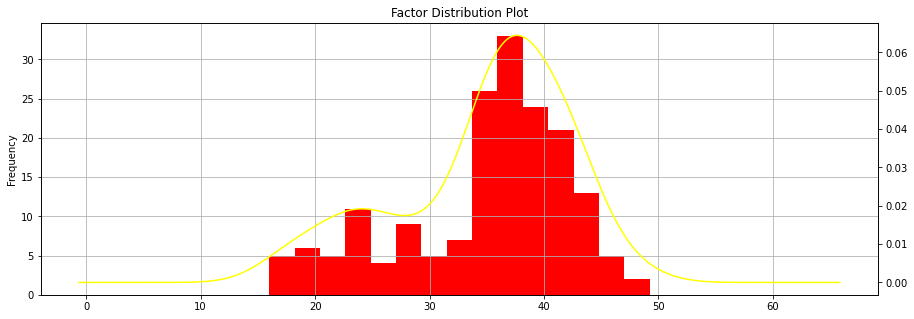

In [116]:
temp.factor.plot(kind='kde', color='yellow', secondary_y=True, title='Factor Distribution Plot')
temp.factor.plot(kind='hist', figsize=(15, 5), bins=15, color='r', grid=True);

min       mean     max       std  count
Sex                                               
Female  15.989  23.051405  30.704  3.941006     37
Male    23.872  38.036978  49.232  4.323517    139

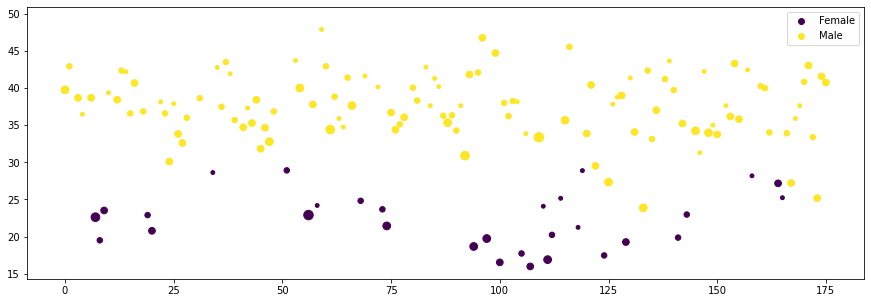

In [117]:
ages = pd.cut(temp.Age.clip(0, 100), bins=[0, 60, 65, 70, 75, 80, 85, 90, 100]).cat.codes
plt.figure(figsize=(15, 5))
sc = plt.scatter(temp.index, temp.factor, c=temp.Sex.map({"Male": 1, "Female": 0}), s=ages*15)
plt.legend(handles=sc.legend_elements()[0], labels=['Female', 'Male'])
temp.groupby(["Sex"])['factor'].agg(['min', 'mean', 'max', 'std', 'count'])

min       mean     max       std  count
SmokingStatus                                               
Currently smokes  19.870  33.934444  45.776  7.048327      9
Ex-smoker         18.676  36.488305  49.232  6.110220    118
Never smoked      15.989  31.204327  47.876  9.083038     49

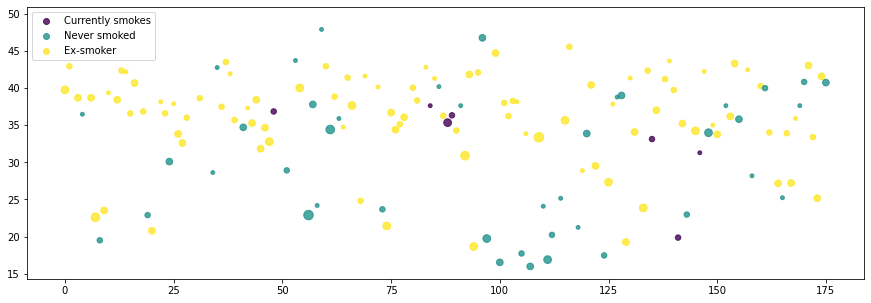

In [118]:
smkunique = temp.SmokingStatus.unique()[::-1]
plt.figure(figsize=(15, 5))
sc = plt.scatter(temp.index, temp.factor, alpha=.8, s=ages*15,
                 c=temp.SmokingStatus.map(dict(zip(smkunique, range(3)))))

plt.legend(handles=sc.legend_elements()[0], labels=smkunique.tolist())
temp.groupby(["SmokingStatus"])['factor'].agg(['min', 'mean', 'max', 'std', 'count'])

It is pretty apparant from the above graph, that factor is linearly seperable with Sex, plus Younger people are given higher percent values compared to older people. 

There's no observable relationship among the different SmokingGroups.

In [119]:
# saving values for future use
base = temp.copy()
base['Recovering'] = tf.nn.sigmoid(base['slope']).numpy()

corr = base.drop(['FVC_min', 'FVC_max'], 1).corr()

# this is really cool way to viz corelation
# its even better than plt.imshow 
corr.style.background_gradient(cmap='coolwarm')

From what we observe, factor can be sorted in ascending to descending order as follows:

1. Female + Older -> Lowest factor
2. Female + Younger -> Moderate low factor
3. Male + Older -> Moderate high factor
4. Male + Younger -> Highest factor

From the above correlation map, we also observe that another feature is involved in this equation: `Base_FVC`.

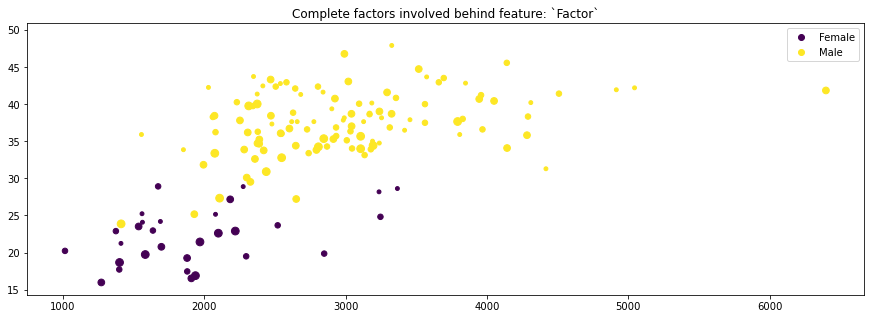

In [120]:
ages = pd.cut(temp.Age.clip(0, 100), bins=[0, 60, 65, 70, 75, 100]).cat.codes
plt.figure(figsize=(15, 5))
sc = plt.scatter(temp.Base_FVC, temp.factor, c=temp.Sex.map({"Male": 1, "Female": 0}), s=ages*15)
plt.legend(handles=sc.legend_elements()[0], labels=['Female', 'Male'])
plt.title("Complete factors involved behind feature: `Factor`");

The graph says it all. Greater the Base_FVC, greater the factor. Age, Sex are furthermore used for computing factor.

In [121]:
temp.sample(10)[['Base_Percent', 'Base_FVC', 'Sex', 'Age', 'factor', 'slope']].sort_values(
    ['Sex', 'Age'], ascending=[True, False])

Base_Percent  Base_FVC     Sex  Age  factor      slope
119     78.797950      2276  Female   63  28.884   9.052208
98      85.576792      1885  Female   58  22.027  -5.131121
167     97.405938      2651    Male   74  27.216   0.016660
175     71.824968      2925    Male   73  40.724  -1.081317
76      77.003606      2648    Male   73  34.388  -4.263502
116     90.939037      4141    Male   70  45.536  -5.165911
31      82.073322      3170    Male   70  38.624   4.180071
18      89.929425      3313    Male   68  36.840 -10.831542
39      82.212508      2934    Male   68  35.688  -3.622019
149     91.171429      3191    Male   64  35.000 -15.030663

In [122]:
# use pmb_avg & pms_avg when using base_shift
temp = pd.get_dummies(base_shift(train, q=0).merge(
        base.iloc[:, [0, 7, 8, 9, 10, 11, 12, 13, 14]],
        on='Patient'), columns=['Sex', 'SmokingStatus'], 
               drop_first=True, prefix='', prefix_sep='')

# we do a cumsum here since we can then subtract the cumsum
# from base FVC when needed
temp['pms_avg_cum'] = (
    temp.groupby("Patient")['Weeks'].transform("diff").fillna(0) * 
    temp['pms_avg']
).groupby(temp.Patient).cumsum()

temp['Recovering'] = temp['slope'] > 0

temp.columns

Index(['Patient', 'Weeks', 'FVC', 'Percent', 'Age', 'Base_Week', 'Base_FVC',
       'Base_Percent', 'Week_Offset', 'factor', 'pmb_avg', 'pms_avg', 'slope',
       'I_FVC', 'FVC_mean', 'FVC_min', 'FVC_max', 'Male', 'Ex-smoker',
       'Never smoked', 'pms_avg_cum', 'Recovering'],
      dtype='object')

Let's see if we can predict these features using a LR model and then try to make predictions using it (Essentially chaining predictions):

In [123]:
to_drop = ["Patient", 'Percent', 'FVC', 'Weeks', 'Base_Week',
           'pmb_avg', 'pms_avg_cum', 'slope', 'I_FVC', 'FVC_mean', 'FVC_min', 
           'FVC_max', 'pms_avg']

print ("Baseline score to beat: {:.2f}\n".format(
     cross_val_score(
        LinearRegression(),
        temp.drop(to_drop + ['Male', 'Ex-smoker', 'Never smoked', 'Age'], 1),
        temp['FVC'],
        groups=temp.Patient,
        scoring=l1(70),
        cv=GroupKFold(5)).mean()
))

for no_drop in [['pmb_avg'], ['pms_avg'], ['pms_avg_cum'], 
                ['slope', 'I_FVC'], ['FVC_mean'], ['FVC_min', 'FVC_max']]:
    
    if no_drop in [['FVC_ratio'], ['pms_avg_cum'], ['slope'], ['pms_avg']]:
        To_drop = to_drop + ['Male', 'Ex-smoker', 'Never smoked', 'Age']
    else:
        To_drop = to_drop

    print ("The score with {:20} as features is: {:.2f} (Actual) | {:.2f} (Pred) | {:.2f} (Avg)"
           .format(
               ', '.join(no_drop), 
        
            cross_val_score(
            LinearRegression(),
            temp.drop(np.setdiff1d(To_drop, no_drop), 1),
            temp['FVC'],
            groups=temp.Patient,
            scoring=l1(70),
            cv=GroupKFold(5)).mean(),

            cross_val_score(
            LinearRegression(),
            np.hstack([temp.drop(To_drop, 1), cross_val_predict(
                LinearRegression(),
                temp[['Base_FVC', 'Base_Percent', 
                      'Week_Offset', 'factor', 
                      'Age', "Male"]],
                temp[no_drop],
                cv=GroupKFold(5),
                groups=temp.Patient,)]),
            temp['FVC'],
            groups=train.Patient,
            scoring=l1(70),
            cv=GroupKFold(5)).mean(),
               
            cross_val_score(
            LinearRegression(),
            pd.concat([
                temp.drop(To_drop, 1), 
                temp.groupby(['Male'])[no_drop].transform('mean')
            ], axis=1),
            temp['FVC'],
            groups=train.Patient,
            scoring=l1(70),
            cv=GroupKFold(5)).mean()
    ))

Baseline score to beat: 7.65

The score with pmb_avg              as features is: 6.83 (Actual) | 7.67 (Pred) | 7.71 (Avg)
The score with pms_avg              as features is: 7.30 (Actual) | 7.65 (Pred) | 7.66 (Avg)
The score with pms_avg_cum          as features is: 7.33 (Actual) | 7.65 (Pred) | 7.66 (Avg)
The score with slope, I_FVC         as features is: 7.07 (Actual) | 7.62 (Pred) | 7.71 (Avg)
The score with FVC_mean             as features is: 6.72 (Actual) | 7.62 (Pred) | 7.71 (Avg)
The score with FVC_min, FVC_max     as features is: 7.11 (Actual) | 7.69 (Pred) | 7.71 (Avg)


Although they are successful in beating our baseline score, they are still unsuccessful in beating our augment-multibaseweek pipeline. Let's try to predict these features from the image scans to the best we can.

In [124]:
base.sample(5).drop("Patient", 1)

Age   Sex     SmokingStatus  Base_Week  Base_FVC  Base_Percent  factor  \
67    58  Male  Currently smokes         16      4124     90.090877  45.776   
103   67  Male         Ex-smoker         34      2061     53.879536  38.252   
170   66  Male      Never smoked          8      3357     82.247158  40.816   
22    63  Male         Ex-smoker         16      3255     85.343471  38.140   
166   66  Male         Ex-smoker         21      3179     93.764748  33.904   

      pmb_avg   pms_avg     slope        I_FVC     FVC_mean  FVC_min  FVC_max  \
67  -1.924589 -0.025122 -1.510683  4091.795262  4035.900000     3852     4201   
103  2.158202  0.211332  2.557150  2014.845688  2143.555556     2061     2257   
170 -0.966397  0.137076 -1.161601  3345.563035  3317.555556     3240     3397   
22  -1.564412 -0.587938 -6.741823  3420.809851  3195.333333     2890     3418   
166 -2.461198 -0.050001 -4.513049  3262.036919  3095.555556     2944     3201   

     Recovering  
67     0.180838  
103    0.928052  
170    0.238377  
22     0.001179  
166    0.010846

Of all these features, the most important feature that makes sense to predict from the scans is `pmb_avg` & `slope`. Let's do a bit of analysis on the data we hadn't analysed before we proceed:

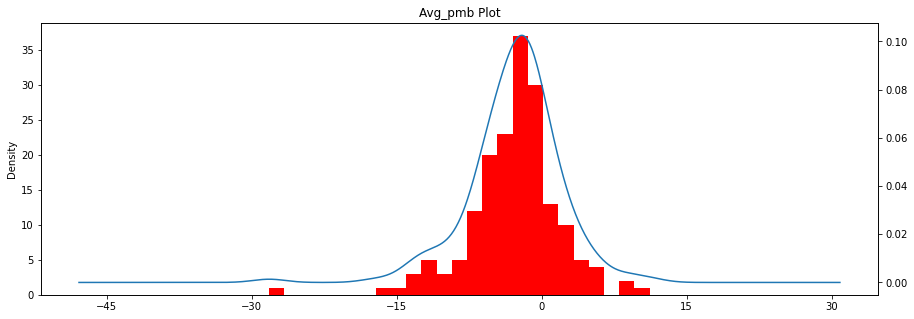

In [125]:
base['pmb_avg'].plot(kind='hist', figsize=(15, 5), xticks=range(-150, 150, 15), bins=25, color='r')
base['pmb_avg'].plot(kind='kde', secondary_y=True, title='Avg_pmb Plot');

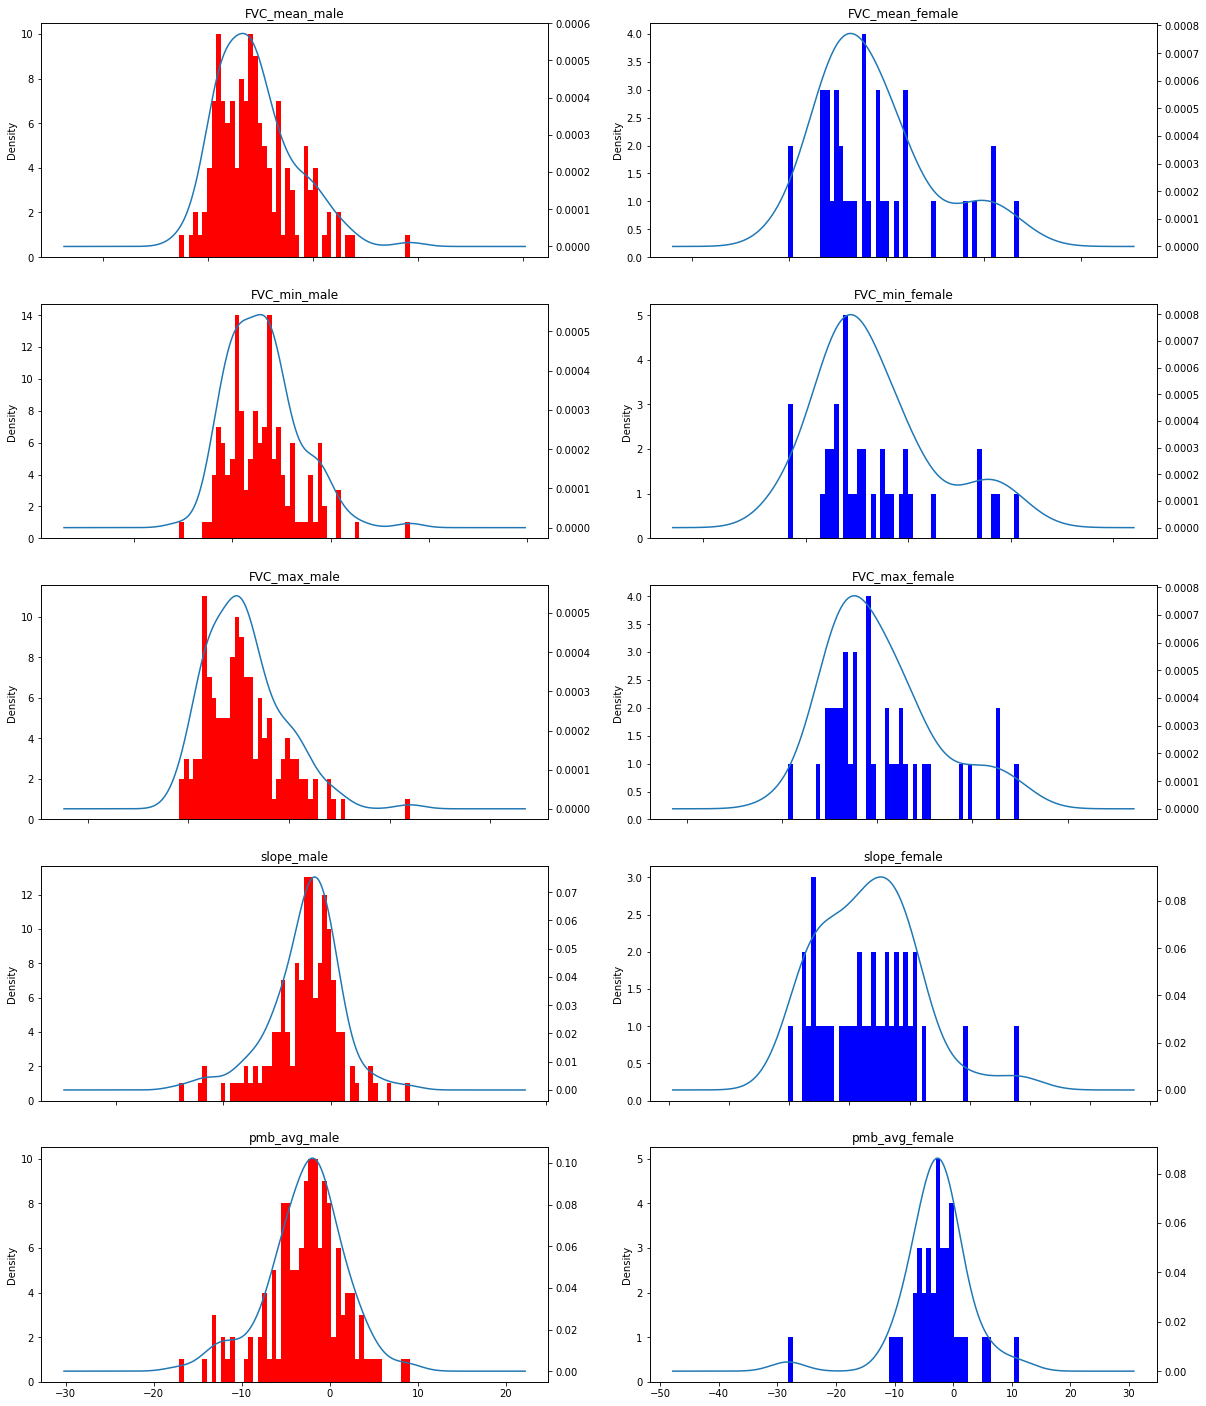

In [126]:
f, ax = plt.subplots(nrows=5, ncols=2, figsize=(20, 25), sharex=False, sharey=False)

features = ['FVC_mean', 'FVC_min', 'FVC_max', 'slope', 'pmb_avg']
for i, feat in enumerate(features):
    base[feat][base.Sex == 'Male'].plot(kind='hist', bins=50, ax=ax[i][0], color='red')
    base[feat][base.Sex == 'Male'].plot(kind='kde', secondary_y=True, ax=ax[i][0])
    ax[i][0].set(title=feat+'_male')
    
    base[feat][base.Sex == 'Female'].plot(kind='hist', bins=50, ax=ax[i][1], color='blue')
    base[feat][base.Sex == 'Female'].plot(kind='kde', secondary_y=True, ax=ax[i][1])
    ax[i][1].set(title=feat+'_female')

We can observe that *Females* distribution are much more scattered than it is for Males due to lesser samples available. However the distribution themselves are the same.

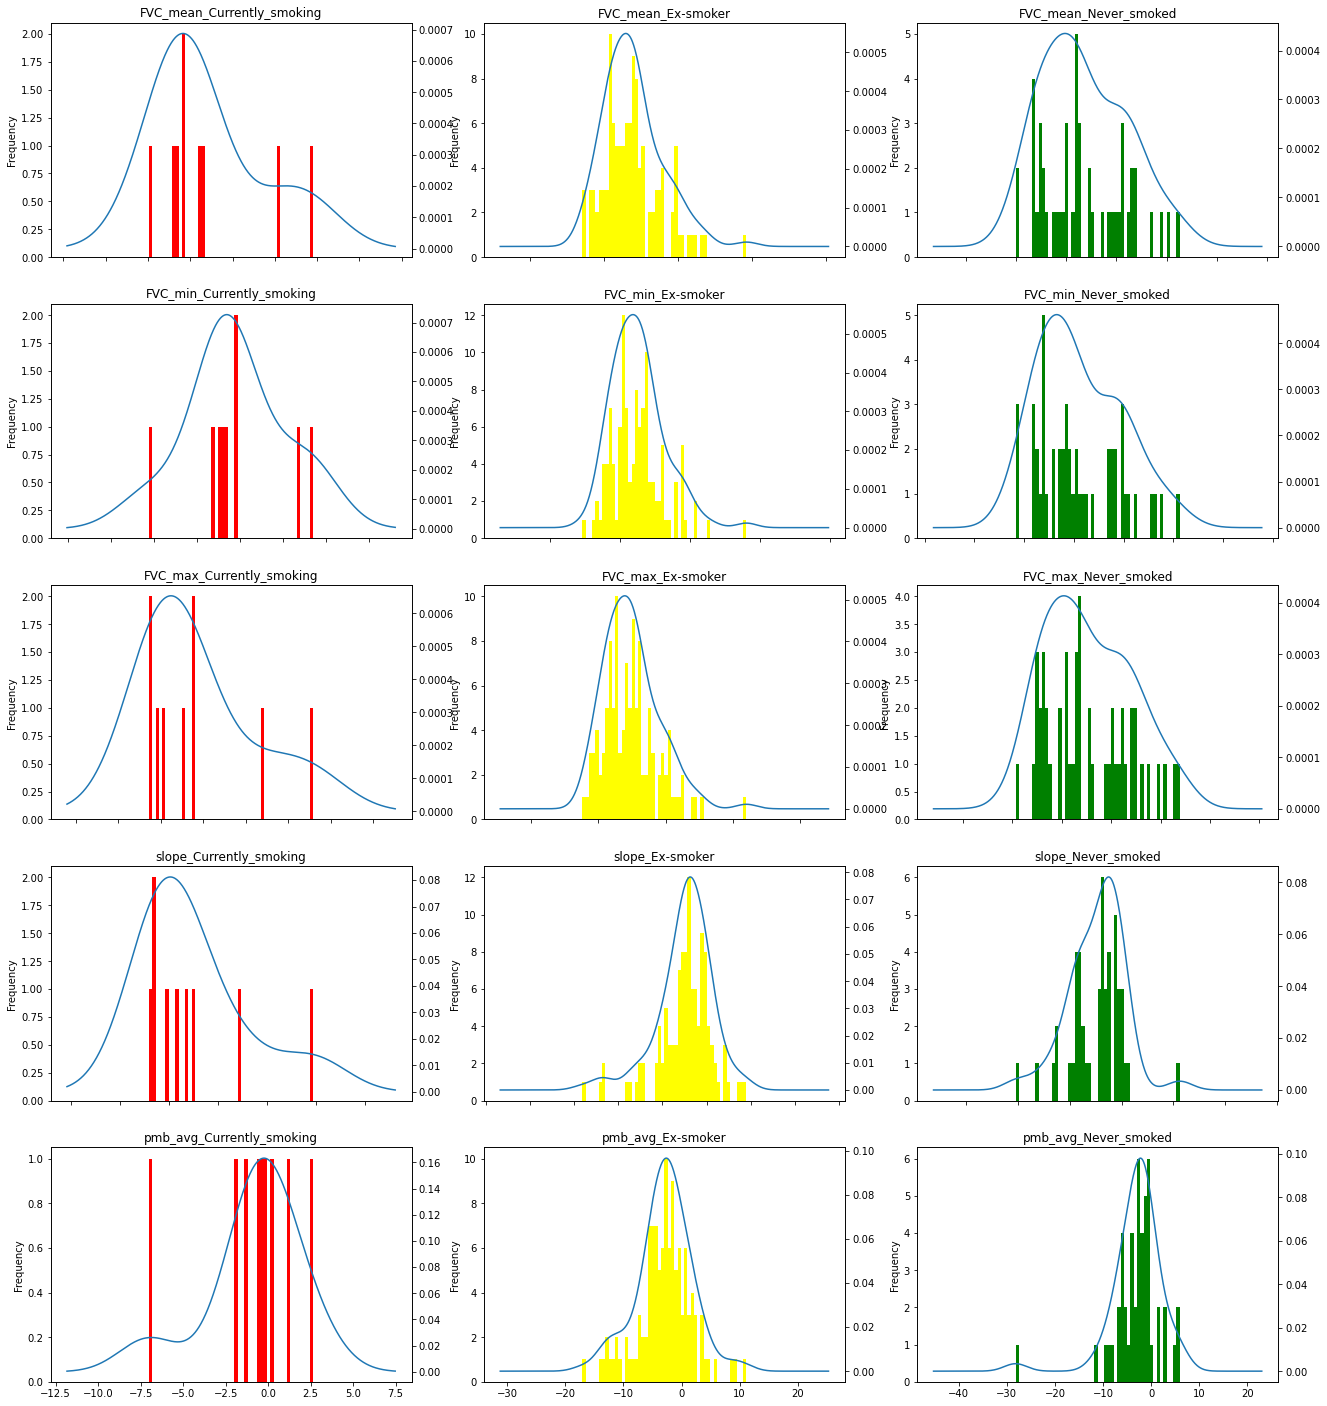

In [127]:
f, ax = plt.subplots(nrows=5, ncols=3, figsize=(22, 25), sharex=False, sharey=False)

for i, feat in enumerate(features):
    base[feat][base.SmokingStatus == 'Currently smokes'].plot(kind='kde', secondary_y=True, ax=ax[i][0])
    base[feat][base.SmokingStatus == 'Currently smokes'].plot(kind='hist', bins=50, ax=ax[i][0], color='red')
    ax[i][0].set(title=feat+'_Currently_smoking')
    
    base[feat][base.SmokingStatus == 'Never smoked'].plot(kind='kde', secondary_y=True, ax=ax[i][2])
    base[feat][base.SmokingStatus == 'Never smoked'].plot(kind='hist', bins=50, ax=ax[i][2], color='green')
    ax[i][2].set(title=feat+'_Never_smoked')
    
    base[feat][base.SmokingStatus == 'Ex-smoker'].plot(kind='kde', secondary_y=True, ax=ax[i][1])
    base[feat][base.SmokingStatus == 'Ex-smoker'].plot(kind='hist', bins=50, ax=ax[i][1], color='yellow')
    ax[i][1].set(title=feat+'_Ex-smoker')

#### Let's start with the Scans now:

Lets start with the images we have been provided with now. How many slices per patient exists?

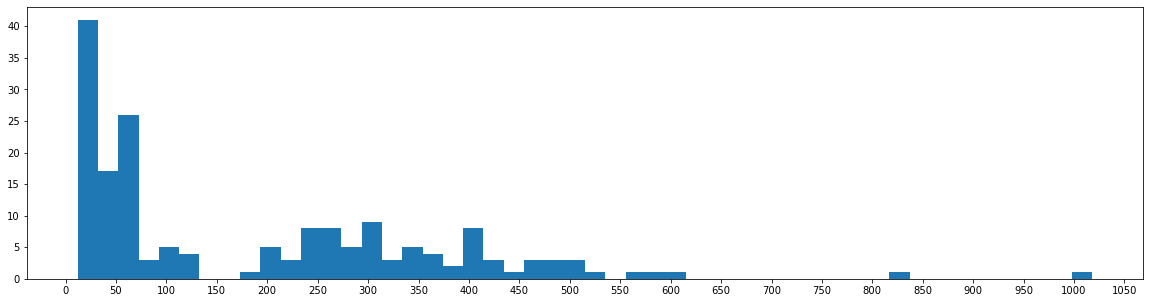

In [128]:
temp = {}
for pat, _ in map(lambda x: x.split("/")[-2:], train_files):
    temp[pat] = temp.get(pat, 0) + 1
    
plt.figure(figsize=(20, 5))
plt.hist(temp.values(), bins=50)
plt.xticks(range(0, 1051, 50));

ID's without an ImagePositionPatient attribute: ID00128637202219474716089, ID00132637202222178761324, ID00026637202179561894768

ID's that require GDCM: ID00011637202177653955184, ID00052637202186188008618

In [129]:
BAD_IDS = ['ID00011637202177653955184', 'ID00052637202186188008618']

#### Let's write a function to extract the scan images in order. 

We want to be able to stride and load them when required. Say just every 5th image, every 10th image and so on. So we use a parameter called `max_size` to load specified strides of images. Although some or maybe a lot of data might lost in this process, it helps to have all scans of a particular size. We chose size = 10 as default since the minimum scans for a patient is 12.

In [130]:
def extract_patient(patient_loc, max_size=10):    
    import glob
    
    images, positions, instances = [], [], []
    for dcm_file in glob.glob(patient_loc+"/*"):
        temp = pydicom.dcmread(dcm_file)
        
        if 'ImagePositionPatient' in temp:
                positions.append(temp.ImagePositionPatient[2])
                
        instances.append(temp.InstanceNumber)
        images.append(temp.pixel_array)
            
    # for those images where position exists for all images
    if len(positions) == len(images):
        patients = np.argsort(positions)
    
    # certain images don't have this attrib, and we have to use
    # the Instance number for ordering the scan images
    else:
        patients = np.argsort(instances)
        
    if max_size == None: # max_size = None -> extract all images
        max_size = len(images)
        
    # here we stride and load the images, dropping those in between
    patients = patients[np.linspace(0, len(images)-1, max_size).astype(int)]
    return  np.stack(images)[patients]

In [131]:
images = extract_patient(
    f'{main_dir}/train/ID00052637202186188008618', # a bad Image, check if GDCM works
    max_size=10)

images.shape, images.min(), images.max()

((10, 512, 512), 0, 4000)

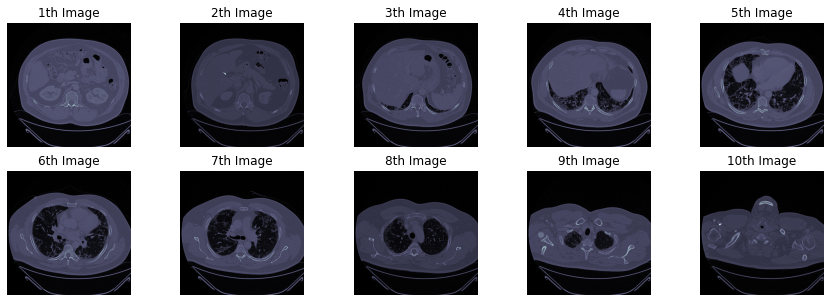

In [132]:
f, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 5))
ax = ax.ravel()
for i, img in enumerate(images):
    ax[i].imshow(img, cmap='bone')
    ax[i].axis('off')
    ax[i].set(title=str(i + 1)+'th Image')

Let's visualize their std, min, mean and max. Maybe this could simply be fed to our model in making its predictions.

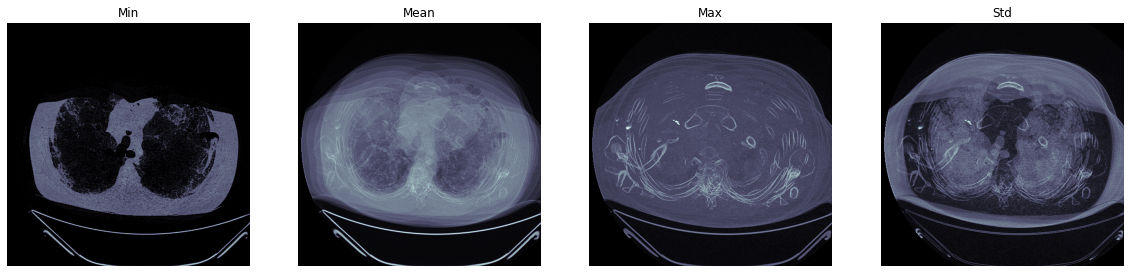

In [133]:
f, ax = plt.subplots(ncols=4, figsize=(20, 5))
for i, (name, img) in enumerate([
    ("Min", images.min(0)), ("Mean", images.mean(0)), 
    ("Max", images.max(0)), ("Std", images.std(0))]):

    ax[i].imshow(img, cmap='bone')
    ax[i].axis('off')
    ax[i].set(title=name)

Let's now create a function to visualize the scans as an animation. Code copied in part from [here](https://www.kaggle.com/gunesevitan/osic-pulmonary-fibrosis-progression-eda):

In [134]:
def display_scan(images):
    '''
    We alter and modify gunesevitan's function to be able to display the animation
    according to the number of slices we have in the scan.
    '''
    import matplotlib.animation as animation

    fig, ax = plt.subplots(figsize=(7, 7))

    ims = []
    for i in images:
        im = ax.imshow(i, animated=True, cmap=plt.cm.bone)
        ax.axis('off')
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=1500/len(images), repeat_delay=1000)
    return ani.to_html5_video()

In [135]:
%%capture
ani = display_scan(images)

In [136]:
from IPython.display import HTML
HTML(ani)

The code below can be used for segmenting the scans. 

*I am total newb so I may be totally incorrect in doing this. But doing this helped in improving my embeddings loss a bit more than feeding in the scans after a simple scaling. Maybe my segmentation can be still improved by following all the procdures from [here](https://www.raddq.com/dicom-processing-segmentation-visualization-in-python/). I didn't have much time to play around.*

In [137]:
def segment_scans(images, n_clusters=2):
    '''Function to segment the Lungs from background'''
    from sklearn.cluster import KMeans
    
    # we do this so that, KMeans only sees the lung area
    q, (timesteps, shape) = .25, images.shape[:2]
    first, last = int(shape * q), int(shape * (1 - q))
    
    # find out the threshold for that scan using KMeans
    km = KMeans(n_clusters=n_clusters)
    cc = km.fit(images[:, first:last, first:last].reshape(timesteps, -1)).cluster_centers_
    threshold = np.mean(cc)
    
    return np.where(images < threshold, 1., 0.)

In [138]:
%%capture
segmented_images = segment_scans(images / 2048)
ani = display_scan(segmented_images)

How the same image looks after segmentation:

In [139]:
print (segmented_images.min(), segmented_images.max(), np.unique(segmented_images))
HTML(ani)

0.0 1.0 [0. 1.]


Although unsegmented images intially perform good, our segmented images model is able to better capture the scans as embeddings. *Perhaps we need a more powerful model with unsegmented images.*

From these images as we had mentioned earlier, we try to predict two values:
1. slope of FVC of the Patient
2. Recovering or not

For this purpose we create an **Convolutional Autoencoder.**

In [140]:
def get_model_small(timesteps=10, imgsize=256, segment=True):
    
    seq = tf.keras.models.Sequential()
    seq.add(tf.keras.layers.Input(shape=(timesteps, imgsize, imgsize, 1)))
    seq.add(tf.keras.layers.TimeDistributed(
        tf.keras.layers.Conv2D(64, (11, 11), strides=2, padding="same")))
    seq.add(tf.keras.layers.LayerNormalization())
    seq.add(tf.keras.layers.TimeDistributed(
        tf.keras.layers.Conv2D(32, (7, 7), strides=2, padding="same")))
    seq.add(tf.keras.layers.LayerNormalization())
    seq.add(tf.keras.layers.TimeDistributed(
        tf.keras.layers.Conv2D(16, (5, 5), strides=2, padding="same")))
    seq.add(tf.keras.layers.LayerNormalization())
    
    # # # # #
    seq.add(tf.keras.layers.ConvLSTM2D(16, (3, 3), padding="same", return_sequences=True))
    seq.add(tf.keras.layers.LayerNormalization())
    seq.add(tf.keras.layers.ConvLSTM2D(8, (3, 3), padding="same", return_sequences=True, name='enc_op'))
    seq.add(tf.keras.layers.LayerNormalization())
    seq.add(tf.keras.layers.ConvLSTM2D(16, (3, 3), padding="same", return_sequences=True))
    seq.add(tf.keras.layers.LayerNormalization())
    # # # # #

    seq.add(tf.keras.layers.TimeDistributed(
        tf.keras.layers.Conv2DTranspose(16, (5, 5), strides=2, padding="same")))
    seq.add(tf.keras.layers.LayerNormalization())
    seq.add(tf.keras.layers.TimeDistributed(
        tf.keras.layers.Conv2DTranspose(32, (7, 7), strides=2, padding="same")))
    seq.add(tf.keras.layers.LayerNormalization())
    seq.add(tf.keras.layers.TimeDistributed(
        tf.keras.layers.Conv2DTranspose(64, (11, 11), strides=2, padding="same")))
    seq.add(tf.keras.layers.LayerNormalization())
    seq.add(tf.keras.layers.TimeDistributed(
        tf.keras.layers.Conv2D(1, (11, 11), activation="sigmoid", padding="same")))
    
    seq.compile(
        loss='binary_crossentropy' if segment else 'mse', 
        optimizer=tf.keras.optimizers.Adam(lr=1e-4, decay=1e-5, epsilon=1e-6))
    
    return seq

Also write a function to be able to fetch the tabular data we want the model to be able to predict:

In [141]:
class DataGen(tf.keras.utils.Sequence):
    def __init__(
        self, patients, batch_size=4, unsupervised=True, scans=None, loc='train', 
        targets=['Recovering', 'slope'], augment=True, maxsize=10):
        
        '''
        What augment parameter does?
            Since we are using strided image slices, for each slice we could chose
            the previous or the next slice randomly without causing much problem for 
            the model. This idea is exploited to create augmented scan data.
            
        We could use this for test data to maybe predict the uncertainity. But as I said,
        unimplemented ideas :)
        '''
        
        self.patients = patients
        self.patient_count = len(patients)
        self.batch_size = batch_size
        self.unsupervised = unsupervised
        self.loc = loc
        self.targets = targets
        self.scans = scans
        self.maxsize = maxsize
        self.augment = augment
        
    def __len__(self):
        return self.patient_count // self.batch_size
    
    def __getitem__(self, idx):
        
        scan_slices, tab = [], []
        for pat in self.patients[idx * self.batch_size: (idx+1) * self.batch_size]:
            
            if self.loc == 'train':
                temp = np.load(scans[pat])
            else:
                temp = np.load(test_scans[pat])
                
            mask = np.linspace(0, len(temp)-1, self.maxsize).astype(int)
                
            if self.augment:
                # possb combinations -> 3 ** (self.maxsize - 2)
                mask = (mask + np.concatenate([[0], np.random.randint(-1, 2, size=self.maxsize-2), [0]]))
                
            scan_slices.append(temp[mask])
                
            if not self.unsupervised:
                tab.append(self.fetch_tab(pat, targets=self.targets))
        
        scan_slices = np.stack(scan_slices)
        
        if self.unsupervised:
            return scan_slices, scan_slices
        else:
            tab = np.stack(tab).astype(float)
            return scan_slices, [tab[..., i] for i in range(len(self.targets))]
        
    def fetch_tab(self, pat, targets, data=base):
        '''Given patient location, fetch the given as targets'''
        return base.loc[base.Patient == pat, targets].values
        
    def __on_epoch_end__(self):
        np.random.shuffle(self.patients)

In [142]:
tf.keras.backend.clear_session()

imgsize = 384
timesteps = 8
batch_size = 4
segment = True
trained = True   

autoenc = get_model_small(imgsize=imgsize, timesteps=timesteps, segment=segment)
print ("Features Per Patient: {:20}\nTotal Number of Model Parameters: {:8}"
       .format(np.prod(autoenc.get_layer("enc_op").output.shape[1:]), 
              autoenc.count_params()))

Features Per Patient:               147456
Total Number of Model Parameters:   448017


Loading the scan each and every time for the model training purpose will prove a bottle neck for model training. So the best solution would be to process them and save them as .npy files and load them as needed. 

`Warning:` Choosing higher imgsize or timesteps would cause an OSError resulting from insufficient physical memory space. They have already been optimized.

In [143]:
import os
extracted_loc = "./patient_saves"
if not os.path.exists(extracted_loc):
    os.mkdir(extracted_loc)

scans = {}
for pat in tqdm(train.Patient.unique()):
    
    temp = tf.image.resize(
        extract_patient(f"{main_dir}/train/{pat}", max_size=timesteps*2)[..., tf.newaxis], 
        (imgsize, imgsize), method='nearest').numpy() / 2048

    if segment:
        temp = segment_scans(temp)

    np.save(f"{extracted_loc}/{pat}.npy", temp)

    scans[pat] = f"{extracted_loc}/{pat}.npy"

test_scans = {}
for pat in tqdm(test.Patient.unique()):
    
    temp = tf.image.resize(
        extract_patient(f"{main_dir}/test/{pat}", max_size=timesteps)[..., tf.newaxis],
        (imgsize, imgsize), method='nearest').numpy() / 2048

    if segment:
        temp = segment_scans(temp)

    np.save(f"{extracted_loc}/{pat}.npy", temp)

    test_scans[pat] = f"{extracted_loc}/{pat}.npy"

print (len(scans), len(test_scans))

100%|██████████| 5/5 [00:09<00:00,  1.92s/it]

176 5


Is our pipe Working good?

In [144]:
%%capture

temp =  DataGen(train_patients, batch_size=batch_size, scans=scans, maxsize=timesteps)[0][0][0]
temp = tf.squeeze(temp)
ani = display_scan(temp)

In [145]:
print (temp.shape, tf.reduce_max(temp).numpy(), tf.reduce_min(temp).numpy())
HTML(ani)

(8, 384, 384) 1.0 0.0


In [146]:
if not trained:
    hist = autoenc.fit(
        DataGen(train_patients, batch_size=batch_size, scans=scans, maxsize=timesteps),
        validation_data=DataGen(val_patients, batch_size=batch_size, 
                                scans=scans, maxsize=timesteps, augment=False),  
        epochs=25, callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=3, mode='min', restore_best_weights=True),
            tf.keras.callbacks.ModelCheckpoint(
                'Model_Save-{val_loss:.3f}.hdf5', 
                save_best_only=True, mode='min')])
    
    # load the best weights
    best_weight = min(glob.glob("./*.hdf5"), key=lambda x: float(x.split("-")[-1][:-5]))
    
else:
    best_weight = '../input/osic-weights/Model_Save-0.135.hdf5'
    
# load the best weights
autoenc.load_weights(best_weight)

In [147]:
# validation embeddings loss
autoenc.evaluate(DataGen(val_patients, batch_size=batch_size, scans=scans, maxsize=timesteps, augment=False))

6/6 [==============================] - 2s 323ms/step - loss: 0.1610


0.16096442937850952

How well does our model make the predictions on unseen samples?

In [148]:
%%capture
temp = np.load(scans[np.random.choice(val_patients)])
ani = display_scan(np.squeeze(autoenc.predict(
    temp[np.linspace(0, len(temp)-1, timesteps).astype(int)][np.newaxis, :]
)))

In [149]:
# the encoded part looks like this
HTML(ani)

*Yes, embeddings are pretty bad xD. Maybe could be improved by training for a longer epochs or using a more powerful model.*

For now let's use this embeddings to predict slopes for our patients. We create another model for this purpose. We feed in the embeddings and the model outputs the slope for that particular patient:

In [150]:
def get_slope_model(base_model, best_weight=best_weight):
    
    base_m = tf.keras.models.clone_model(base_model)
    base_m.load_weights(best_weight)
    
    base_m.trainable = False
    inp = base_m.input
    enc_op = base_m.get_layer("enc_op").output
    enc_avg = tf.keras.layers.TimeDistributed(tf.keras.layers.GlobalAveragePooling2D())(enc_op)

    lstm1 = tf.keras.layers.LSTM(
        units=128, activation='relu',
        kernel_initializer='he_normal')(enc_avg)

    s_op = tf.keras.layers.Dense(1, name='Slope_op')(lstm1)
    r_op = tf.keras.layers.Dense(1, activation='sigmoid', name='Recovery_op')(s_op)

    model = tf.keras.models.Model(inputs=inp, outputs=[r_op, s_op])
    model.compile(loss=['binary_crossentropy', 'mse'], optimizer='adam')
    return model

In [151]:
folds = 3
total_patients = train.Patient.unique()
np.random.shuffle(total_patients)
val_len = len(total_patients) // folds

val_preds, test_preds = np.zeros((val_len, 2)), np.zeros((len(test), 2))

for i in range(folds):
    
    model = get_slope_model(base_model=autoenc)
   
    val_patients = total_patients[(i)*val_len:(i+1)*val_len]
    train_patients = np.setdiff1d(total_patients, val_patients)
    
    assert len(np.intersect1d(val_patients, train_patients)) == 0
    
    print (f"Starting Fold #{i+1} {'='*36}>")
    
    hist = model.fit(
        DataGen(
            train_patients, unsupervised=False, scans=scans, 
            batch_size=batch_size, maxsize=timesteps), 
        
        validation_data=DataGen(
            val_patients, unsupervised=False, scans=scans, 
            batch_size=batch_size, maxsize=timesteps, augment=False),
        
        verbose=0, epochs=50, callbacks=[tf.keras.callbacks.EarlyStopping(
            patience=5, mode='min', monitor='val_loss', verbose=1, restore_best_weights=True)]
    )
    
    print ("Last Val Score (Pre Fine tune) : {:.2f}".format(hist.history['val_loss'][-1]))

    # fine tuning
    model.trainable = True
    model.compile(loss=['binary_crossentropy', 'mse'], optimizer=tf.keras.optimizers.Adam(0.0001))

    hist = model.fit(
        DataGen(train_patients, unsupervised=False, batch_size=batch_size, 
                scans=scans, maxsize=timesteps),
        
        validation_data=DataGen(val_patients, batch_size=batch_size, unsupervised=False, 
                                scans=scans, maxsize=timesteps, augment=False),
        
        verbose=0, initial_epoch=50, epochs=60,  callbacks=[tf.keras.callbacks.EarlyStopping(
            patience=3, mode='min', monitor='val_loss', restore_best_weights=True, verbose=1)]
    )
    
    print ("Last Val Score (Post Fine tune): {:.2f}\n{}\n".format(hist.history['val_loss'][-1], "="*55))
    
    val_preds = val_preds + np.hstack(model.predict(DataGen(
        val_patients, batch_size=1, scans=scans, maxsize=timesteps, augment=False))) / folds

    test_preds = test_preds + np.hstack(model.predict(DataGen(
        test['Patient'].tolist(), loc='test', batch_size=1, 
        scans=test_scans, maxsize=timesteps, augment=False))) / folds

Starting Fold #1 ====================================>
Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Last Val Score (Pre Fine tune) : 40.31
Restoring model weights from the end of the best epoch.
Epoch 00058: early stopping
Last Val Score (Post Fine tune): 40.55

Starting Fold #2 ====================================>
Restoring model weights from the end of the best epoch.
Epoch 00008: early stopping
Last Val Score (Pre Fine tune) : 47.16
Restoring model weights from the end of the best epoch.
Epoch 00057: early stopping
Last Val Score (Post Fine tune): 47.52

Starting Fold #3 ====================================>
Last Val Score (Pre Fine tune) : 28.28
Restoring model weights from the end of the best epoch.
Epoch 00055: early stopping
Last Val Score (Post Fine tune): 28.17



In [152]:
THRESH = 0.5
test['Recovering'] = test_preds[:, 0] > THRESH
test['slope'] = test_preds[:, 1]

test.head()

Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus  \
0  ID00419637202311204720264      6  3020  70.186855   73  Male     Ex-smoker   
1  ID00421637202311550012437     15  2739  82.045291   68  Male     Ex-smoker   
2  ID00422637202311677017371      6  1930  76.672493   73  Male     Ex-smoker   
3  ID00423637202312137826377     17  3294  79.258903   72  Male     Ex-smoker   
4  ID00426637202313170790466      0  2925  71.824968   73  Male  Never smoked   

   Recovering     slope  
0       False -4.498918  
1       False -4.453497  
2       False -4.444959  
3       False -4.448913  
4       False -4.447616

In [153]:
temp = pd.DataFrame(
    np.stack([val_patients, val_preds[:, 1], val_preds[:, 0] > THRESH], axis=1),
    columns=['Patient', 'slope', 'Recovering'])

temp = pd.concat([temp, base.loc[base.Patient.isin(train_patients), ['Patient', 'slope', 'Recovering']]])
temp[['slope', 'Recovering']] = temp[['slope', 'Recovering']].astype(float)

temp = train.merge(temp, on='Patient')

temp.loc[temp.Patient.isin(val_patients), 'Where'] = 'Val'
temp.loc[temp.Patient.isin(train_patients), 'Where'] = 'Train'

temp = base_shift(temp, q=0)
temp['factor'] = temp['Base_FVC'] / temp['Base_Percent']
temp['magic'] = temp['Base_FVC'] + (temp['Week_Offset'] * temp['slope'])

train_cols = ['magic', 'Week_Offset', 'factor']
lr = LinearRegression()

lr.fit(
    temp.loc[temp.Where == 'Train', train_cols], 
    temp.loc[temp.Where == 'Train', 'FVC']
)

print ("Train Score: {:.2f}\nVal Score  : {:.2f}".format(
    laplace_log_likelihood(
        temp.loc[temp.Where == 'Train', 'FVC'], 
        lr.predict(temp.loc[temp.Where == 'Train', train_cols]), 70),
    
    laplace_log_likelihood(
    temp.loc[temp.Where == 'Val', 'FVC'], 
    lr.predict(temp.loc[temp.Where == 'Val', train_cols]), 70)    
))

Train Score: -7.12
Val Score  : -7.48


In [154]:
# creating x_test for predictions simaltanesly
x_test = sub[['Patient', 'Weeks']].merge(
    test.rename({"Weeks": "Base_Week", 
                 "FVC": "Base_FVC", 
                 "Percent": "Base_Percent"}, axis=1), 
    on='Patient')

# create required features for predictions
x_test['Week_Offset'] = x_test['Weeks'] - x_test['Base_Week']
x_test['Percent'] = x_test['Base_Percent']
x_test['factor'] = x_test['Base_FVC'] / x_test['Base_Percent']
x_test['magic'] = x_test['Base_FVC'] + (x_test['slope'] * x_test['Week_Offset'])

sub['FVC'] = lr.predict(x_test[train_cols])
sub['Confidence'] = 200

# save the submissions
sub[['Patient_Week', 'FVC', 'Confidence']].to_csv("image_data_pred.csv", index=False)
sub.head()

Patient  Weeks   Sex SmokingStatus          FVC  \
0  ID00419637202311204720264    -12  Male     Ex-smoker  3072.578917   
1  ID00419637202311204720264    -11  Male     Ex-smoker  3068.256902   
2  ID00419637202311204720264    -10  Male     Ex-smoker  3063.934886   
3  ID00419637202311204720264     -9  Male     Ex-smoker  3059.612871   
4  ID00419637202311204720264     -8  Male     Ex-smoker  3055.290855   

   Confidence                   Patient_Week  
0         200  ID00419637202311204720264_-12  
1         200  ID00419637202311204720264_-11  
2         200  ID00419637202311204720264_-10  
3         200   ID00419637202311204720264_-9  
4         200   ID00419637202311204720264_-8

#### Final Words:

- I did try quantile regressions using Pinball loss. Didn't give me satisfactory results.
- I tried my own neural network architectures and it performed poorly. In my own words: The problem is that it compromises on the RMSE instead of focusing on both, which is pretty apparent from the high Confidence values.

Ideas left unimplemented:
- The way doctors analyze scans is to compare the scans with similar scans that they had already seen (in their memory). So we could compare the scans using embeddings we had created earlier and for a patient, choose a patient most similar to and use the slope we had seen from him.
- Using embeddings to measure similarity of patients is so much more reliable than using their slopes, pms_avg, etc. So this could be exploited for creating tabular data augmentations as well.

This concludes this Notebook. I hope you enjoyed reading this notebook of mine. Have a fantastic day, you are awesome <3